In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from matplotlib import colors, image, spines, patches, transforms
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import brier_score_loss, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from typing import Iterable, Optional
import pandas as pd
from sklearn.model_selection import train_test_split


### Define output path 

In [2]:
# Define the path to save all outputs to
output_path = "/Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2"

# Check the output path exists
if not os.path.exists(output_path):
    raise OSError(f"Output directory does not exist at '{output_path}'.")

In [3]:
# Define Sylvera colours for plotting
bright_green = '#bff102'
dark_green = '#144a08'
bright_purple = '#cea2fa'
dark_purple = '#8a46cf'

# Data Imports & Parameters
This notebook does not include all pre-processing, which involved producing deforestation rates, HFLD scores, forest coverages. In the covariates tabels, edge density, mean patch size, and patch density were all derived outside this notebook in R.

The deforestation data was sourced from Global Forest Watch.

**Note:** The HFLD definition used in this study is based upon that used by ART Trees, where a jurisdiction with an HFLD score above 0.5 is denoted as 'HFLD'. The equation for the HFLD score is given below:

- HFLD Score = Defor. Score + Forest Score

- Defor. Score = 0.5% - Defor. rate [as a %]

- Forest Score = (Forest Coverage [as a %] - 50%) / 100

The condition in the ART definition for a HFLD to maintain a HFLD score above 0.5 over a 5 year period is **not used in this work**, as we are considering row wise predictions for each year. However, we will calculate this condiiton as an additional output as the end.

In [4]:
## UPDATE PATHS TO DATA FOR EXTERNAL USERS ####

# Read in the deforestation statistics
defor_df = pd.read_csv('/Users/rexdevereux/Desktop/Python/earth-data-hub/data/predicted-deforestation/defor_stats_ART_with_biome.csv')

# Read in the covariates for each jurisdiction
covars_df = pd.read_csv('/Users/rexdevereux/Desktop/Python/earth-data-hub/data/predicted-deforestation/covars_sylvera.csv')


### UPDATE PARAMETERS BASED ON RUN WANTED ####

# Model 1 
TARGET = "deforRate_5yr"  # or "deforRate"

# Columns that should never be used as predictors
ID_COLS   = ["admin", "name", "year"]
LEAKY_COLS = ["HFLD_score", "HFLD", "HFLD_full_condition", "deforRate", "deforRate_5yr"]

## Cleaning data

In [5]:
check_pairs = [
    ("Australia", "Jervis Bay Territory"),
    ("Cuba", "Guantánamo")
]

for country, region in check_pairs:
    exists = ((defor_df["country"] == country) & (defor_df["region"] == region)).any()
    print(f"{country}-{region}: {'FOUND' if exists else 'NOT FOUND'}")


Australia-Jervis Bay Territory: FOUND
Cuba-Guantánamo: FOUND


Jervis Bay Territory and Cuba- Guantanamo are found in original defor df, but are removed through the filtering below due to exteremly high loss years https://www.globalforestwatch.org/dashboards/country/CUB/6/?map=eyJjYW5Cb3VuZCI6dHJ1ZX0%3D
 

https://www.globalforestwatch.org/dashboards/country/AUS/4/?map=eyJjYW5Cb3VuZCI6dHJ1ZX0%3D


# Data Preparation
### Filtering Deforestation and Covariate Tables
This cell filters out low forest (i.e. urban) areas and high deforestation rates (possibly due to wildfires) from the deforestation data. Both deforestation and covariate tables are also queried for the years where we have data for both (2001 to 2020).

In [6]:
defor_df["forAreaPct"] = defor_df["for_area"]

# Filter deforestation data for 2001-2020 and remove areas with forest area < 10% and defor. rates > 10%
defor_df = defor_df.query('year >= 2001 and year <= 2020 and forAreaPct >= 10 and deforRate <= 10')

# Pivot wide from long format
covars_wide = covars_df.pivot_table(index=['admin', 'name', 'year', 'Area'],
                                    columns='var',
                                    values='value',
                                    aggfunc='first').reset_index()



# Flatten the column names (reate MultiIndex columns)
covars_wide.columns.name = None

### Checking for Guantanamo and Jervis Bay


In [7]:
check_pairs = [
    ("Australia", "Jervis Bay"),
    ("Cuba", "Guantanamo")
]

for country, region in check_pairs:
    exists = ((defor_df["country"] == country) & (defor_df["region"] == region)).any()
    print(f"{country}-{region}: {'FOUND' if exists else 'NOT FOUND'}")

## These entries are now removed 

Australia-Jervis Bay: NOT FOUND
Cuba-Guantanamo: NOT FOUND


### Checking for duplicates

In [8]:
# Focus: Mozambique–Maputo
pair_mask = (defor_df["country"]=="Mozambique") & (defor_df["region"]=="Maputo")
pair = defor_df.loc[pair_mask].sort_values("year")

# Years with more than one row
pair_dupe_counts = pair.groupby("year").size()
print("Mozambique–Maputo duplicate years:\n", pair_dupe_counts[pair_dupe_counts>1])

Mozambique–Maputo duplicate years:
 Series([], dtype: int64)


In [9]:
# Columns that should uniquely identify a time-series row
key = ["country", "region", "year"]

# All duplicated rows across the dataset (keep=False flags *both* copies)
dupes_all = defor_df[defor_df.duplicated(subset=key, keep=False)].sort_values(key)

print("Total duplicate rows (by country, region, year):", len(dupes_all))
print(dupes_all.head(10))

# Which pairs have duplicates, and how many duplicate rows?
pairs_with_dupes = (dupes_all
    .groupby(["country","region"])
    .size()
    .reset_index(name="dup_rows")
    .sort_values("dup_rows", ascending=False))
print(pairs_with_dupes.head(20))

# Focus: Mozambique–Maputo
pair_mask = (defor_df["country"]=="Mozambique") & (defor_df["region"]=="Maputo")
pair = defor_df.loc[pair_mask].sort_values("year")

# Years with more than one row
pair_dupe_counts = pair.groupby("year").size()
print("Mozambique–Maputo duplicate years:\n", pair_dupe_counts[pair_dupe_counts>1])

# (Optional) Inspect both copies for a couple of years
years_to_peek = pair_dupe_counts[pair_dupe_counts>1].index[:3]
print(pair[pair["year"].isin(years_to_peek)])


Total duplicate rows (by country, region, year): 40
      country region  year   for_area  pc_for_area  deforRate  HFLD_score  \
1512  Belarus  Minsk  2001  44.426580     0.223421   0.223421    0.220844   
1513  Belarus  Minsk  2001  32.694980     0.163489   0.163489    0.163461   
1514  Belarus  Minsk  2002  44.268548     0.355714   0.355714    0.086972   
1515  Belarus  Minsk  2002  32.592766     0.312627   0.312627    0.013301   
1516  Belarus  Minsk  2003  44.098531     0.384058   0.384058    0.056928   
1517  Belarus  Minsk  2003  32.528606     0.196853   0.196853    0.128433   
1518  Belarus  Minsk  2004  43.897242     0.456454   0.456454   -0.017482   
1519  Belarus  Minsk  2004  32.426836     0.312866   0.312866    0.011403   
1520  Belarus  Minsk  2005  43.720558     0.402495   0.402495    0.034711   
1521  Belarus  Minsk  2005  32.329047     0.301567   0.301567    0.021724   

      HFLD  deforRate_5yr  defor_yrs_used  HFLD_full_condition   biome  \
1512     0       0.223421 

In [10]:
def dedupe_time_series(df, key=("country","region","year"), prefer_years_used_col="defor_yrs_used"):
    df = df.copy()

    # Find duplicates by the key
    dupe_mask = df.duplicated(subset=list(key), keep=False)
    dupes = df.loc[dupe_mask].sort_values(list(key))
    print(f"Duplicate rows found (by {key}): {len(dupes)}")

    if dupes.empty:
        return df, pd.DataFrame(columns=["country","region","dup_rows"])

    # Which pairs are impacted
    impacted = (dupes.groupby(list(key[:2])).size()
                      .reset_index(name="dup_rows")
                      .sort_values("dup_rows", ascending=False))
    print("Pairs with duplicates:")
    print(impacted.head(20))

    # Build a helper score: prefer higher defor_yrs_used (if present), fewer NaNs
    work = df.copy()
    if prefer_years_used_col in work.columns:
        # Negate so higher years_used sorts first (ascending sort later)
        work["_neg_years_used"] = -work[prefer_years_used_col].fillna(-1)
    else:
        work["_neg_years_used"] = 0  # neutral if missing

    work["_nan_count"] = work.isna().sum(axis=1)

    # Sort by key, then preference columns
    sort_cols = list(key) + ["_neg_years_used", "_nan_count"]
    work = work.sort_values(sort_cols, ascending=[True, True, True, True, True])

    #Drop duplicates by key
    deduped = (work
               .drop_duplicates(subset=list(key), keep="first")
               .drop(columns=["_neg_years_used","_nan_count"]))

    removed = len(df) - len(deduped)
    print(f"Removed {removed} duplicate rows in total.")

    return deduped.reset_index(drop=True), impacted


defor_df, impacted_pairs = dedupe_time_series(defor_df)




Duplicate rows found (by ('country', 'region', 'year')): 40
Pairs with duplicates:
   country region  dup_rows
0  Belarus  Minsk        40
Removed 20 duplicate rows in total.


In [11]:
covars_wide[(covars_wide["admin"] == "Mozambique") & 
            (covars_wide["name"] == "Maputo")]


,admin,name,year,Area,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,nl,pd,plantnPct,popden_km2,ppt,road_density,rural_pop_pct,slope,temp
37758,Mozambique,Maputo,1992,99.7843,1.421048e-11,1.089556e+06,26.727362,1189.315674,0.208000,0.000001,25.280806,4.178399e+08,0.000001,7111.191408,785.365038,0.120127,74.020,1.027441,228.537260
37759,Mozambique,Maputo,1992,24122.0000,1.421048e-11,1.089556e+06,95.888194,1510.574424,0.219367,0.000001,0.113517,4.178399e+08,0.000442,38.574600,712.533105,0.120127,74.020,0.962552,227.404727
37760,Mozambique,Maputo,1993,99.7843,1.419419e-11,1.089503e+06,26.727362,1245.467285,0.215000,0.000001,26.796630,4.183169e+08,0.000001,7219.997461,785.365038,0.120127,73.521,1.027441,228.537260
37761,Mozambique,Maputo,1993,24122.0000,1.419419e-11,1.089503e+06,95.888194,1555.410362,0.226321,0.000001,0.114637,4.183169e+08,0.000442,40.314811,712.533105,0.120127,73.521,0.962552,227.404727
37762,Mozambique,Maputo,1994,99.7843,1.417758e-11,1.089344e+06,26.727362,1273.516968,0.222000,0.000001,37.847782,4.187938e+08,0.000001,7328.803513,785.365038,0.120127,73.016,1.027441,228.537260
37763,Mozambique,Maputo,1994,24122.0000,1.417758e-11,1.089344e+06,95.888194,1578.781160,0.233262,0.000001,0.178729,4.187938e+08,0.000506,42.055021,712.533105,0.120127,73.016,0.962552,227.404727
37764,Mozambique,Maputo,1995,99.7843,1.415935e-11,1.088867e+06,26.727362,1258.756104,0.230000,0.000001,41.076022,4.192708e+08,0.000001,7437.609566,785.365038,0.120127,72.505,1.027441,228.537260
37765,Mozambique,Maputo,1995,24122.0000,1.415935e-11,1.088867e+06,95.888194,1564.454157,0.241053,0.000001,0.187594,4.192708e+08,0.000646,43.795232,712.533105,0.120127,72.505,0.962552,227.404727
37766,Mozambique,Maputo,1996,99.7843,1.417292e-11,1.089079e+06,26.727362,1550.289429,0.254000,0.000001,33.630510,4.187938e+08,0.000001,7546.415618,785.365038,0.120127,71.987,1.027441,228.537260
37767,Mozambique,Maputo,1996,24122.0000,1.417292e-11,1.089079e+06,95.888194,1846.377485,0.264304,0.000001,0.212228,4.187938e+08,0.000673,45.535443,712.533105,0.120127,71.987,0.962552,227.404727


In [12]:
# Count duplicates by (admin, name, year)
dup_counts = (
    covars_wide.groupby(["admin", "name", "year"])
    .size()
    .reset_index(name="dup_rows")
)

# Filter to only show where more than 1 row per year exists
dup_counts = dup_counts[dup_counts["dup_rows"] > 1]

if dup_counts.empty:
    print("No duplicate time series found in covars_wide.")
else:
    print(f"Duplicate time series entries found for {len(dup_counts)} (admin, name, year) combinations.")

    # Get the exact duplicate rows (excluding the first one kept)
    duplicate_rows = covars_wide[
        covars_wide.duplicated(subset=["admin", "name", "year"], keep="first")
    ]

    # Print affected (admin, name) pairs
    affected_pairs = duplicate_rows[["admin", "name"]].drop_duplicates()
    print("Jurisdictions with duplicates to be removed:")
    for _, row in affected_pairs.iterrows():
        print(f" - {row['admin']} – {row['name']}")

    # Count before removal
    before_rows = len(covars_wide)

    # Drop duplicates
    covars_wide = covars_wide.drop_duplicates(subset=["admin", "name", "year"], keep="first")

    # Count after removal
    after_rows = len(covars_wide)
    removed_rows = before_rows - after_rows
    print(f"Removed {removed_rows} duplicate rows from covars_wide.")


Duplicate time series entries found for 348 (admin, name, year) combinations.
Jurisdictions with duplicates to be removed:
 - Croatia – Brodsko-Posavska
 - Hungary – Veszprém
 - Latvia – Daugavpils
 - Latvia – Jekabpils
 - Latvia – Jelgava
 - Latvia – Ventspils
 - Mozambique – Maputo
 - Philippines – Cebu
 - Philippines – Cotabato
 - Philippines – Iloilo
 - Republic of Serbia – Pomoravski
 - United Kingdom – Halton
Removed 348 duplicate rows from covars_wide.


#### Feature Engineering (Converting Landscape Metrics to Scalars)
These metrics: mean patch size, edge density, and patch density; were derived from the R package [landscape metrics](https://cran.r-project.org/web/packages/landscapemetrics/landscapemetrics.pdf). They are normalised to improve random forest performance, but **(1)** no scaling and **(2)** log transformations could also be tested.

In [13]:
# Define the scaler for normalising data to new range (0-1 by default)
scaler = MinMaxScaler()

# Scale the 'area_mn' (mean patch size), 'ed' (edge density), and 'pd' (patch density)
for col in ['area_mn', 'ed', 'pd']:
    if col in covars_wide.columns:
        covars_wide[col] = scaler.fit_transform(covars_wide[[col]]).flatten()

### Merging Tables
The deforestation and covariate tables are merged into a single table, where only rows where data from both is available. The area columns are also removed from the model data, so that large jurisdictions do not influence predictions.

In [14]:
defor_df['admin'] = defor_df['country']
defor_df['name'] = defor_df['region']

In [15]:
# Master table for modeling (keeps full covariate timeline)
merged_df = covars_wide.merge(
    defor_df,
    on=["admin", "name", "year"],
    how="left"     # keep all covariate years; deforestation may be NaN pre-2001
)

# Plotting subset 
plotting_df = covars_wide.merge(
    defor_df,
    on=["admin", "name", "year"],
    how="inner"    # only rows where both sides exist
).query("2001 <= year <= 2020").copy()

print(f"{plotting_df['admin'].nunique()} unique countries in model data.")
print(f"{len(set(zip(plotting_df['admin'], plotting_df['name'])))} unique jurisdictions in model data.")


84 unique countries in model data.
1390 unique jurisdictions in model data.


In [16]:
## Need to fix condition for HFLD to allow early years to be included if lag set to 0-4
merged_df.loc[merged_df["year"].between(2001, 2004), "HFLD_full_condition"] = merged_df.loc[merged_df["year"].between(2001, 2004), "HFLD"]


In [17]:
cols_to_remove = ["for_area", "pc_for_area", "country", "region", "defor_yrs_used"]
merged_df = merged_df.drop(columns=cols_to_remove, errors="ignore")

print(f"Remaining columns: {list(merged_df.columns)}")


Remaining columns: ['admin', 'name', 'year', 'Area', 'area_mn', 'ed', 'elevation', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'slope', 'temp', 'deforRate', 'HFLD_score', 'HFLD', 'deforRate_5yr', 'HFLD_full_condition', 'biome', 'forAreaPct']


In [18]:
merged_df

,admin,name,year,Area,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,rural_pop_pct,slope,temp,deforRate,HFLD_score,HFLD,deforRate_5yr,HFLD_full_condition,biome,forAreaPct
0,Albania,Albania,1992,28361.8,0.000245,0.374436,693.490582,3073.560438,0.607197,0.000001,...,62.751,8.058237,114.781727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,Albania,1993,28361.8,0.000245,0.374436,693.490582,3360.358440,0.611965,0.000001,...,62.201,8.058237,114.781727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,Albania,1994,28361.8,0.000245,0.374436,693.490582,3655.453130,0.619839,0.000001,...,61.646,8.058237,114.781727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Albania,1995,28361.8,0.000239,0.372376,693.490582,4156.492974,0.631560,0.000001,...,61.089,8.058237,114.781727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,Albania,1996,28361.8,0.000242,0.372481,693.490582,4551.715920,0.640382,0.000001,...,60.527,8.058237,114.781727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81572,Zimbabwe,Zimbabwe,2016,391404.0,0.000436,0.369610,971.101556,1785.788076,0.516276,0.000001,...,67.704,1.963141,204.772266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81573,Zimbabwe,Zimbabwe,2017,391404.0,0.000420,0.374947,971.101556,1785.788076,0.516276,0.000001,...,67.763,1.963141,204.772266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81574,Zimbabwe,Zimbabwe,2018,391404.0,0.000417,0.377261,971.101556,1785.788076,0.516276,0.000001,...,67.791,1.963141,204.772266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81575,Zimbabwe,Zimbabwe,2019,391404.0,0.000409,0.380300,971.101556,1785.788076,0.516276,0.000001,...,67.790,1.963141,204.772266,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Null check 
print(merged_df.isnull().sum())


admin                      0
name                       0
year                       0
Area                       0
area_mn                   29
ed                        29
elevation                  0
gdp_pc_ppp               319
hdi                      319
miningPct                  0
nl                         0
pd                        29
plantnPct                116
popden_km2                 0
ppt                        0
road_density              29
rural_pop_pct            667
slope                      0
temp                       0
deforRate              53864
HFLD_score             53864
HFLD                   53864
deforRate_5yr          53864
HFLD_full_condition    53864
biome                  53864
forAreaPct             53864
dtype: int64


Doing a simple fill function to treat NaNs in the historical data, know that these are all from pre-2001 as previous version got 0 nulls. The high values with forest related values are because that dataset only goes to 2002 currently

In [20]:
# Columns to fill (covariates only). Adjust if you add/remove features.
covar_cols = [
    "area_mn","ed","gdp_pc_ppp","hdi","pd","plantnPct",
    "road_density","rural_pop_pct","popden_km2","nl","ppt","temp","elevation","slope","Area"
]
# Keep only those actually present
covar_cols = [c for c in covar_cols if c in merged_df.columns]

# Do not touch these (expected NaNs pre-2001 or static):
protect_cols = {"deforRate","HFLD_score","HFLD","deforRate_5yr","HFLD_full_condition","biome","forAreaPct"}

# Report before
print("Nulls before:\n", merged_df[covar_cols].isnull().sum().sort_values(ascending=False))

# Per (admin, name) fill: ffill -> bfill -> group median
merged_df = merged_df.sort_values(["admin","name","year"]).copy()
g = merged_df.groupby(["admin","name"], group_keys=False)

# forward/backward fill within each jurisdiction
merged_df[covar_cols] = g[covar_cols].ffill()
merged_df[covar_cols] = g[covar_cols].bfill()

# fill remaining with group medians
group_medians = g[covar_cols].transform("median")
merged_df[covar_cols] = merged_df[covar_cols].fillna(group_medians)

# final safety: global medians
merged_df[covar_cols] = merged_df[covar_cols].fillna(merged_df[covar_cols].median(numeric_only=True))

# Report after
print("Nulls after:\n", merged_df[covar_cols].isnull().sum().sort_values(ascending=False))


Nulls before:
 rural_pop_pct    667
gdp_pc_ppp       319
hdi              319
plantnPct        116
area_mn           29
ed                29
pd                29
road_density      29
popden_km2         0
nl                 0
ppt                0
temp               0
elevation          0
slope              0
Area               0
dtype: int64
Nulls after:
 area_mn          0
ed               0
gdp_pc_ppp       0
hdi              0
pd               0
plantnPct        0
road_density     0
rural_pop_pct    0
popden_km2       0
nl               0
ppt              0
temp             0
elevation        0
slope            0
Area             0
dtype: int64


### Fix: encodings for biomes

In [21]:
import pandas as pd

# Create one-hot encoded columns
biome_dummies = pd.get_dummies(merged_df['biome'], prefix='biome').astype(int)

# Concatenate to merged_df
merged_df = pd.concat([merged_df, biome_dummies], axis=1)

# Optionally drop the original column
# merged_df = merged_df.drop('biome', axis=1)


In [22]:
biome_dummies = [col for col in merged_df.columns if col.startswith("biome_")]

In [23]:
merged_df

,admin,name,year,Area,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,HFLD_full_condition,biome,forAreaPct,biome_Africa,biome_Asia,biome_Central America,biome_Europe,biome_North America,biome_Oceania,biome_South America
0,Albania,Albania,1992,28361.8,0.000245,0.374436,693.490582,3073.560438,0.607197,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,Albania,Albania,1993,28361.8,0.000245,0.374436,693.490582,3360.358440,0.611965,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,Albania,Albania,1994,28361.8,0.000245,0.374436,693.490582,3655.453130,0.619839,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,Albania,Albania,1995,28361.8,0.000239,0.372376,693.490582,4156.492974,0.631560,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,Albania,Albania,1996,28361.8,0.000242,0.372481,693.490582,4551.715920,0.640382,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81572,Zimbabwe,Zimbabwe,2016,391404.0,0.000436,0.369610,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81573,Zimbabwe,Zimbabwe,2017,391404.0,0.000420,0.374947,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81574,Zimbabwe,Zimbabwe,2018,391404.0,0.000417,0.377261,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81575,Zimbabwe,Zimbabwe,2019,391404.0,0.000409,0.380300,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0


# Model 1: Global Random Forest

### Training/Testing Dataset Creation
The training and testing datasets have been split irrespective of time or jurisdiction, as these should not be factors in the models' predictions. However, ensuring that the training and testing data each contain equal proportions of jurisdictions from a particular continent may improve reliability in the performance metrics

In [24]:
merged_df.columns

Index(['admin', 'name', 'year', 'Area', 'area_mn', 'ed', 'elevation',
       'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2',
       'ppt', 'road_density', 'rural_pop_pct', 'slope', 'temp', 'deforRate',
       'HFLD_score', 'HFLD', 'deforRate_5yr', 'HFLD_full_condition', 'biome',
       'forAreaPct', 'biome_Africa', 'biome_Asia', 'biome_Central America',
       'biome_Europe', 'biome_North America', 'biome_Oceania',
       'biome_South America'],
      dtype='object')

In [25]:
biome_dummies = [col for col in merged_df.columns if col.startswith("biome_")]


In [26]:
ID_COLS   = ["admin", "name", "year"]
LEAKY_COLS = ["HFLD_score", "HFLD", "HFLD_full_condition", "deforRate", "deforRate_5yr", "biome"]
max_lag = 4

In [27]:
def add_lagged_columns(df, cols_to_lag, max_lag, groupby_cols=["admin", "name"]):
    df = df.copy()
    df = df.sort_values(groupby_cols + ["year"])
    g = df.groupby(groupby_cols, group_keys=False)
    for col in cols_to_lag:
        for lag in range(1, max_lag + 1):
            df[f"{col}_lag{lag}"] = g[col].shift(lag)
    return df



In [28]:
def build_model_dataset_cumulative_lags(
    df: pd.DataFrame,
    year_min: int = 2005,
    year_max: int = 2020,
    drop_cols: Iterable[str] = ("Area",),
    target: str = TARGET,
    max_lag: int = 4,   # set this to your maximum lag
    use_lag: int = 0,   # set 0, 1, ..., max_lag as you step through
    skip_cols: Iterable[str] = (),
    test_size: float = 0.2,
    random_state: int = 42,
    stratify: Optional[str] = None
):
    # 0) Start clean and sorted
    model_df = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
    model_df = model_df.sort_values(["admin", "name", "year"])

    # 1) Decide which numeric columns to lag (exclude IDs, leaky, target, skip_cols)
    exclude = set(ID_COLS + LEAKY_COLS + [target]) | set(skip_cols)
    numeric_cols = model_df.select_dtypes(include="number").columns.tolist()
    cols_to_lag = [c for c in numeric_cols if c not in exclude]

    # 2) Add lagged columns (does NOT overwrite, just adds new ones)
    model_df = add_lagged_columns(model_df, cols_to_lag, max_lag)

    # 3) Filter by modeling years
    model_df = model_df.query("(@year_min <= year) and (year <= @year_max)")

    # 4) Build predictor list: for each lag, include all lags up to use_lag for each variable to lag
    predictor_vars = []
    for col in cols_to_lag:
        predictor_vars.append(col)
        for lag in range(1, use_lag + 1):
            predictor_vars.append(f"{col}_lag{lag}")
    # Add other predictors (e.g., static vars, one-hot dummies)
    all_other_predictors = [
        c for c in model_df.columns
        if c not in set(ID_COLS + LEAKY_COLS + [target] + cols_to_lag +
                        [f"{col}_lag{l}" for col in cols_to_lag for l in range(1, max_lag+1)])
    ]
    print("Cols to lag:", cols_to_lag)

    predictor_vars += all_other_predictors

    # 5) Drop remaining NA in target or predictors
    model_df = model_df.dropna(subset=predictor_vars + [target])

    # 6) Train-test split
    stratify_series = model_df[stratify] if isinstance(stratify, str) else None
    train_df, test_df = train_test_split(
        model_df, test_size=test_size, random_state=random_state, stratify=stratify_series
    )
    X_train = train_df[predictor_vars]
    y_train = train_df[target]
    X_test  = test_df[predictor_vars]
    y_test  = test_df[target]

    print(f"Target: {target} | Lags included: {use_lag} | Predictors: {len(predictor_vars)}")
    print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

    return X_train, X_test, y_train, y_test, predictor_vars, model_df


### Note - control which variables not to lag under 'skip_cols'. Currently static vaariables are excluded. 

In [29]:
# Before calling the function, detect all dummy columns starting with 'biome_'
biome_dummies = [col for col in merged_df.columns if col.startswith("biome_")]
skip_cols = biome_dummies + ['slope'] + ['elevation'] +['biome']+['foreAreaPct']

# Pass this as skip_cols:
for lag in range(0, max_lag + 1):
    X_train, X_test, y_train, y_test, predictor_vars, model_df = build_model_dataset_cumulative_lags(
        merged_df,
        year_min=2005, year_max=2020,
        drop_cols=("Area",),
        target=TARGET,
        max_lag=4,
        use_lag=lag,
        test_size=0.2,
        random_state=42,
        stratify=None,
        skip_cols=skip_cols # <--- This ensures biome dummies are NOT lagged
    )
    # fit model and store results per lag


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 1 | Predictors: 37
Train shape: (17716, 37) | Test shape: (4430, 37)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 2 | Predictors: 51
Train shape: (17708, 51) | Test shape: (4428, 51)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: defo

In [30]:
print(predictor_vars)


['area_mn', 'area_mn_lag1', 'area_mn_lag2', 'area_mn_lag3', 'area_mn_lag4', 'ed', 'ed_lag1', 'ed_lag2', 'ed_lag3', 'ed_lag4', 'gdp_pc_ppp', 'gdp_pc_ppp_lag1', 'gdp_pc_ppp_lag2', 'gdp_pc_ppp_lag3', 'gdp_pc_ppp_lag4', 'hdi', 'hdi_lag1', 'hdi_lag2', 'hdi_lag3', 'hdi_lag4', 'miningPct', 'miningPct_lag1', 'miningPct_lag2', 'miningPct_lag3', 'miningPct_lag4', 'nl', 'nl_lag1', 'nl_lag2', 'nl_lag3', 'nl_lag4', 'pd', 'pd_lag1', 'pd_lag2', 'pd_lag3', 'pd_lag4', 'plantnPct', 'plantnPct_lag1', 'plantnPct_lag2', 'plantnPct_lag3', 'plantnPct_lag4', 'popden_km2', 'popden_km2_lag1', 'popden_km2_lag2', 'popden_km2_lag3', 'popden_km2_lag4', 'ppt', 'ppt_lag1', 'ppt_lag2', 'ppt_lag3', 'ppt_lag4', 'road_density', 'road_density_lag1', 'road_density_lag2', 'road_density_lag3', 'road_density_lag4', 'rural_pop_pct', 'rural_pop_pct_lag1', 'rural_pop_pct_lag2', 'rural_pop_pct_lag3', 'rural_pop_pct_lag4', 'temp', 'temp_lag1', 'temp_lag2', 'temp_lag3', 'temp_lag4', 'forAreaPct', 'forAreaPct_lag1', 'forAreaPct_lag2

## Model 1: Random Forest Model Training

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm  

np.random.seed(123)

max_lag = 4
output_path = output_path

models = {}
metrics_records = []

# Store train/test results for plotting
train_results = {}
test_results = {}

# --- 1. Build the master dataset for the highest lag ---
_, _, _, _, predictor_vars_master, model_df_master = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2005, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=max_lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)

master_indices = model_df_master.index
train_idx, test_idx = train_test_split(master_indices, test_size=0.2, random_state=42)
train_idx, test_idx = set(train_idx), set(test_idx)

for lag in tqdm(range(0, max_lag + 1), desc="Lag step"):
    _, _, _, _, predictor_vars, model_df = build_model_dataset_cumulative_lags(
        merged_df,
        year_min=2005, year_max=2020,
        drop_cols=("Area",),
        target=TARGET,
        max_lag=max_lag,
        use_lag=lag,
        test_size=0.2,   # ignored below
        random_state=42,
        stratify=None,
        skip_cols=skip_cols
    )

    model_df = model_df.loc[model_df.index.isin(master_indices)]
    X = model_df[predictor_vars]
    y = model_df[TARGET]
    

    string_cols = X.select_dtypes(include=['object']).columns
    if len(string_cols) > 0:
        print(f"Dropping string columns: {list(string_cols)}")
        X = X.drop(columns=string_cols)

    X_train = X.loc[X.index.intersection(train_idx)]
    X_test  = X.loc[X.index.intersection(test_idx)]
    y_train = y.loc[X_train.index]
    y_test  = y.loc[X_test.index]

    model_name = f"rf_model_1_lag{lag}"
    rf = RandomForestRegressor(
        n_estimators=1000,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=123
    )
    rf.fit(X_train, y_train)
    models[model_name] = rf

    # ---- Save predictions for plotting ----
    y_train_pred = rf.predict(X_train)
    y_test_pred  = rf.predict(X_test)
    train_results[lag] = pd.DataFrame({"y_true": y_train.values, "rf_predicted": y_train_pred}, index=y_train.index)
    test_results[lag]  = pd.DataFrame({"y_true": y_test.values,  "rf_predicted": y_test_pred},  index=y_test.index)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test,  y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
    mae_train  = mean_absolute_error(y_train, y_train_pred)
    mae_test   = mean_absolute_error(y_test,  y_test_pred)

    metrics_records.append({
        "lag": lag,
        "model_name": model_name,
        "n_predictors": len(predictor_vars),
        "train_shape": X_train.shape[0],
        "test_shape": X_test.shape[0],
        "r2_train": r2_train,
        "r2_test": r2_test,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
    })

    print(f"{model_name}: Train obs {X_train.shape[0]}, Test obs {X_test.shape[0]}, "
          f"R2 test {r2_test:.3f}, RMSE test {rmse_test:.3f}, MAE test {mae_test:.3f}")

metrics_df = pd.DataFrame(metrics_records)

# Show results for all lag steps
print("\nLagged Random Forest model results (test set):")
print(metrics_df[["lag", "train_shape", "test_shape", "r2_test", "rmse_test", "mae_test"]].to_string(index=False))




Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)


Lag step:   0%|          | 0/5 [00:00<?, ?it/s]

Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)


Lag step:  20%|██        | 1/5 [01:06<04:27, 66.82s/it]

rf_model_1_lag0: Train obs 17701, Test obs 4426, R2 test 0.820, RMSE test 0.262, MAE test 0.157
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 1 | Predictors: 37
Train shape: (17716, 37) | Test shape: (4430, 37)


Lag step:  40%|████      | 2/5 [03:12<05:04, 101.60s/it]

rf_model_1_lag1: Train obs 17701, Test obs 4426, R2 test 0.817, RMSE test 0.263, MAE test 0.157
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 2 | Predictors: 51
Train shape: (17708, 51) | Test shape: (4428, 51)


Lag step:  60%|██████    | 3/5 [06:18<04:40, 140.03s/it]

rf_model_1_lag2: Train obs 17701, Test obs 4426, R2 test 0.816, RMSE test 0.264, MAE test 0.157
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (17703, 65) | Test shape: (4426, 65)


Lag step:  80%|████████  | 4/5 [10:26<03:02, 182.48s/it]

rf_model_1_lag3: Train obs 17701, Test obs 4426, R2 test 0.816, RMSE test 0.265, MAE test 0.157
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)


Lag step: 100%|██████████| 5/5 [15:31<00:00, 186.37s/it]

rf_model_1_lag4: Train obs 17701, Test obs 4426, R2 test 0.816, RMSE test 0.265, MAE test 0.156

Lagged Random Forest model results (test set):
 lag  train_shape  test_shape  r2_test  rmse_test  mae_test
   0        17701        4426 0.819956   0.261539  0.156978
   1        17701        4426 0.817300   0.263460  0.157104
   2        17701        4426 0.816210   0.264246  0.156998
   3        17701        4426 0.815817   0.264528  0.156757
   4        17701        4426 0.815802   0.264538  0.156498


In [32]:
# ---- Print variable importances for lag 0 ----
lag0_model = models["rf_model_1_lag0"]
lag0_importances = pd.Series(lag0_model.feature_importances_, index=lag0_model.feature_names_in_)
lag0_importances = lag0_importances.sort_values(ascending=False)

print("\nVariable importances for lag 0:")
print(lag0_importances)


Variable importances for lag 0:
plantnPct                0.188748
area_mn                  0.102465
road_density             0.081485
rural_pop_pct            0.077597
ppt                      0.070211
pd                       0.060258
elevation                0.058295
forAreaPct               0.054773
temp                     0.054150
hdi                      0.044904
popden_km2               0.041339
ed                       0.039713
slope                    0.039236
gdp_pc_ppp               0.036927
nl                       0.029877
miningPct                0.010257
biome_Europe             0.003142
biome_South America      0.002803
biome_Asia               0.001994
biome_Oceania            0.000687
biome_North America      0.000477
biome_Africa             0.000407
biome_Central America    0.000256
dtype: float64


In [33]:

# Export feature importances for lag0_model (rf_model_1_lag0) to CSV


lag0_importances = pd.Series(lag0_model.feature_importances_, index=lag0_model.feature_names_in_)
lag0_importances = lag0_importances.sort_values(ascending=False)

# Convert to DataFrame for export
lag0_importances_df = lag0_importances.reset_index()
lag0_importances_df.columns = ["feature", "importance"]

# Define output file path
out_csv = os.path.join(output_path, "rf_model_1_lag0_feature_importances.csv")
lag0_importances_df.to_csv(out_csv, index=False)
print(f"Exported lag0 feature importances to {out_csv}")

Exported lag0 feature importances to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/rf_model_1_lag0_feature_importances.csv


## Checking lags

In [34]:
import pandas as pd

lagged_outputs = {}

for lag in range(1, max_lag + 1):  # start from 1 to skip lag 0 (no lagged cols)
    _, _, _, _, predictor_vars, model_df = build_model_dataset_cumulative_lags(
        merged_df,
        year_min=2005, year_max=2020,
        drop_cols=("Area",),
        target=TARGET,
        max_lag=max_lag,
        use_lag=lag,
        test_size=0.2,
        random_state=42,
        stratify=None,
        skip_cols=skip_cols
    )
    cols_to_show = ["admin", "name", "year", "forAreaPct"]
    lagged_cols = [f"forAreaPct_lag{k}" for k in range(1, lag+1)]
    # Store the first 8 rows of each lag as a DataFrame in the dict
    lagged_outputs[lag] = model_df[cols_to_show + lagged_cols].head(8).copy()
    lagged_outputs[lag]["lag_level"] = lag

# Combine all lag DataFrames
lagged_all = pd.concat(lagged_outputs.values(), axis=0, ignore_index=True)
# Move lag_level to the first column for easy filtering
cols = ["lag_level"] + [col for col in lagged_all.columns if col != "lag_level"]
lagged_all = lagged_all[cols]

# Show the whole thing as one DataFrame
print(lagged_all)



Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 1 | Predictors: 37
Train shape: (17716, 37) | Test shape: (4430, 37)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 2 | Predictors: 51
Train shape: (17708, 51) | Test shape: (4428, 51)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (17703, 65) | Test shape: (4426, 65)
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: defo

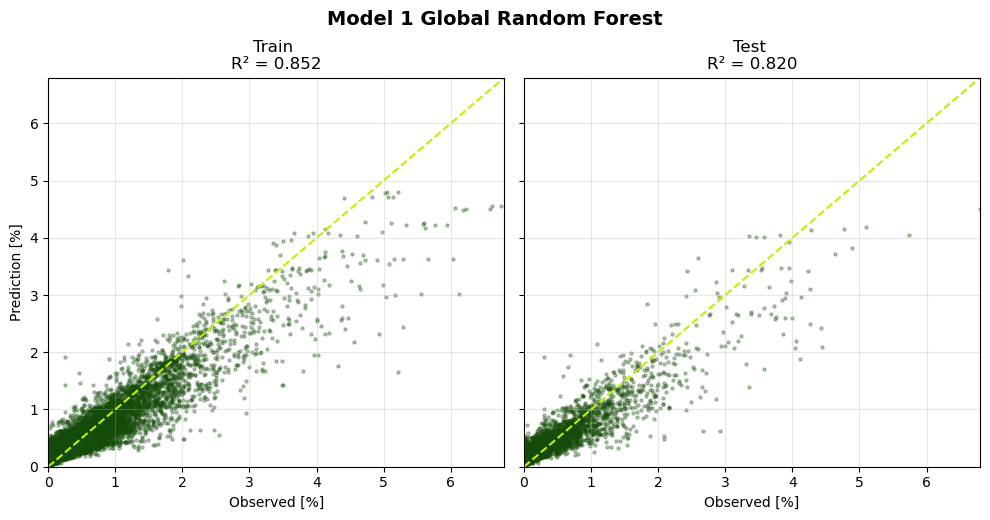

In [35]:
# Plot

lag_to_plot = 0
train_df = train_results[lag_to_plot]
test_df  = test_results[lag_to_plot]
r2_rf_train = r2_score(train_df['y_true'], train_df['rf_predicted'])
r2_rf_test  = r2_score(test_df['y_true'], test_df['rf_predicted'])

max_val = max(
    train_df['rf_predicted'].max(), train_df['y_true'].max(),
    test_df['rf_predicted'].max(), test_df['y_true'].max()
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
axs[0].plot([0, max_val], [0, max_val], linestyle='dashed', color='#bff102ff')
axs[0].scatter(train_df['y_true'], train_df['rf_predicted'], color='#144a08', s=5, alpha=0.3)
axs[0].set_title(f"Train \nR² = {r2_rf_train:.3f}")
axs[0].set_xlabel("Observed [%]")
axs[0].set_ylabel("Prediction [%]")
axs[0].set_xlim(0, max_val)
axs[0].set_ylim(0, max_val)
axs[0].grid(True, alpha=0.3)

fig.patch.set_alpha(0.0)
for ax in axs:
    ax.set_facecolor("none")

axs[1].plot([0, max_val], [0, max_val], linestyle='dashed', color='#bff102ff')
axs[1].scatter(test_df['y_true'], test_df['rf_predicted'], color='#144a08', s=5, alpha=0.3)
axs[1].set_title(f"Test \nR² = {r2_rf_test:.3f}")
axs[1].set_xlabel("Observed [%]")
axs[1].set_xlim(0, max_val)
axs[1].set_ylim(0, max_val)
axs[1].grid(True, alpha=0.3)

fig.tight_layout()
fig.suptitle("Model 1 Global Random Forest", fontsize=14, fontweight='bold', y=1.03)

plt.show()

In [36]:

metrics_df = pd.DataFrame(metrics_records)
# You can define the file name (customize as needed)
csv_name = "rf_metrics_model1_by_lag_sept10.csv"

# Join them for the full file path
output_file = os.path.join(output_path, csv_name)

# Save as normal
metrics_df.to_csv(output_file, index=False)
print(f"Saved metrics to {output_file}")


Saved metrics to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/rf_metrics_model1_by_lag_sept10.csv


In [37]:
# Show results for all lag steps
print("\nLagged Random Forest model results (test set):")
print(metrics_df[["lag", "r2_test", "rmse_test", "mae_test"]].to_string(index=False))



Lagged Random Forest model results (test set):
 lag  r2_test  rmse_test  mae_test
   0 0.819956   0.261539  0.156978
   1 0.817300   0.263460  0.157104
   2 0.816210   0.264246  0.156998
   3 0.815817   0.264528  0.156757
   4 0.815802   0.264538  0.156498


In [38]:
# Show results for all lag steps
print("\nLagged Random Forest model results (train set):")
print(metrics_df[["lag", "r2_train", "rmse_train", "mae_train"]].to_string(index=False))


Lagged Random Forest model results (train set):
 lag  r2_train  rmse_train  mae_train
   0  0.852236    0.235706   0.140060
   1  0.853811    0.234447   0.139327
   2  0.854896    0.233575   0.138703
   3  0.855925    0.232745   0.138039
   4  0.856851    0.231997   0.137423


### SHAP Plotting for Random Forest Model
How SHAP (SHapley Additive exPlanations) values and plots help to visualise feature importance:
- **Summary Plot:** This helps you see which features are most important globally. For example, elevation might not be the strongest predictor for deforestation rates.
- **Dependence Plot:** This reveals how changes in individual features (like forest coverage) impact the model’s predictions. You’ll see how sensitive the model is to certain features.
- **Force Plot & Waterfall Plot:** These plots let you explain individual predictions. For instance, you can explain why a particular deforestation rate was predicted based on the jurisdictions covariates.

**Key insight:** By using these plots, you gain both global and local interpretability — you understand how the model behaves overall, and you can explain specific predictions when needed. This is invaluable when you need to justify the model’s decisions to stakeholders or regulators.

Tutorial for calculating/plotting SHAP values for RF model found [here](https://medium.com/biased-algorithms/shap-values-for-random-forest-1150577563c9).

In [39]:
for name in models:
    print(name)


rf_model_1_lag0
rf_model_1_lag1
rf_model_1_lag2
rf_model_1_lag3
rf_model_1_lag4


In [40]:
rf_model_1_lag3 = models["rf_model_1_lag0"]


In [41]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model_1_lag3)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test, approximate=True)
# shap_values = explainer(X_test, approximate=True)

# List the variable names, and their longer descriptions
var_names = ['plantnPct','elevation','ppt','pd','road_density','rural_pop_pct','area_mn','temp','forAreaPct','ed','popden_km2','slope','gdp_pc_ppp','hdi','miningPct','nl','biome']
var_labels = ['Tree Plantation','Elevation','Precipitation','Patch Dens.','Road Dens.','Rural Pop.','Av. Patch Size','Temperature','Forest Area','Edge Dens.','Pop. Dens.','Slope','GDP','HDI','Mining Area','NL Intensity', 'Continent']

### Summary Plot
A summary SHAP plot displays how each input variable (e.g. forest coverage or population density) influences the output of each deforestation rate prediction.

/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/2257254442.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False, cmap=my_cmap)


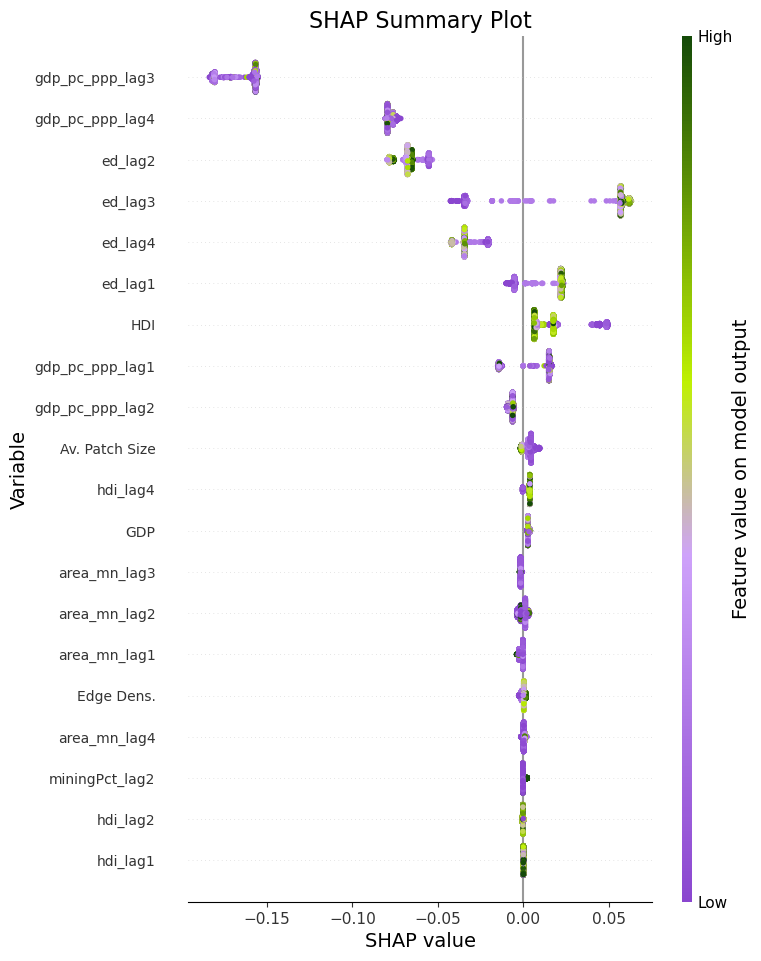

In [42]:
# Define a new colourmap using Sylvera colours
my_cmap = colors.LinearSegmentedColormap.from_list('my_gradient', (
    (0.0, colors.to_rgb(dark_purple)),
    (0.4, colors.to_rgb(bright_purple)),
    (0.6, colors.to_rgb(bright_green)),
    (1.0, colors.to_rgb(dark_green))
))

# Generate the SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False, cmap=my_cmap)

# Add a title, rename axis and tick labels, and change colours
plt.title("SHAP Summary Plot", fontsize=16)
plt.ylabel("Variable", fontsize=14)
plt.xlabel("SHAP value", fontsize=14)

# Robust y-tick relabeling
yticks = [item.get_text() for item in plt.gca().get_yticklabels()]
# Try to map to var_labels, fallback to name if not found
new_yticks = [
    var_labels[var_names.index(item)] if item in var_names else item
    for item in yticks
]
plt.yticks(plt.gca().get_yticks(), new_yticks, fontsize=10)

# Optional: Update colorbar label if present
if len(plt.gcf().axes) > 1:
    cf = plt.gcf().axes[-1]
    cf.set_ylabel('Feature value on model output', fontsize=14)

plt.show()


### Variable Dependence Plot

A SHAP dependence plot shows how the SHAP value (the influence on the model output compared to if that variable was not used) changes with the value of the input variable. For example, do only large forest area percentages heavily influence the predicted deforestation rates. Dependence plots can also be plotted with a colour-map to another variable (in this case the most dependent) to see which ones, when paired, influence the model output the most.

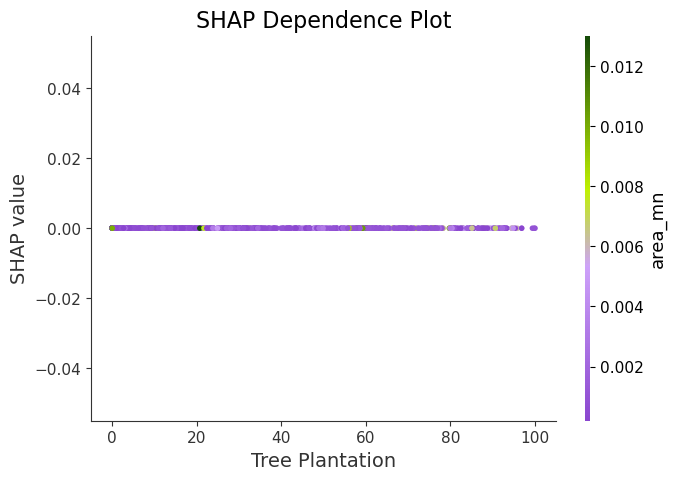

In [43]:
# Choose the variable to look for dependencies
variable_name = 'plantnPct'

# Fallback to variable_name if no label found
x_axis_label = var_labels[var_names.index(variable_name)] if variable_name in var_names else variable_name

# Generate the SHAP dependence plot
shap.dependence_plot(variable_name, shap_values, X_test, cmap=my_cmap, show=False)

plt.title("SHAP Dependence Plot", fontsize=16)
plt.ylabel("SHAP value", fontsize=14)
plt.xlabel(x_axis_label, fontsize=14)

# Y-axis label should just be "SHAP value" but if you want to set it with the label logic:
# (generally not necessary; SHAP values are generic)
# cf = plt.gcf().axes[-1]
# cf.set_ylabel(x_axis_label)

plt.show()


### Force Plot

A force plot shows how much each varaible contributes to a single prediction, f(x). The base value is the model prediction were none of the input variable to be used. The values quoted next to the variable names have been normalised to the min-max of each variable in the testing dataset to give an indication of their relative magnitude.

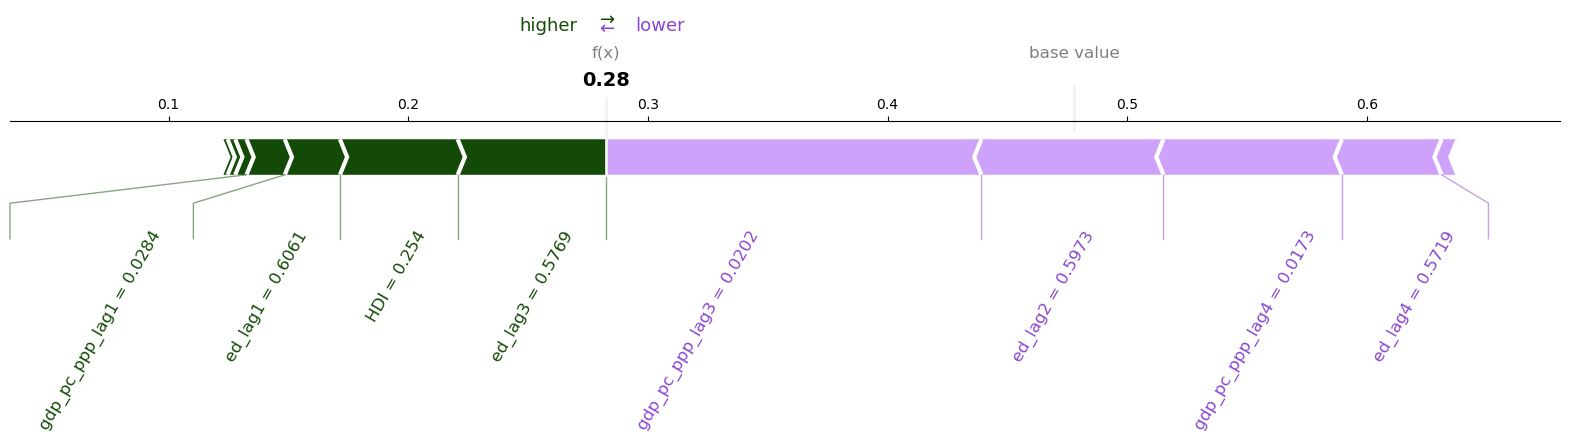

In [44]:
# Normalise the test data between 0 and 1 for each column
X_test_norm = X_test.copy()
for col in X_test_norm.columns:
    X_test_norm[col] = (X_test_norm[col] - X_test_norm[col].min()) / (X_test_norm[col].max() - X_test_norm[col].min())

# Get the full names of the variables, fallback to the column name if not found
feature_fullnames = []
for col in X_test_norm.columns:
    if col in var_names:
        feature_fullnames.append(var_labels[var_names.index(col)])
    else:
        feature_fullnames.append(col)

# Generate a SHAP force plot for an individual prediction
shap.plots.force(
    explainer.expected_value,
    shap_values[0, :],
    X_test_norm.iloc[0].round(4),
    feature_names=feature_fullnames,
    matplotlib=True,
    show=False,
    plot_cmap='GnPR',
    text_rotation=60
)

# Change the colormap
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, patches.Polygon)):
            if (colors.to_hex(fcc.get_facecolor()) == "#ff0d57"):
                fcc.set_color(dark_green)
            elif (colors.to_hex(fcc.get_facecolor()) == "#1e88e5"):
                fcc.set_color(bright_purple)
            else:
                fcc.set_color('#ffffff')
        elif (isinstance(fcc, plt.Text)):
            if (colors.to_hex(fcc.get_color()) == "#ff0d57"):
                fcc.set_color(dark_green)
            elif (colors.to_hex(fcc.get_color()) == "#1e88e5"):
                fcc.set_color(dark_purple)
        elif (isinstance(fcc, plt.Line2D)):
            if (colors.to_hex(fcc.get_color()) == "#ff0d57"):
                fcc.set_color(dark_green)
            elif (colors.to_hex(fcc.get_color()) == "#1e88e5"):
                fcc.set_color(dark_purple)
        elif (isinstance(fcc, image.AxesImage)):
            fcc.set_visible(False)
plt.show()


### Waterfall Plot

A waterfall plot shows how each individual variable stacks up to lead to the final model predictions, **f(x)**.

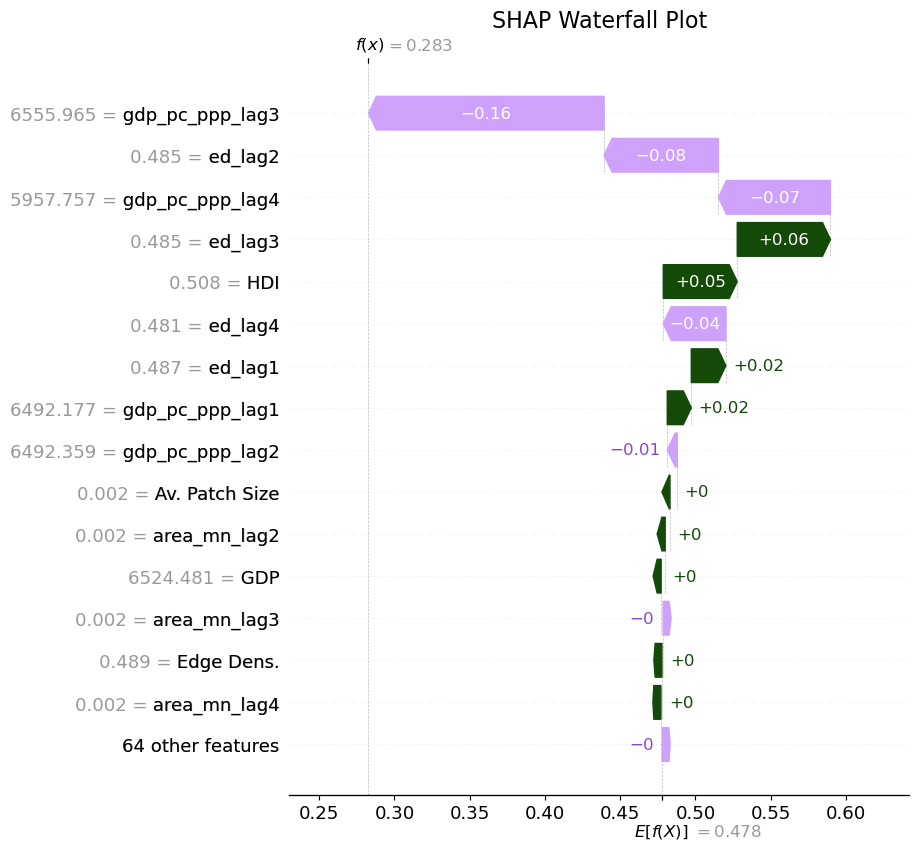

In [45]:
# Define an Explanation object
sv = explainer(X_test, approximate=True)
exp = shap.Explanation(sv.values, sv.base_values, data=X_test.values, feature_names=X_test.columns)

# Robust variable label mapping (same as force plot)
feature_fullnames = []
for col in X_test.columns:
    if col in var_names:
        feature_fullnames.append(var_labels[var_names.index(col)])
    else:
        feature_fullnames.append(col)

# Update the exp object to use the full names for features
exp.feature_names = feature_fullnames

# Generate a SHAP waterfall plot for an individual prediction
fig = plt.figure()
shap.plots.waterfall(exp[1], max_display=16, show=False)
plt.title("SHAP Waterfall Plot", fontsize=16)

# Change the colormap (optional: customize as needed)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, patches.FancyArrow)):
            if (colors.to_hex(fcc.get_facecolor()) == "#ff0051"):
                fcc.set_color(dark_green)
            elif (colors.to_hex(fcc.get_facecolor()) == "#008bfb"):
                fcc.set_color(bright_purple)
        elif (isinstance(fcc, plt.Text)):
            if (colors.to_hex(fcc.get_color()) == "#ff0051"):
                fcc.set_color(dark_green)
            elif (colors.to_hex(fcc.get_color()) == "#008bfb"):
                fcc.set_color(dark_purple)
plt.show()


### Model 1 Sensitivity Analysis

See the section in Model 2 sharing the same name for more information.

**Note:** this cell will take ~2 mins per iteration, so ~1 hour for 30 iterations.

In [51]:
# Re-run data split for lag 3, using the same function/params
X_train, X_test, y_train, y_test, predictor_vars, model_1_data = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2001, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,        
    max_lag=max_lag,
    use_lag=3,            # <<< lag 3
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)


model_1_data = model_1_data[predictor_vars + [TARGET]].dropna()


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (18814, 65) | Test shape: (4704, 65)


#### Warning: this block takes ~1hr to run sensitivty analysis, and is not needed for downstream calcs

In [67]:
# === Get the full input DataFrame for Model 1, lag 3 ===
_, _, _, _, predictor_vars, model_1_data = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2001, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,        # Or 'deforRate' if that's your column name
    max_lag=max_lag,
    use_lag=3,            # LAG 3!
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)
model_1_data = model_1_data[predictor_vars + [TARGET, 'biome']].dropna()  # Make sure 'biome' exists if using for stratification

# Define the fraction of input data that should be used for this analysis
subset = 0.5

# Take a subset of the input data (for runtime reasons)
model_1_subset_df = model_1_data.sample(frac=subset, random_state=42).copy()

# Define the number of iterations for the sensitivity analysis
n_iter_model_1 = 10

# Open empty arrays to calculate metrics
mae_model_1 = np.empty((2, n_iter_model_1))
rmse_model_1 = np.empty((2, n_iter_model_1))
r2_model_1 = np.empty((2, n_iter_model_1))

# Define the progress bar
pbar = tqdm(total=n_iter_model_1, leave=False)

# Loop over a range of random number generators
for i in range(n_iter_model_1):

    # Random 80/20 split, stratified by biome (if present)
    train_df_model_1, test_df_model_1 = train_test_split(
        model_1_subset_df, 
        test_size=0.2, 
        random_state=i+1, 
        stratify=model_1_subset_df['biome'] if 'biome' in model_1_subset_df.columns else None
    )

    # Prepare features and target
    X_train_model_1 = train_df_model_1[predictor_vars]
    y_train_model_1 = train_df_model_1[TARGET]
    X_test_model_1 = test_df_model_1[predictor_vars]
    y_test_model_1 = test_df_model_1[TARGET]

    # Define the Random Forest Model
    rf_sens_model_1 = RandomForestRegressor(
        n_estimators=1000,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=i+1
    )

    # Fit the RF model on the training data
    rf_sens_model_1.fit(X_train_model_1, y_train_model_1)

    # Evaluate the model on the training data
    pred_train_model_1 = rf_sens_model_1.predict(X_train_model_1)

    # Evaluate the model on the testing data
    pred_test_model_1 = rf_sens_model_1.predict(X_test_model_1)

    # Store the training metrics
    mae_model_1[0, i] = mean_absolute_error(y_train_model_1, pred_train_model_1)
    rmse_model_1[0, i] = np.sqrt(mean_squared_error(y_train_model_1, pred_train_model_1))
    r2_model_1[0, i] = r2_score(y_train_model_1, pred_train_model_1)

    # Store the testing metrics
    mae_model_1[1, i] = mean_absolute_error(y_test_model_1, pred_test_model_1)
    rmse_model_1[1, i] = np.sqrt(mean_squared_error(y_test_model_1, pred_test_model_1))
    r2_model_1[1, i] = r2_score(y_test_model_1, pred_test_model_1)

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (18814, 65) | Test shape: (4704, 65)


In [69]:
import numpy as np
from matplotlib.patches import Ellipse

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor="none", edgecolor="black", **kwargs):
    """
    Draw a covariance confidence ellipse of *x* and *y* on *ax*.
    n_std is the number of standard deviations.
    """
    x = np.asarray(x); y = np.asarray(y)
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    if np.any(~np.isfinite(cov)):
        return None  # nothing to draw (all-NaN, etc.)

    # Eigen-decomposition of covariance -> ellipse axes
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Angle of ellipse (in degrees)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width/height are 2*n_std*sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(vals)

    # Center at the means
    mean_x, mean_y = np.mean(x), np.mean(y)
    ell = Ellipse((mean_x, mean_y), width, height, angle=theta,
                  facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ell)
    return ell


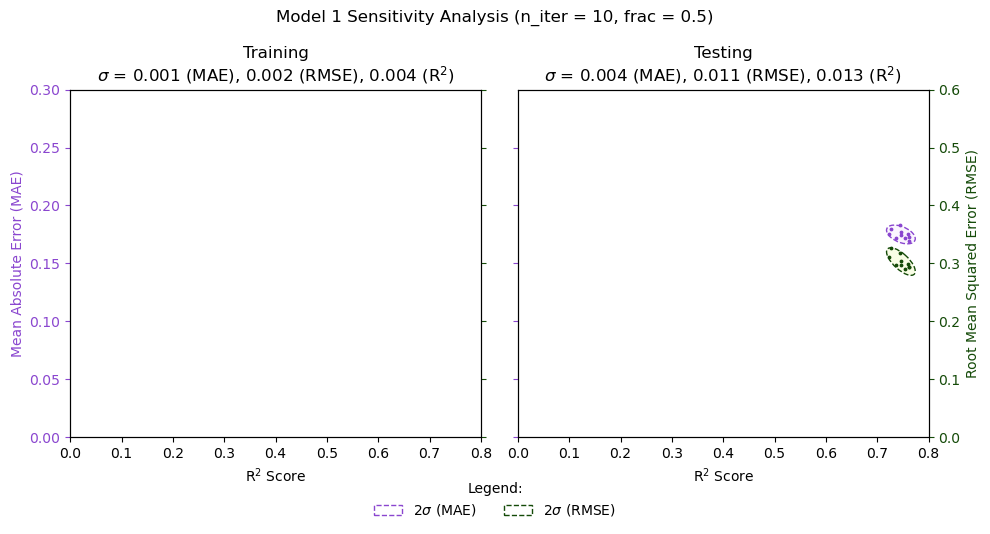

In [70]:
# Define the number of standard deviations to plot the ellipse with
n_std = 2

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Training

# MAE vs R2
confidence_ellipse(r2_model_1[0, :], mae_model_1[0, :], ax1, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_purple)
confidence_ellipse(r2_model_1[0, :], mae_model_1[0, :], ax1, n_std=n_std, edgecolor=dark_purple, linestyle='dashed', label=str(n_std) + r'$\sigma$ (MAE)')
ax1.scatter(r2_model_1[0, :], mae_model_1[0, :], s=3, color=dark_purple)
ax1.set_title("Training\n" + rf"$\sigma$ = {np.std(mae_model_1[0, :]):0.3f} (MAE), {np.std(rmse_model_1[0, :]):0.3f} (RMSE), {np.std(r2_model_1[0, :]):0.3f} (R$^2$)")
ax1.tick_params(axis='y', colors=dark_purple)
ax1.set_ylim(0, 0.3)
ax1.set_xlim(0, 0.8)
ax1.set_ylabel('Mean Absolute Error (MAE)', color=dark_purple)
ax1.set_xlabel(r"R$^2$ Score")

# RMSE vs R2
ax1twin = ax1.twinx()
confidence_ellipse(r2_model_1[0, :], rmse_model_1[0, :], ax1twin, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_green)
confidence_ellipse(r2_model_1[0, :], rmse_model_1[0, :], ax1twin, n_std=n_std, edgecolor=dark_green, linestyle='dashed', label=str(n_std) + r'$\sigma$ (RMSE)')
ax1twin.scatter(r2_model_1[0, :], rmse_model_1[0, :], s=3, color=dark_green)
ax1twin.set_yticks(np.arange(0, 0.7, 0.1), labels=['' for i in range(np.arange(0, 0.7, 0.1).size)])
ax1twin.tick_params(axis='y', colors=dark_green)

# Testing

# MAE vs R2
confidence_ellipse(r2_model_1[1, :], mae_model_1[1, :], ax2, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_purple)
confidence_ellipse(r2_model_1[1, :], mae_model_1[1, :], ax2, n_std=n_std, edgecolor=dark_purple, linestyle='dashed')
ax2.scatter(r2_model_1[1, :], mae_model_1[1, :], s=3, color=dark_purple)
ax2.set_title("Testing\n" + rf"$\sigma$ = {np.std(mae_model_1[1, :]):0.3f} (MAE), {np.std(rmse_model_1[1, :]):0.3f} (RMSE), {np.std(r2_model_1[1, :]):0.3f} (R$^2$)")
ax2.set_yticks(np.arange(0, 0.3, 0.05), labels=['' for i in range(np.arange(0, 0.3, 0.05).size)])
ax2.tick_params(axis='y', colors=dark_purple)
ax2.set_ylim(0, 0.3)
ax2.set_xlim(0, 0.8)
ax2.set_xlabel(r"R$^2$ Score")

# RMSE vs R2
ax2twin = ax2.twinx()
confidence_ellipse(r2_model_1[1, :], rmse_model_1[1, :], ax2twin, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_green)
confidence_ellipse(r2_model_1[1, :], rmse_model_1[1, :], ax2twin, n_std=n_std, edgecolor=dark_green, linestyle='dashed')
ax2twin.scatter(r2_model_1[1, :], rmse_model_1[1, :], s=3, color=dark_green)
ax2twin.tick_params(axis='y', colors=dark_green)
ax2twin.set_ylim(0, 0.6)
ax2twin.set_ylabel('Root Mean Squared Error (RMSE)', color=dark_green)

fig.suptitle(f"Model 1 Sensitivity Analysis (n_iter = {n_iter_model_1}, frac = {subset})")
fig.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0), frameon=False, title=r"Legend:")
fig.tight_layout()
fig.savefig(os.path.join(output_path, f"Model_1_RF_sensitivity_analysis.png"), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Other Model Validation

In [46]:
# For a given lag:
lag_to_eval = 2  # Or whatever lag you want

test_df = test_results[lag_to_eval].copy()

# If your target column is named y_true (from the storage above), rename for compatibility:
if 'deforRate' not in test_df.columns and 'y_true' in test_df.columns:
    test_df['deforRate'] = test_df['y_true']

# Add your thresholds
within_0_05pct  = np.mean(np.abs(test_df['deforRate'] - test_df['rf_predicted']) <= 0.05) * 100
within_0_1pct   = np.mean(np.abs(test_df['deforRate'] - test_df['rf_predicted']) <= 0.1) * 100
within_0_001pct = np.mean(np.abs(test_df['deforRate'] - test_df['rf_predicted']) <= 0.01) * 100
within_1_pct    = np.mean(np.abs(test_df['deforRate'] - test_df['rf_predicted']) <= 1.0) * 100

# Relative error for low-deforestation cases
hfld_subset = test_df[test_df['deforRate'] <= 1.0]  # Focus on low-defor cases
relative_errors = np.abs(hfld_subset['deforRate'] - hfld_subset['rf_predicted']) / (hfld_subset['deforRate'] + 0.01)
median_relative_error = np.median(relative_errors)

print(f"Within ±0.1%:   {within_0_1pct:.1f}% of predictions")
print(f"Within ±0.05%:  {within_0_05pct:.1f}% of predictions")
print(f"Within ±0.001%: {within_0_001pct:.1f}% of predictions")
print(f"Within ±1%:     {within_1_pct:.1f}% of predictions")


Within ±0.1%:   52.2% of predictions
Within ±0.05%:  28.7% of predictions
Within ±0.001%: 6.4% of predictions
Within ±1%:     98.8% of predictions


### Exporting Predictions for 2002 to 2020

In [52]:
model_1_data.head()

,area_mn,area_mn_lag1,area_mn_lag2,area_mn_lag3,ed,ed_lag1,ed_lag2,ed_lag3,gdp_pc_ppp,gdp_pc_ppp_lag1,...,elevation,slope,biome_Africa,biome_Asia,biome_Central America,biome_Europe,biome_North America,biome_Oceania,biome_South America,deforRate_5yr
70,0.001565,0.001407,0.001402,0.001393,0.471019,0.472173,0.473212,0.474366,3775.235352,3528.035645,...,237.511647,0.70623,1,0,0,0,0,0,0,0.299250
71,0.001561,0.001565,0.001407,0.001402,0.472601,0.471019,0.472173,0.473212,4310.755859,3775.235352,...,237.511647,0.70623,1,0,0,0,0,0,0,0.250838
72,0.001565,0.001561,0.001565,0.001407,0.473885,0.472601,0.471019,0.472173,5028.169434,4310.755859,...,237.511647,0.70623,1,0,0,0,0,0,0,0.124130
73,0.001559,0.001565,0.001561,0.001565,0.481085,0.473885,0.472601,0.471019,5957.757324,5028.169434,...,237.511647,0.70623,1,0,0,0,0,0,0,0.154172
74,0.001562,0.001559,0.001565,0.001561,0.484528,0.481085,0.473885,0.472601,6555.964844,5957.757324,...,237.511647,0.70623,1,0,0,0,0,0,0,0.165819


In [53]:
# --- CHOOSE WHICH LAG TO EXPORT PREDICTIONS FOR ---
lag = 0  # <--- Change this to 0, 1, 2, 3, or 4 as needed

model_name = f"rf_model_1_lag{lag}"
rf_model_1 = models[model_name]

# Get correct predictors and data for this lag
X_train, X_test, y_train, y_test, predictor_vars, model_1_data = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2005, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)


In [54]:
# --- CHOOSE LAG STEP FOR EXPORT ---
lag = 0  # Change as needed (0, 1, 2, 3, 4...)

# --- Get Model and Data for this Lag ---
model_name = f"rf_model_1_lag{lag}"
rf_model = models[model_name]
X_train, X_test, y_train, y_test, predictor_vars, model_1_data = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2005, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)

# --- Generate predictions for all available data for this lag ---
X_full = model_1_data[predictor_vars]
model_1_data = model_1_data.copy()
model_1_data[f"rf_predicted_model1_lag{lag}"] = rf_model.predict(X_full)

# --- Export to CSV with explicit lag in filename and columns ---
cols = ["admin", "name", "year", f"rf_predicted_model1_lag{lag}"]
if "deforRate_5yr" in model_1_data.columns:
    cols.insert(3, "deforRate_5yr")  # include target if present

predictions_export = model_1_data[cols].copy()
out_csv = os.path.join(output_path, f"Model_1_RF_predictions_2001_2020_lag{lag}.csv")
predictions_export.to_csv(out_csv, index=False)

print(f"Exported {len(predictions_export)} RF predictions for lag {lag} ({predictions_export['year'].nunique()} years) to {out_csv}")

# --- Attach to plotting_df if it exists, with explicit lag column ---
if "plotting_df" in globals():
    rf_colname = f"rf_predicted_model1_lag{lag}"
    pred_for_merge = predictions_export[["admin", "name", "year", rf_colname]]
    if rf_colname in plotting_df.columns:
        plotting_df = plotting_df.drop(columns=[rf_colname])
    plotting_df = plotting_df.merge(pred_for_merge, on=["admin", "name", "year"], how="left")


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)
Exported 22156 RF predictions for lag 0 (16 years) to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/Model_1_RF_predictions_2001_2020_lag0.csv


In [55]:
# --- CHOOSE LAG STEP FOR EXPORT ---
lag = 0  # Change as needed (0, 1, 2, 3, 4...)

# --- Get Model and Data for this Lag ---
model_name = f"rf_model_1_lag{lag}"
rf_model = models[model_name]
X_train, X_test, y_train, y_test, predictor_vars, model_1_data = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2005, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)

# --- Generate predictions for all available data for this lag ---
X_full = model_1_data[predictor_vars]
model_1_data = model_1_data.copy()

# --- Use a standard column name, regardless of lag ---
model_1_data["Model_1"] = rf_model.predict(X_full)

# --- Export to CSV with explicit lag in filename, but column stays the same ---
cols = ["admin", "name", "year", "Model_1"]
if "deforRate_5yr" in model_1_data.columns:
    cols.insert(3, "deforRate_5yr")  # include target if present

predictions_export = model_1_data[cols].copy()
out_csv = os.path.join(output_path, f"Model_1_RF_predictions_2001_2020_lag{lag}.csv")
predictions_export.to_csv(out_csv, index=False)

print(f"Exported {len(predictions_export)} RF predictions for lag {lag} ({predictions_export['year'].nunique()} years) to {out_csv}")

# --- Attach to plotting_df if it exists, always merging on 'Model_1' ---
if "plotting_df" in globals():
    pred_for_merge = predictions_export[["admin", "name", "year", "Model_1"]]
    # Drop any old columns with this standard name
    if "Model_1" in plotting_df.columns:
        plotting_df = plotting_df.drop(columns=["Model_1"])
    plotting_df = plotting_df.merge(pred_for_merge, on=["admin", "name", "year"], how="left")


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)
Exported 22156 RF predictions for lag 0 (16 years) to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/Model_1_RF_predictions_2001_2020_lag0.csv


# Model 2: Logistic Regression + Random Forest Regression

In [56]:
merged_df

,admin,name,year,Area,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,HFLD_full_condition,biome,forAreaPct,biome_Africa,biome_Asia,biome_Central America,biome_Europe,biome_North America,biome_Oceania,biome_South America
0,Albania,Albania,1992,28361.8,0.000245,0.374436,693.490582,3073.560438,0.607197,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,Albania,Albania,1993,28361.8,0.000245,0.374436,693.490582,3360.358440,0.611965,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,Albania,Albania,1994,28361.8,0.000245,0.374436,693.490582,3655.453130,0.619839,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,Albania,Albania,1995,28361.8,0.000239,0.372376,693.490582,4156.492974,0.631560,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,Albania,Albania,1996,28361.8,0.000242,0.372481,693.490582,4551.715920,0.640382,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81572,Zimbabwe,Zimbabwe,2016,391404.0,0.000436,0.369610,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81573,Zimbabwe,Zimbabwe,2017,391404.0,0.000420,0.374947,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81574,Zimbabwe,Zimbabwe,2018,391404.0,0.000417,0.377261,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0
81575,Zimbabwe,Zimbabwe,2019,391404.0,0.000409,0.380300,971.101556,1785.788076,0.516276,0.000001,...,NaN,NaN,NaN,0,0,0,0,0,0,0


### Core lag function - set columns to skip for lag in skip_cols, currently skipped cols are static values

In [57]:
ID_COLS   = ["admin", "name", "year"]
LEAKY_COLS = ["HFLD_score", "HFLD", "HFLD_full_condition", "deforRate", "deforRate_5yr", "biome"]
max_lag = 4

skip_cols = biome_dummies + ['slope'] + ['elevation'] +['biome'] #+ ['forAreaPct']# change as needed 

In [58]:
def build_model_dataset_cumulative_lags(
    df: pd.DataFrame,
    year_min: int = 2001,
    year_max: int = 2020,
    drop_cols: Iterable[str] = ("Area",),
    target: str = TARGET,
    max_lag: int = 4,   # set this to your maximum lag
    use_lag: int = 0,   # set 0, 1, ..., max_lag as you step through
    skip_cols: Iterable[str] = (),
    test_size: float = 0.2,
    random_state: int = 42,
    stratify: Optional[str] = None
):
    # 0) Start clean and sorted
    model_df = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
    model_df = model_df.sort_values(["admin", "name", "year"])

    # 1) Decide which numeric columns to lag (exclude IDs, leaky, target, skip_cols)
    exclude = set(ID_COLS + LEAKY_COLS + [target]) | set(skip_cols)
    numeric_cols = model_df.select_dtypes(include="number").columns.tolist()
    cols_to_lag = [c for c in numeric_cols if c not in exclude]

    # 2) Add lagged columns (does NOT overwrite, just adds new ones)
    model_df = add_lagged_columns(model_df, cols_to_lag, max_lag)

    # 3) Filter by modeling years
    model_df = model_df.query("(@year_min <= year) and (year <= @year_max)")

    # 4) Build predictor list: for each lag, include all lags up to use_lag for each variable to lag
    predictor_vars = []
    for col in cols_to_lag:
        predictor_vars.append(col)
        for lag in range(1, use_lag + 1):
            predictor_vars.append(f"{col}_lag{lag}")
    # Add other predictors (e.g., static vars, one-hot dummies)
    all_other_predictors = [
        c for c in model_df.columns
        if c not in set(ID_COLS + LEAKY_COLS + [target] + cols_to_lag +
                        [f"{col}_lag{l}" for col in cols_to_lag for l in range(1, max_lag+1)])
    ]
    print("Cols to lag:", cols_to_lag)

    predictor_vars += all_other_predictors

    # 5) Drop remaining NA in target or predictors
    model_df = model_df.dropna(subset=predictor_vars + [target])

    # 6) Train-test split
    stratify_series = model_df[stratify] if isinstance(stratify, str) else None
    train_df, test_df = train_test_split(
        model_df, test_size=test_size, random_state=random_state, stratify=stratify_series
    )
    X_train = train_df[predictor_vars]
    y_train = train_df[target]
    X_test  = test_df[predictor_vars]
    y_test  = test_df[target]

    print(f"Target: {target} | Lags included: {use_lag} | Predictors: {len(predictor_vars)}")
    print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

    return X_train, X_test, y_train, y_test, predictor_vars, model_df


In [59]:
# lagged data -
_Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2001, year_max=2020,  # (leave as-is to build all lags for all years)
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)

# Identify HFLD as of 2005 
is_2005 = lagged_df["year"] == 2005
hfld_in_2005 = lagged_df.loc[is_2005 & (lagged_df["HFLD_full_condition"] == 1), ["admin", "name"]].drop_duplicates()

# Filter lagged_df to these admin-name combos, for years >= 2005 only 
hfld_keys = set(map(tuple, hfld_in_2005[["admin", "name"]].to_numpy()))
lagged_df = lagged_df[lagged_df.apply(lambda row: (row["admin"], row["name"]) in hfld_keys, axis=1)]
lagged_df = lagged_df[lagged_df["year"] >= 2005]

# HFLD transition window logic 
start_year = 2005
end_year   = int(lagged_df["year"].max())
start_mask = lagged_df["year"].eq(start_year)
hfld_start = lagged_df.loc[start_mask & lagged_df["HFLD_full_condition"].eq(1.0), ["admin","name"]].drop_duplicates()
keys_start = set(map(tuple, hfld_start[["admin","name"]].to_numpy()))
keys_all   = list(map(tuple, lagged_df[["admin","name"]].to_numpy()))
mask_juris = np.array([k in keys_start for k in keys_all])
sub = lagged_df.loc[mask_juris, ["admin","name","year","HFLD_full_condition"]].copy()
g   = sub.groupby(["admin","name"], as_index=False)
left_hfld = g["HFLD_full_condition"].min().rename(columns={"HFLD_full_condition":"min_hfld"})
left_hfld["transition"] = (left_hfld["min_hfld"] < 1.0).astype(int)
left_hfld = left_hfld.drop(columns=["min_hfld"])
years_hfld = g["HFLD_full_condition"].sum().rename(columns={"HFLD_full_condition":"years_as_HFLD"})
HFLD_start_df = lagged_df.loc[start_mask].merge(hfld_start, on=["admin","name"], how="inner")
HFLD_start_df = HFLD_start_df.merge(left_hfld, on=["admin","name"], how="left")
HFLD_start_df = HFLD_start_df.merge(years_hfld,  on=["admin","name"], how="left")

valid_predictors = [c for c in predictor_vars
                    if (c in HFLD_start_df.columns) and (HFLD_start_df[c].dtype != "O")]
HFLD_start_df = HFLD_start_df.dropna(subset=valid_predictors + ["transition"])

X = HFLD_start_df[valid_predictors]
y = HFLD_start_df["transition"].astype(int)

# Train/test split - constant 
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() == 2 else None
)


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)


### For Step 1 (LR): Jurisdictions which have transitioned out of HFLD between 2002 to 2020

## SMOTE sci kit - not using


In [60]:
# threshold = 0.66
# USE_SMOTE = True

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
# )
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import pandas as pd
# import os

# max_lag_for_lr = 4
# sklearn_lr_models = {}          # Dict: lag (int) -> LogisticRegression model
# sklearn_lr_metrics = []         # List of metrics dicts, one per lag
# sklearn_X_test_dict = {}        # Dict lag (int) -> X_test (for hist plotting)
# sklearn_train_splits = {}
# sklearn_test_splits = {}

# # (Assume all label setup/inputs already done: see above...)

# for use_lag in range(0, max_lag_for_lr + 1):
#     _Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
#         merged_df,
#         year_min=hist_start, year_max=2020,
#         drop_cols=("Area",),
#         target=TARGET,
#         max_lag=max_lag_for_lr,
#         use_lag=use_lag,
#         test_size=0.2,
#         random_state=42,
#         stratify=None,
#         skip_cols=skip_cols
#     )

#     # Restrict to only complete-history keys for 2005
#     lagged_df = lagged_df[lagged_df.apply(lambda r: (r["admin"], r["name"]) in complete_keys, axis=1)]
#     df2005 = lagged_df.loc[lagged_df["year"] == 2005].copy()

#     avail_pred = [c for c in predictor_vars if c in df2005.columns]
#     numeric_pred = [c for c in avail_pred if pd.api.types.is_numeric_dtype(df2005[c])]

#     df2005 = (
#         df2005
#         .merge(labels_df,        on=["admin", "name"], how="inner")
#         .merge(years_hfld_global,on=["admin", "name"], how="left")
#         .dropna(subset=numeric_pred)
#     )

#     avg_years_hfld = float(df2005["years_as_HFLD"].mean()) if "years_as_HFLD" in df2005 else np.nan

#     # Fixed cohort split by keys
#     df_train = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in train_keys, axis=1)]
#     df_test  = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in test_keys,  axis=1)]

#     sklearn_train_splits[use_lag] = df_train[["admin", "name", "transition"]].reset_index(drop=True).copy()
#     sklearn_test_splits[use_lag]  = df_test[["admin", "name", "transition"]].reset_index(drop=True).copy()

#     X_train_lr = df_train[numeric_pred]
#     y_train_lr = df_train["transition"].astype(int)
#     X_test_lr  = df_test[numeric_pred]
#     y_test_lr  = df_test["transition"].astype(int)

#     # --- Store X_test per lag (for histogram plotting) ---
#     sklearn_X_test_dict[use_lag] = X_test_lr.copy()

#     # Optional SMOTE
#     if USE_SMOTE:
#         try:
#             sm = SMOTE(random_state=42)
#             X_train_lr_sm, y_train_lr_sm = sm.fit_resample(X_train_lr, y_train_lr)
#         except ValueError as e:
#             print(f"[lag {use_lag}] SMOTE skipped: {e}")
#             X_train_lr_sm, y_train_lr_sm = X_train_lr, y_train_lr
#     else:
#         X_train_lr_sm, y_train_lr_sm = X_train_lr, y_train_lr

#     # Fit
#     sk_lr = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", random_state=123)
#     sk_lr.fit(X_train_lr_sm, y_train_lr_sm)
#     sklearn_lr_models[use_lag] = sk_lr  # <--- just the lag as int!

#     # Probs/preds
#     y_prob_train = sk_lr.predict_proba(X_train_lr_sm)[:, 1]
#     y_pred_train = (y_prob_train >= threshold).astype(int)
#     y_prob_test  = sk_lr.predict_proba(X_test_lr)[:, 1]
#     y_pred_test  = (y_prob_test >= threshold).astype(int)

#     auc_train = roc_auc_score(y_train_lr_sm, y_prob_train)
#     auc_test  = roc_auc_score(y_test_lr,    y_prob_test)
#     acc_train = accuracy_score(y_train_lr_sm, y_pred_train)
#     acc_test  = accuracy_score(y_test_lr,     y_pred_test)
#     prec_train = precision_score(y_train_lr_sm, y_pred_train, zero_division=0)
#     prec_test  = precision_score(y_test_lr,     y_pred_test,  zero_division=0)
#     rec_train = recall_score(y_train_lr_sm, y_pred_train, zero_division=0)
#     rec_test  = recall_score(y_test_lr,     y_pred_test,  zero_division=0)
#     f1_train = f1_score(y_train_lr_sm, y_pred_train, zero_division=0)
#     f1_test  = f1_score(y_test_lr,     y_pred_test,  zero_division=0)
#     brier_train = brier_score_loss(y_train_lr_sm, y_prob_train)
#     brier_test  = brier_score_loss(y_test_lr,     y_prob_test)

#     sklearn_lr_metrics.append({
#         "lag": use_lag,
#         "model_name": f"sklearn_lr_model_lag{use_lag}",
#         "n_predictors": len(numeric_pred),
#         "n_train": int(len(y_train_lr)),
#         "n_test": int(len(y_test_lr)),
#         "train_pos": int(y_train_lr.sum()),
#         "test_pos": int(y_test_lr.sum()),
#         "auc_train": auc_train, "auc_test": auc_test,
#         "accuracy_train": acc_train, "accuracy_test": acc_test,
#         "precision_train": prec_train, "precision_test": prec_test,
#         "recall_train": rec_train, "recall_test": rec_test,
#         "f1_train": f1_train, "f1_test": f1_test,
#         "brier_train": brier_train, "brier_test": brier_test,
#         "avg_years_as_HFLD": avg_years_hfld,
#         "threshold": threshold,
#         "start_year": 2005,
#         "end_year": int(lagged_df["year"].max()),
#     })

# # Save
# sklearn_lr_metrics_df = pd.DataFrame(sklearn_lr_metrics).sort_values("lag")
# csv_name = "sklearn_lr_metrics_model2_by_lag.csv"
# output_file = os.path.join(output_path, csv_name)
# sklearn_lr_metrics_df.to_csv(output_file, index=False)
# print(f"Saved scikit-learn logistic regression metrics to {output_file}")

# print("\nLagged scikit-learn Logistic Regression results (train/test metrics + avg years as HFLD):")
# print(
#     sklearn_lr_metrics_df[
#         [
#             "lag",
#             "n_train", "n_test",
#             "train_pos", "test_pos",
#             "auc_test", "accuracy_test",
#             "precision_test", "recall_test",
#             "f1_test", "brier_test",
#             "avg_years_as_HFLD"
#         ]
#     ].to_string(index=False)
# )

# chosen_lag = 4
# mean_HFLD_years = sklearn_lr_metrics_df.loc[sklearn_lr_metrics_df["lag"] == chosen_lag, "avg_years_as_HFLD"].values[0]


In [ ]:
# import matplotlib.pyplot as plt

# prob_histories_sklearn = {}
# for lag, sk_lr in sklearn_lr_models.items():
#     X_test_lr = sklearn_X_test_dict[lag]
#     probs = sk_lr.predict_proba(X_test_lr)[:, 1]
#     prob_histories_sklearn[lag] = probs

# fig, axs = plt.subplots(1, len(prob_histories_sklearn), figsize=(4 * len(prob_histories_sklearn), 4), sharey=True)
# if len(prob_histories_sklearn) == 1:
#     axs = [axs]

# for i, lag in enumerate(sorted(prob_histories_sklearn)):
#     probs = prob_histories_sklearn[lag]
#     axs[i].hist(probs, bins=20, color="#d2691e", alpha=0.85)
#     axs[i].set_title(f"Lag {lag} (n={len(probs)})")  # <-- Add count here
#     axs[i].set_xlabel("Predicted Probability")
#     axs[i].set_ylabel("Count")
#     print(f"Lag {lag}: total predictions = {len(probs)}")  # <-- Also print to console

# plt.tight_layout()
# plt.show()


NameError: name 'sklearn_lr_models' is not defined

## GLM logistic regression with statistical inference

In [62]:

# === PARAMS 
max_lag_for_lr = 4  

# --- Step 1: Define cohort at 2005 ---
hfld_2005 = merged_df.loc[
    (merged_df["year"] == 2005) & (merged_df["HFLD_full_condition"] == 1.0),
    ["admin", "name"]
].drop_duplicates()
hfld_keys_2005 = set(map(tuple, hfld_2005[["admin", "name"]].to_numpy()))

# --- Step 2: Build transition labels (2005 onward, for eligible jurisdictions) ---
subset_2005_plus = merged_df.loc[
    merged_df["year"] >= 2005, ["admin", "name", "year", "HFLD_full_condition"]
]
subset_2005_plus = subset_2005_plus[
    subset_2005_plus.apply(lambda r: (r["admin"], r["name"]) in hfld_keys_2005, axis=1)
]
g = subset_2005_plus.groupby(["admin", "name"], as_index=False)
min_hfld = g["HFLD_full_condition"].min().rename(columns={"HFLD_full_condition": "min_hfld"})
labels_df = min_hfld.assign(transition=(min_hfld["min_hfld"] < 1.0).astype(int)).drop(columns=["min_hfld"])

# --- Step 3: Compute years as HFLD (2006–2020) ---
years_of_interest = list(range(2006, 2021))
subset_15yr = subset_2005_plus[subset_2005_plus["year"].isin(years_of_interest)]
g_15 = subset_15yr.groupby(["admin", "name"], as_index=False)
years_hfld_global = g_15["HFLD_full_condition"].sum().rename(columns={"HFLD_full_condition": "years_as_HFLD"})

# --- Step 4: Identify "complete-history" jurisdictions ---
hist_start = 2005 - max_lag_for_lr
_, _, _, _, predictor_vars_all, lagged_full = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=hist_start, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag_for_lr,
    use_lag=max_lag_for_lr,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)
lagged_full = lagged_full[lagged_full.apply(lambda r: (r["admin"], r["name"]) in hfld_keys_2005, axis=1)]
available_predictors_full = [c for c in predictor_vars_all if c in lagged_full.columns]
numeric_predictors_full = [c for c in available_predictors_full if pd.api.types.is_numeric_dtype(lagged_full[c])]
df2005_full = lagged_full.loc[lagged_full["year"] == 2005, ["admin", "name"] + numeric_predictors_full]
complete_keys = set(map(tuple, df2005_full.dropna(subset=numeric_predictors_full)[["admin", "name"]].to_numpy()))

# --- Step 5: Train/test split by jurisdiction ---
labels_complete = labels_df[labels_df.apply(lambda r: (r["admin"], r["name"]) in complete_keys, axis=1)]
juris_list = list(map(tuple, labels_complete[["admin", "name"]].to_numpy()))
y_labels   = labels_complete["transition"].to_numpy()
train_keys, test_keys = train_test_split(juris_list, test_size=0.2, random_state=42, stratify=y_labels)
train_keys, test_keys = set(train_keys), set(test_keys)




Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)


In [63]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
)

all_model_stats = []
all_coef_tables = []
prob_histories_glm = {}  # <-- put this at the top, before for use_lag in lags_to_run

lr_models = {}          # Dict of GLMResult objects, one per lag
glm_predictors = {}     # Dict of predictors+const for each lag
threshold = 0.66

lags_to_run = range(0, max_lag_for_lr + 1)
fixed_start_year = 2005
years_of_interest = list(range(2006, 2021))  # 15-year window

train_splits_glm = {}
test_splits_glm  = {}

for use_lag in lags_to_run:
    _Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
        merged_df,
        year_min=hist_start, year_max=2020,
        drop_cols=("Area",),
        target=TARGET,
        max_lag=max_lag_for_lr,
        use_lag=use_lag,
        test_size=0.2,
        random_state=42,
        stratify=None,
        skip_cols=skip_cols
    )
    lagged_df = lagged_df[lagged_df.apply(lambda r: (r["admin"], r["name"]) in complete_keys, axis=1)]
    df2005 = lagged_df.loc[lagged_df["year"] == 2005].copy()

    avail_pred   = [c for c in predictor_vars if c in df2005.columns]
    numeric_pred = [c for c in avail_pred if pd.api.types.is_numeric_dtype(df2005[c])]

    df2005 = (
        df2005
        .merge(labels_df,        on=["admin","name"], how="inner")
        .merge(years_hfld_global,on=["admin","name"], how="left")
        .dropna(subset=numeric_pred)
    )

    biome_cols_in = [c for c in biome_dummies if c in numeric_pred]
    biome_baseline = None
    if biome_cols_in:
        prevalence = {c: float(df2005[c].mean()) for c in biome_cols_in}
        biome_baseline = max(prevalence, key=prevalence.get)
        biome_keep = [c for c in biome_cols_in if c != biome_baseline]
        numeric_pred = [c for c in numeric_pred if c not in biome_cols_in] + biome_keep

    df2005 = df2005.dropna(subset=numeric_pred + ["transition"])
    if df2005.empty or df2005["transition"].nunique() < 2:
        print(f"[lag {use_lag}] Not enough variation in 'transition' after cleaning; skipping.")
        continue

    df_train = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in train_keys, axis=1)]
    df_test  = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in test_keys,  axis=1)]

    train_splits_glm[use_lag] = df_train[["admin", "name", "transition"]].reset_index(drop=True).copy()
    test_splits_glm[use_lag]  = df_test[["admin", "name", "transition"]].reset_index(drop=True).copy()

    X_train = df_train[numeric_pred].astype(float)
    y_train = df_train["transition"].astype(int)
    X_test  = df_test[numeric_pred].astype(float)
    y_test  = df_test["transition"].astype(int)

    # --- Track predictors used for this lag, including constant ---
    glm_predictors[use_lag] = ["const"] + list(numeric_pred)

    # Class-balance weights for inference
    class_counts = y_train.value_counts().to_dict()
    w_pos = len(y_train) / (2.0 * class_counts.get(1, 1))
    w_neg = len(y_train) / (2.0 * class_counts.get(0, 1))
    sample_weights = y_train.map({0: w_neg, 1: w_pos}).astype(float)

    X_train_const = sm.add_constant(X_train, has_constant="add")
    X_test_const  = sm.add_constant(X_test,  has_constant="add")

    try:
        glm_binom = sm.GLM(y_train, X_train_const, family=sm.families.Binomial(), 
                           #freq_weights=sample_weights # testing without class balance 
                           )
        res = glm_binom.fit()
        lr_models[f"lr_model_2_lag{use_lag}"] = res

        # Prediction
        p_train = res.predict(X_train_const).clip(1e-9, 1-1e-9)
        p_test  = res.predict(X_test_const).clip(1e-9, 1-1e-9)
        prob_histories_glm[use_lag] = p_test

        yhat_train = (p_train >= threshold).astype(int)
        yhat_test  = (p_test  >= threshold).astype(int)

        auc_train = roc_auc_score(y_train, p_train)
        auc_test  = roc_auc_score(y_test,  p_test)
        acc_train = accuracy_score(y_train, yhat_train)
        acc_test  = accuracy_score(y_test, yhat_test)
        prec_train = precision_score(y_train, yhat_train, zero_division=0)
        prec_test  = precision_score(y_test, yhat_test, zero_division=0)
        rec_train = recall_score(y_train, yhat_train, zero_division=0)
        rec_test  = recall_score(y_test, yhat_test, zero_division=0)
        f1_train = f1_score(y_train, yhat_train, zero_division=0)
        f1_test  = f1_score(y_test, yhat_test, zero_division=0)
        brier_train = brier_score_loss(y_train, p_train)
        brier_test  = brier_score_loss(y_test, p_test)

        model_stats = {
            "lag": use_lag,
            "nobs": int(res.nobs),
            "n_params": int(res.params.shape[0]),
            "aic": float(res.aic) if hasattr(res, "aic") else np.nan,
            "bic": float(res.bic) if hasattr(res, "bic") else np.nan,
            "llf": float(res.llf) if hasattr(res, "llf") else np.nan,
            "start_year": 2005,
            "end_year": int(lagged_df["year"].max()),
            "biome_baseline": biome_baseline,
            "n_train": int(len(y_train)),
            "n_test": int(len(y_test)),
            "train_pos": int(y_train.sum()),
            "test_pos": int(y_test.sum()),
            "auc_train": auc_train, "auc_test": auc_test,
            "accuracy_train": acc_train, "accuracy_test": acc_test,
            "precision_train": prec_train, "precision_test": prec_test,
            "recall_train": rec_train, "recall_test": rec_test,
            "f1_train": f1_train, "f1_test": f1_test,
            "brier_train": brier_train, "brier_test": brier_test,
            "avg_years_as_HFLD": float(df2005["years_as_HFLD"].mean()) if "years_as_HFLD" in df2005 else np.nan,
        }
        all_model_stats.append(model_stats)

        coef_df = pd.DataFrame({
            "variable": res.params.index,
            "coef": res.params.values,
            "std_err": res.bse.values,
            "z": res.tvalues.values,
            "p_value": res.pvalues.values,
        })
        ci = res.conf_int()
        coef_df["ci_lower"] = ci[0].values
        coef_df["ci_upper"] = ci[1].values
        coef_df.insert(0, "lag", use_lag)
        coef_df["biome_baseline"] = biome_baseline
        all_coef_tables.append(coef_df)

        print(f"[GLM LR lag {use_lag}] AIC={model_stats['aic']:.1f} | BIC={model_stats['bic']:.1f} | "
              f"Train AUC={auc_train:.3f} | Test AUC={auc_test:.3f} | baseline={biome_baseline}")

    except Exception as e:
        print(f"[GLM LR lag {use_lag}] statsmodels failed to fit: {e}")
        continue

# Save
os.makedirs(output_path, exist_ok=True)
lr_stats_csv  = os.path.join(output_path, "lr_stats_model2_by_lag.csv")
lr_coefs_csv  = os.path.join(output_path, "lr_coefs_model2_by_lag.csv")

if all_model_stats:
    pd.DataFrame(all_model_stats).to_csv(lr_stats_csv, index=False)
    print(f"Saved logistic model-level stats (AIC/BIC + metrics) to {lr_stats_csv}")

if all_coef_tables:
    pd.concat(all_coef_tables, ignore_index=True).to_csv(lr_coefs_csv, index=False)
    print(f"Saved logistic coefficient tables to {lr_coefs_csv}")




Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)
[GLM LR lag 0] AIC=275.1 | BIC=-992.2 | Train AUC=0.850 | Test AUC=0.586 | baseline=biome_Africa
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 1 | Predictors: 37
Train shape: (21050, 37) | Test shape: (5263, 37)


/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You

[GLM LR lag 1] AIC=238.5 | BIC=-993.8 | Train AUC=0.920 | Test AUC=0.794 | baseline=biome_Africa
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 2 | Predictors: 51
Train shape: (19931, 51) | Test shape: (4983, 51)


/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


[GLM LR lag 2] AIC=226.3 | BIC=-971.0 | Train AUC=0.947 | Test AUC=0.815 | baseline=biome_Africa
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (18814, 65) | Test shape: (4704, 65)


/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


[GLM LR lag 3] AIC=214.9 | BIC=-947.4 | Train AUC=0.972 | Test AUC=0.812 | baseline=biome_Africa
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)
[GLM LR lag 4] AIC=198.8 | BIC=-928.4 | Train AUC=0.989 | Test AUC=0.848 | baseline=biome_Africa
Saved logistic model-level stats (AIC/BIC + metrics) to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/lr_stats_model2_by_lag.csv
Saved logistic coefficient tables to /Users/rexdevereux/Desktop/Python/earth-data-hub/scripts/Forward-Deploy/Predicted-Deforestation/Output/V2/lr_coefs_model2_by_lag.csv


/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


### Regularized version

In [64]:
# import os
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.metrics import (
#     roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
# )

# all_model_stats = []
# all_coef_tables = []
# prob_histories_glm = {}  # <-- put this at the top, before for use_lag in lags_to_run

# lr_models = {}          # Dict of GLMResult objects, one per lag
# glm_predictors = {}     # Dict of predictors+const for each lag
# threshold = 0.66

# # ===== REGULARIZATION CONFIGURATION =====
# USE_REGULARIZATION = True  # Set to False for no regularization
# REGULARIZATION_METHOD = 'elastic_net'  # Options: 'elastic_net'
# ALPHA = 0.001  # Regularization strength (higher = more regularization)
# L1_WEIGHT = 0.0  # 0.0 = Ridge, 1.0 = Lasso, 0.5 = Elastic Net
# MAX_ITER = 1000  # Maximum iterations for regularized fitting
# # =========================================

# lags_to_run = range(0, max_lag_for_lr + 1)
# fixed_start_year = 2005
# years_of_interest = list(range(2006, 2021))  # 15-year window

# train_splits_glm = {}
# test_splits_glm  = {}

# for use_lag in lags_to_run:
#     _Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
#         merged_df,
#         year_min=hist_start, year_max=2020,
#         drop_cols=("Area",),
#         target=TARGET,
#         max_lag=max_lag_for_lr,
#         use_lag=use_lag,
#         test_size=0.2,
#         random_state=42,
#         stratify=None,
#         skip_cols=skip_cols
#     )
#     lagged_df = lagged_df[lagged_df.apply(lambda r: (r["admin"], r["name"]) in complete_keys, axis=1)]
#     df2005 = lagged_df.loc[lagged_df["year"] == 2005].copy()

#     avail_pred   = [c for c in predictor_vars if c in df2005.columns]
#     numeric_pred = [c for c in avail_pred if pd.api.types.is_numeric_dtype(df2005[c])]

#     df2005 = (
#         df2005
#         .merge(labels_df,        on=["admin","name"], how="inner")
#         .merge(years_hfld_global,on=["admin","name"], how="left")
#         .dropna(subset=numeric_pred)
#     )

#     biome_cols_in = [c for c in biome_dummies if c in numeric_pred]
#     biome_baseline = None
#     if biome_cols_in:
#         prevalence = {c: float(df2005[c].mean()) for c in biome_cols_in}
#         biome_baseline = max(prevalence, key=prevalence.get)
#         biome_keep = [c for c in biome_cols_in if c != biome_baseline]
#         numeric_pred = [c for c in numeric_pred if c not in biome_cols_in] + biome_keep

#     df2005 = df2005.dropna(subset=numeric_pred + ["transition"])
#     if df2005.empty or df2005["transition"].nunique() < 2:
#         print(f"[lag {use_lag}] Not enough variation in 'transition' after cleaning; skipping.")
#         continue

#     df_train = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in train_keys, axis=1)]
#     df_test  = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in test_keys,  axis=1)]

#     train_splits_glm[use_lag] = df_train[["admin", "name", "transition"]].reset_index(drop=True).copy()
#     test_splits_glm[use_lag]  = df_test[["admin", "name", "transition"]].reset_index(drop=True).copy()

#     X_train = df_train[numeric_pred].astype(float)
#     y_train = df_train["transition"].astype(int)
#     X_test  = df_test[numeric_pred].astype(float)
#     y_test  = df_test["transition"].astype(int)

#     # --- Track predictors used for this lag, including constant ---
#     glm_predictors[use_lag] = ["const"] + list(numeric_pred)

#     # Class-balance weights for inference
#     class_counts = y_train.value_counts().to_dict()
#     w_pos = len(y_train) / (2.0 * class_counts.get(1, 1))
#     w_neg = len(y_train) / (2.0 * class_counts.get(0, 1))
#     sample_weights = y_train.map({0: w_neg, 1: w_pos}).astype(float)

#     # Standardize features for regularization (important!)
#     if USE_REGULARIZATION:
#         from sklearn.preprocessing import StandardScaler
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
        
#         # Convert back to DataFrame to maintain column names
#         X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#         X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
#         X_train_const = sm.add_constant(X_train_scaled, has_constant="add")
#         X_test_const  = sm.add_constant(X_test_scaled,  has_constant="add")
#     else:
#         X_train_const = sm.add_constant(X_train, has_constant="add")
#         X_test_const  = sm.add_constant(X_test,  has_constant="add")

#     try:
#         glm_binom = sm.GLM(y_train, X_train_const, family=sm.families.Binomial(), 
#                            #freq_weights=sample_weights # testing without class balance 
#                            )
        
#         # Fit with or without regularization
#         if USE_REGULARIZATION:
#             res = glm_binom.fit_regularized(
#                 method=REGULARIZATION_METHOD,
#                 alpha=ALPHA,
#                 L1_wt=L1_WEIGHT,
#                 maxiter=MAX_ITER,
#                 #start_params=None,  # Can provide starting values if needed
#                 #refit=False,  # Set to True to get standard errors (but slower)
#             )
#             reg_info = f"α={ALPHA}, L1_wt={L1_WEIGHT}"
#         else:
#             res = glm_binom.fit()
#             reg_info = "no_reg"
            
#         lr_models[f"lr_model_2_lag{use_lag}"] = res

#         # Prediction
#         p_train = res.predict(X_train_const).clip(1e-9, 1-1e-9)
#         p_test  = res.predict(X_test_const).clip(1e-9, 1-1e-9)
#         prob_histories_glm[use_lag] = p_test

#         yhat_train = (p_train >= threshold).astype(int)
#         yhat_test  = (p_test  >= threshold).astype(int)

#         auc_train = roc_auc_score(y_train, p_train)
#         auc_test  = roc_auc_score(y_test,  p_test)
#         acc_train = accuracy_score(y_train, yhat_train)
#         acc_test  = accuracy_score(y_test, yhat_test)
#         prec_train = precision_score(y_train, yhat_train, zero_division=0)
#         prec_test  = precision_score(y_test, yhat_test, zero_division=0)
#         rec_train = recall_score(y_train, yhat_train, zero_division=0)
#         rec_test  = recall_score(y_test, yhat_test, zero_division=0)
#         f1_train = f1_score(y_train, yhat_train, zero_division=0)
#         f1_test  = f1_score(y_test, yhat_test, zero_division=0)
#         brier_train = brier_score_loss(y_train, p_train)
#         brier_test  = brier_score_loss(y_test, p_test)

#         # Calculate effective number of parameters (for regularized models)
#         if USE_REGULARIZATION:
#             # For regularized models, count non-zero coefficients as effective parameters
#             n_params_effective = int(np.sum(np.abs(res.params) > 1e-6))
#             # Note: AIC/BIC may not be meaningful for regularized models
#             aic_val = np.nan
#             bic_val = np.nan
#             llf_val = np.nan
#         else:
#             n_params_effective = int(res.params.shape[0])
#             aic_val = float(res.aic) if hasattr(res, "aic") else np.nan
#             bic_val = float(res.bic) if hasattr(res, "bic") else np.nan
#             llf_val = float(res.llf) if hasattr(res, "llf") else np.nan

#         model_stats = {
#             "lag": use_lag,
#             "nobs": int(res.nobs) if hasattr(res, 'nobs') else len(y_train),
#             "n_params": int(res.params.shape[0]),
#             "n_params_effective": n_params_effective,
#             "regularization": reg_info,
#             "aic": aic_val,
#             "bic": bic_val,
#             "llf": llf_val,
#             "start_year": 2005,
#             "end_year": int(lagged_df["year"].max()),
#             "biome_baseline": biome_baseline,
#             "n_train": int(len(y_train)),
#             "n_test": int(len(y_test)),
#             "train_pos": int(y_train.sum()),
#             "test_pos": int(y_test.sum()),
#             "auc_train": auc_train, "auc_test": auc_test,
#             "accuracy_train": acc_train, "accuracy_test": acc_test,
#             "precision_train": prec_train, "precision_test": prec_test,
#             "recall_train": rec_train, "recall_test": rec_test,
#             "f1_train": f1_train, "f1_test": f1_test,
#             "brier_train": brier_train, "brier_test": brier_test,
#             "avg_years_as_HFLD": float(df2005["years_as_HFLD"].mean()) if "years_as_HFLD" in df2005 else np.nan,
#         }
#         all_model_stats.append(model_stats)

#         # Coefficient table
#         coef_df = pd.DataFrame({
#             "variable": res.params.index,
#             "coef": res.params.values,
#         })
        
#         # Add standard errors and p-values if available (not available for regularized models by default)
#         if hasattr(res, 'bse') and res.bse is not None:
#             coef_df["std_err"] = res.bse.values
#             coef_df["z"] = res.tvalues.values if hasattr(res, 'tvalues') else np.nan
#             coef_df["p_value"] = res.pvalues.values if hasattr(res, 'pvalues') else np.nan
            
#             if hasattr(res, 'conf_int'):
#                 ci = res.conf_int()
#                 coef_df["ci_lower"] = ci[0].values
#                 coef_df["ci_upper"] = ci[1].values
#             else:
#                 coef_df["ci_lower"] = np.nan
#                 coef_df["ci_upper"] = np.nan
#         else:
#             # For regularized models, these aren't available
#             coef_df["std_err"] = np.nan
#             coef_df["z"] = np.nan
#             coef_df["p_value"] = np.nan
#             coef_df["ci_lower"] = np.nan
#             coef_df["ci_upper"] = np.nan
            
#         coef_df.insert(0, "lag", use_lag)
#         coef_df["biome_baseline"] = biome_baseline
#         coef_df["regularization"] = reg_info
#         coef_df["abs_coef"] = np.abs(coef_df["coef"])  # Useful for regularized models
#         all_coef_tables.append(coef_df)

#         print(f"[GLM LR lag {use_lag}] {reg_info} | "
#               f"Params: {res.params.shape[0]} (effective: {n_params_effective}) | "
#               f"Train AUC={auc_train:.3f} | Test AUC={auc_test:.3f} | baseline={biome_baseline}")

#     except Exception as e:
#         print(f"[GLM LR lag {use_lag}] statsmodels failed to fit: {e}")
#         continue

# # Save
# os.makedirs(output_path, exist_ok=True)
# reg_suffix = f"_reg_{REGULARIZATION_METHOD}_a{ALPHA}_l1{L1_WEIGHT}" if USE_REGULARIZATION else "_noreg"
# lr_stats_csv  = os.path.join(output_path, f"lr_stats_model2_by_lag{reg_suffix}.csv")
# lr_coefs_csv  = os.path.join(output_path, f"lr_coefs_model2_by_lag{reg_suffix}.csv")

# if all_model_stats:
#     pd.DataFrame(all_model_stats).to_csv(lr_stats_csv, index=False)
#     print(f"Saved logistic model-level stats (AIC/BIC + metrics) to {lr_stats_csv}")

# if all_coef_tables:
#     pd.concat(all_coef_tables, ignore_index=True).to_csv(lr_coefs_csv, index=False)
#     print(f"Saved logistic coefficient tables to {lr_coefs_csv}")


# # ===== OPTIONAL: Compare different regularization strengths =====
# def compare_regularization_strengths(alphas=[0.001, 0.01, 0.1, 1.0], l1_weights=[0.0, 0.5, 1.0]):
#     """
#     Function to compare different regularization parameters
#     Call this after your main loop if you want to experiment
#     """
#     comparison_results = []
    
#     # Use the last lag's data for comparison
#     if len(train_splits_glm) > 0:
#         last_lag = max(train_splits_glm.keys())
#         # You'd need to recreate the X_train, y_train data here...
#         # This is just a template for how you could structure the comparison
        
#         for alpha in alphas:
#             for l1_wt in l1_weights:
#                 try:
#                     # Fit model with these parameters
#                     # res = glm_binom.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=l1_wt)
#                     # Calculate metrics and store results
#                     pass
#                 except:
#                     continue
    
#     return comparison_results

# # Uncomment to run comparison:
# # comparison_results = compare_regularization_strengths()

In [65]:
# alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
# for alpha in alphas:
#     res = glm_binom.fit_regularized(
#         method='elastic_net',
#         alpha=alpha,
#         L1_wt=0.0,      # pure L2/ridge
#         maxiter=1000,
#     )
#     p_train = res.predict(X_train_const)
#     p_test  = res.predict(X_test_const)
#     auc_train = roc_auc_score(y_train, p_train)
#     auc_test  = roc_auc_score(y_test,  p_test)
#     print(f"alpha={alpha}: Train AUC={auc_train:.3f} | Test AUC={auc_test:.3f}")


In [66]:
# import pandas as pd

# if all_model_stats:
#     stats_df = pd.DataFrame(all_model_stats)
#     # Choose columns you want to display
#     show_cols = [
#         "lag", "regularization", "nobs", "n_params", "n_params_effective",
#         "n_train", "n_test", "train_pos", "test_pos",
#         "auc_train", "auc_test",
#         "accuracy_train", "accuracy_test",
#         "precision_train", "precision_test",
#         "recall_train", "recall_test",
#         "f1_train", "f1_test",
#         "brier_train", "brier_test",
#         "aic", "bic", "llf",
#         "avg_years_as_HFLD", "biome_baseline",
#         "start_year", "end_year"
#     ]
#     # Only keep columns that exist in the DataFrame (sometimes some are missing)
#     show_cols = [c for c in show_cols if c in stats_df.columns]
#     print(stats_df[show_cols].to_string(index=False, float_format="{:.3f}".format))
# else:
#     print("No model stats collected.")


Lag 0: total predictions = 62
Lag 1: total predictions = 62
Lag 2: total predictions = 62
Lag 3: total predictions = 62
Lag 4: total predictions = 62


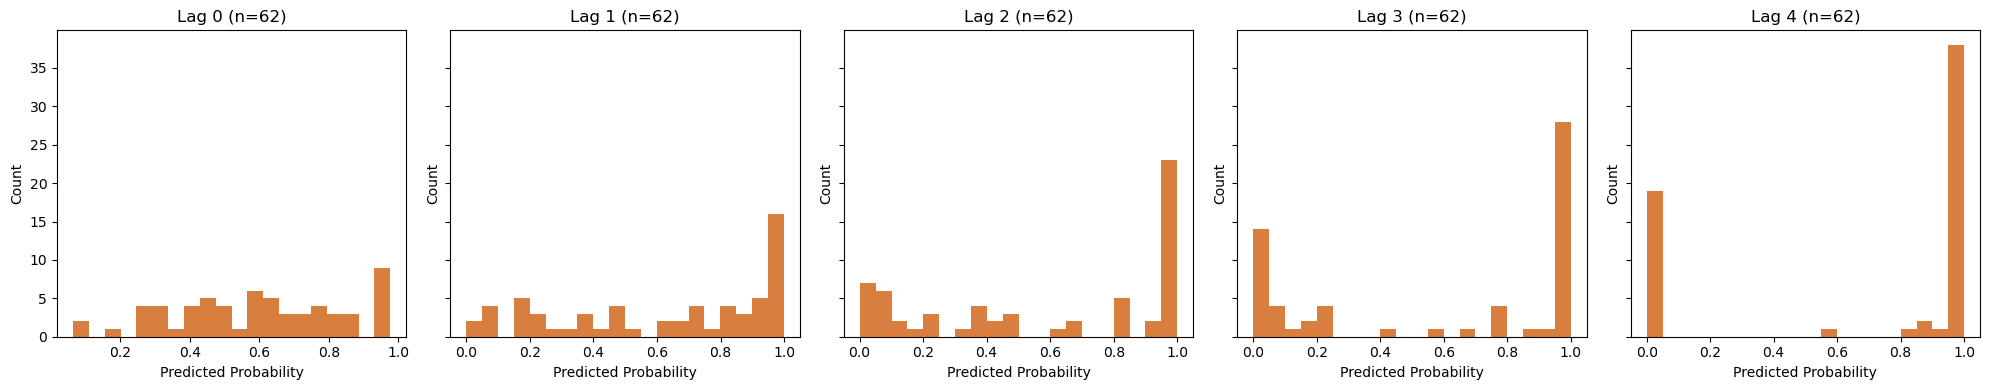

In [67]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(prob_histories_glm), figsize=(4 * len(prob_histories_glm), 4), sharey=True)
if len(prob_histories_glm) == 1:
    axs = [axs]

for i, (lag, probs) in enumerate(sorted(prob_histories_glm.items())):
    axs[i].hist(probs, bins=20, color="#d2691e", alpha=0.85)
    axs[i].set_title(f"Lag {lag} (n={len(probs)})")   # Add total count to the title
    axs[i].set_xlabel("Predicted Probability")
    axs[i].set_ylabel("Count")
    print(f"Lag {lag}: total predictions = {len(probs)}")  # Print to console

plt.tight_layout()
plt.show()


### Test example using original sci-kit-learn model which has regularization, much more even distribution

In [68]:
# # Example comparison for lag 4
# print(train_splits_sklearn[4].equals(train_splits_glm[4]))
# print(test_splits_sklearn[4].equals(test_splits_glm[4]))


In [69]:
# print("Train class distribution:", y_train.value_counts())
# print("Train class weights (GLM):", sample_weights.value_counts())


In [70]:
# Outputs
lr_stats_csv = os.path.join(output_path, "lr_stats_model2_by_lag.csv")
lr_coefs_csv = os.path.join(output_path, "lr_coefs_model2_by_lag.csv")


In [71]:
# Paths to your saved outputs
lr_stats_csv = os.path.join(output_path, "lr_stats_model2_by_lag.csv")
lr_coefs_csv = os.path.join(output_path, "lr_coefs_model2_by_lag.csv")

# Read the stats and coefficients
stats_df = pd.read_csv(lr_stats_csv)
coefs_df = pd.read_csv(lr_coefs_csv)

# Print key model-level metrics by lag
print("=== Logistic Regression Model Stats (GLM, by lag) ===")
display_cols = [
    "lag", "n_train", "n_test", "train_pos", "test_pos",
    "aic", "bic", "auc_train", "auc_test", "accuracy_train", "accuracy_test",
    "recall_train", "recall_test", "precision_train", "precision_test",
    "f1_train", "f1_test", "brier_train", "brier_test",
    "avg_years_as_HFLD"
]
display_cols = [c for c in display_cols if c in stats_df.columns]  # Only keep available cols
print(stats_df[display_cols].to_string(index=False))

# Print top of coefficient table for a chosen lag (e.g., lag 4)
chosen_lag = 0
print(f"\n=== Coefficient Table (lag {chosen_lag}) ===")
print(
    coefs_df.query("lag == @chosen_lag")
        [["variable", "coef", "std_err", "z", "p_value", "ci_lower", "ci_upper"]]
        .to_string(index=False)
)


=== Logistic Regression Model Stats (GLM, by lag) ===
 lag  n_train  n_test  train_pos  test_pos        aic         bic  auc_train  auc_test  accuracy_train  accuracy_test  recall_train  recall_test  precision_train  precision_test  f1_train  f1_test  brier_train  brier_test  avg_years_as_HFLD
   0      245      62        144        37 275.103854 -992.175469   0.850248  0.585946        0.746939       0.532258      0.687500     0.432432         0.853448        0.666667  0.761538 0.524590     0.154057    0.269585           9.840391
   1      245      62        144        37 238.457121 -993.809620   0.920105  0.793514        0.824490       0.774194      0.777778     0.783784         0.910569        0.828571  0.838951 0.805556     0.113158    0.191544           9.840391
   2      245      62        144        37 226.253518 -971.000640   0.946576  0.815135        0.857143       0.758065      0.819444     0.729730         0.929134        0.843750  0.870849 0.782609     0.092476    0.189723  

In [72]:

#Pick the lag you want (e.g., lag 2)
chosen_lag = 0

# Extract the mean HFLD years for that lag
mean_HFLD_years = stats_df.loc[stats_df["lag"] == chosen_lag, "avg_years_as_HFLD"].values[0]

print(f"Average no. years spent as HFLD (lag {chosen_lag}): {mean_HFLD_years:.2f}")

Average no. years spent as HFLD (lag 0): 9.84


### Logistic regression results plots

Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)


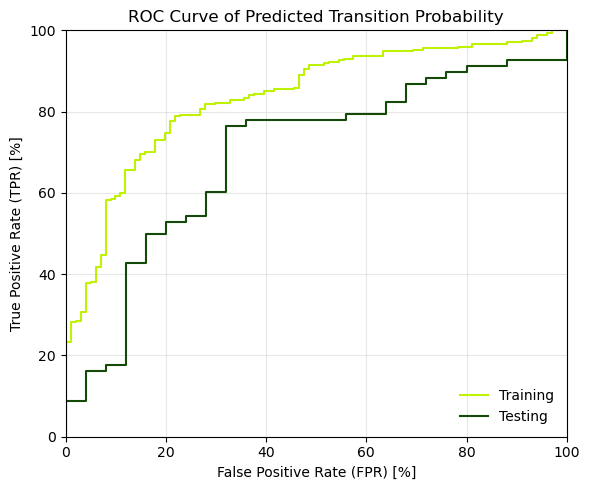

In [73]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# --- Choose lag ---
lag = 0
model_name = f"lr_model_2_lag{lag}"
lr = lr_models[model_name]  # GLMResults for lag

# --- Rebuild input features for this lag (must match model) ---
_Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2001, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,         # (should be consistent with lr above)
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)

# --- Get test/train splits with same predictors ---
start_year = int(lagged_df["year"].min())
start_mask = lagged_df["year"].eq(start_year)
hfld_start = lagged_df.loc[start_mask & lagged_df["HFLD_full_condition"].eq(1.0), ["admin","name"]].drop_duplicates()
keys_start = set(map(tuple, hfld_start[["admin","name"]].to_numpy()))
mask_juris = np.array([k in keys_start for k in map(tuple, lagged_df[["admin","name"]].to_numpy())])
sub = lagged_df.loc[mask_juris, ["admin","name","year","HFLD_full_condition"]].copy()
g   = sub.groupby(["admin","name"], as_index=False)
left_hfld = g["HFLD_full_condition"].min().rename(columns={"HFLD_full_condition":"min_hfld"})
left_hfld["transition"] = (left_hfld["min_hfld"] < 1.0).astype(int)
left_hfld = left_hfld.drop(columns=["min_hfld"])
years_hfld = g["HFLD_full_condition"].sum().rename(columns={"HFLD_full_condition":"years_as_HFLD"})

HFLD_start_df = (
    lagged_df.loc[start_mask]
    .merge(hfld_start, on=["admin","name"], how="inner")
    .merge(left_hfld, on=["admin","name"], how="left")
    .merge(years_hfld,  on=["admin","name"], how="left")
)
valid_predictors = [c for c in predictor_vars if (c in HFLD_start_df.columns) and (HFLD_start_df[c].dtype != "O")]
HFLD_start_df = HFLD_start_df.dropna(subset=valid_predictors + ["transition"])
X = HFLD_start_df[valid_predictors]
y = HFLD_start_df["transition"].astype(int)

from sklearn.model_selection import train_test_split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() == 2 else None
)

# --- Add constant and force right columns ---
X_train_lr_const = sm.add_constant(X_train_lr, has_constant="add")
X_test_lr_const  = sm.add_constant(X_test_lr, has_constant="add")
exog_names = lr.model.exog_names
X_train_lr_const = X_train_lr_const[exog_names]
X_test_lr_const  = X_test_lr_const[exog_names]

# --- Predict probabilities ---
y_prob_train = lr.predict(X_train_lr_const).clip(1e-9, 1-1e-9)
y_prob_test  = lr.predict(X_test_lr_const).clip(1e-9, 1-1e-9)


# --- Compute ROC curves ---
fpr_train, tpr_train, _ = roc_curve(y_train_lr, y_prob_train)
fpr_test,  tpr_test,  _ = roc_curve(y_test_lr,  y_prob_test)

# --- Plot ROC curve ---
fig, ax = plt.subplots(figsize=(6, 5), facecolor='none')
fig.patch.set_alpha(0)
ax.set_facecolor('none')

ax.plot(fpr_train * 100, tpr_train * 100, label='Training', color='#bff102ff')
ax.plot(fpr_test * 100, tpr_test * 100, label='Testing', color='#144a08')
ax.set_title(f"ROC Curve of Predicted Transition Probability")
ax.set_xlabel("False Positive Rate (FPR) [%]")
ax.set_ylabel("True Positive Rate (TPR) [%]")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend(loc='lower right', frameon=False)
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(output_path, f"GLM_ROC_curve_lag{lag}.png"), dpi=300, bbox_inches='tight')
plt.show()


### For regulaized version

In [74]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# lag = 0  # or whatever lag

# if lag not in test_splits_glm or lag not in train_splits_glm or f"lr_model_2_lag{lag}" not in lr_models:
#     print("Missing data for this lag.")
# else:
#     # -- Test set --
#     df_test = test_splits_glm[lag]
#     y_test = df_test["transition"].astype(int)
#     y_prob_test = prob_histories_glm[lag]  # Already computed and stored

#     # -- Train set (must recompute) --
#     df_train = train_splits_glm[lag]
#     y_train = df_train["transition"].astype(int)

#     # Rebuild feature matrix for training set
#     # (re-apply all data prep, scaling, constant, etc exactly as in training!)
#     # This part assumes you have all preprocessing logic in variables:
#     # numeric_pred, USE_REGULARIZATION, StandardScaler, etc.

#     # --- (rebuild X_train exactly as in your model fit) ---
#     # You may need to repeat the exact cleaning, scaling, etc
#     # For this example, let's assume you saved numeric_pred etc from the fit step.
#     _Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
#         merged_df,
#         year_min=hist_start, year_max=2020,
#         drop_cols=("Area",),
#         target=TARGET,
#         max_lag=max_lag_for_lr,
#         use_lag=lag,
#         test_size=0.2,
#         random_state=42,
#         stratify=None,
#         skip_cols=skip_cols
#     )
#     lagged_df = lagged_df[lagged_df.apply(lambda r: (r["admin"], r["name"]) in complete_keys, axis=1)]
#     df2005 = lagged_df.loc[lagged_df["year"] == 2005].copy()
#     avail_pred = [c for c in predictor_vars if c in df2005.columns]
#     numeric_pred = [c for c in avail_pred if pd.api.types.is_numeric_dtype(df2005[c])]
#     df2005 = (
#         df2005
#         .merge(labels_df, on=["admin","name"], how="inner")
#         .merge(years_hfld_global, on=["admin","name"], how="left")
#         .dropna(subset=numeric_pred)
#     )
#     # Handle biome dummies as in training:
#     biome_cols_in = [c for c in biome_dummies if c in numeric_pred]
#     if biome_cols_in:
#         prevalence = {c: float(df2005[c].mean()) for c in biome_cols_in}
#         biome_baseline = max(prevalence, key=prevalence.get)
#         biome_keep = [c for c in biome_cols_in if c != biome_baseline]
#         numeric_pred = [c for c in numeric_pred if c not in biome_cols_in] + biome_keep
#     df2005 = df2005.dropna(subset=numeric_pred + ["transition"])
#     df_train_rebuild = df2005[df2005.apply(lambda r: (r["admin"], r["name"]) in train_keys, axis=1)]
#     X_train = df_train_rebuild[numeric_pred].astype(float)
#     y_train_actual = df_train_rebuild["transition"].astype(int)

#     # Scaling and constant as in training
#     if USE_REGULARIZATION:
#         from sklearn.preprocessing import StandardScaler
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#         X_train_const = sm.add_constant(X_train_scaled, has_constant="add")
#     else:
#         X_train_const = sm.add_constant(X_train, has_constant="add")

#     # Predict train probabilities using model
#     lr = lr_models[f"lr_model_2_lag{lag}"]
#     y_prob_train = lr.predict(X_train_const).clip(1e-9, 1-1e-9)

#     # ROC curves
#     fpr_train, tpr_train, _ = roc_curve(y_train_actual, y_prob_train)
#     fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

#     auc_train = roc_auc_score(y_train_actual, y_prob_train)
#     auc_test = roc_auc_score(y_test, y_prob_test)

#     # Plot both
#     fig, ax = plt.subplots(figsize=(7, 7), facecolor='none')
#     fig.patch.set_alpha(0)
#     ax.set_facecolor('none')

#     ax.plot(fpr_train * 100, tpr_train * 100, color="#bff102ff", linewidth=2, label=f"Train ROC (AUC={auc_train:.3f})")
#     ax.plot(fpr_test * 100, tpr_test * 100, color="#144a08", linewidth=2, label=f"Test ROC (AUC={auc_test:.3f})")
#     # No diagonal line!
#     ax.set_xlabel("False Positive Rate [%]", fontsize=13)
#     ax.set_ylabel("True Positive Rate [%]", fontsize=13)
#     ax.set_xlim(0, 100)
#     ax.set_ylim(0, 100)
#     ax.grid(True, alpha=0.3)
#     ax.legend(loc='lower right', frameon=False)
#     ax.set_title(f"ROC Curve (Lag {lag} | GLM Model 2)", fontsize=15)
#     plt.tight_layout()
#     plt.show()


In [75]:
# After running loop, retrieve the lag 2 split and model:
lag = 0
lr = lr_models[f"lr_model_2_lag{lag}"]

# Recreate the lag 2 split 
_Xtr, _Xte, _ytr, _yte, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2005, year_max=2020,
    drop_cols=("Area",),
    target=TARGET,
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)
start_year = int(lagged_df["year"].min())
start_mask = lagged_df["year"].eq(start_year)
hfld_start = lagged_df.loc[start_mask & lagged_df["HFLD_full_condition"].eq(1.0), ["admin","name"]].drop_duplicates()
keys_start = set(map(tuple, hfld_start[["admin","name"]].to_numpy()))
keys_all = list(map(tuple, lagged_df[["admin","name"]].to_numpy()))
mask_juris = np.array([k in keys_start for k in keys_all])

sub = lagged_df.loc[mask_juris, ["admin","name","year","HFLD_full_condition"]].copy()
g   = sub.groupby(["admin","name"], as_index=False)
left_hfld = g["HFLD_full_condition"].min().rename(columns={"HFLD_full_condition":"min_hfld"})
left_hfld["transition"] = (left_hfld["min_hfld"] < 1.0).astype(int)
left_hfld = left_hfld.drop(columns=["min_hfld"])
years_hfld = g["HFLD_full_condition"].sum().rename(columns={"HFLD_full_condition":"years_as_HFLD"})

HFLD_start_df = lagged_df.loc[start_mask].merge(hfld_start, on=["admin","name"], how="inner")
HFLD_start_df = HFLD_start_df.merge(left_hfld, on=["admin","name"], how="left")
HFLD_start_df = HFLD_start_df.merge(years_hfld,  on=["admin","name"], how="left")

valid_predictors = [c for c in predictor_vars if (c in HFLD_start_df.columns) and (HFLD_start_df[c].dtype != "O")]
HFLD_start_df = HFLD_start_df.dropna(subset=valid_predictors + ["transition"])

X = HFLD_start_df[valid_predictors]
y = HFLD_start_df["transition"].astype(int)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() == 2 else None
)


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (17724, 23) | Test shape: (4432, 23)


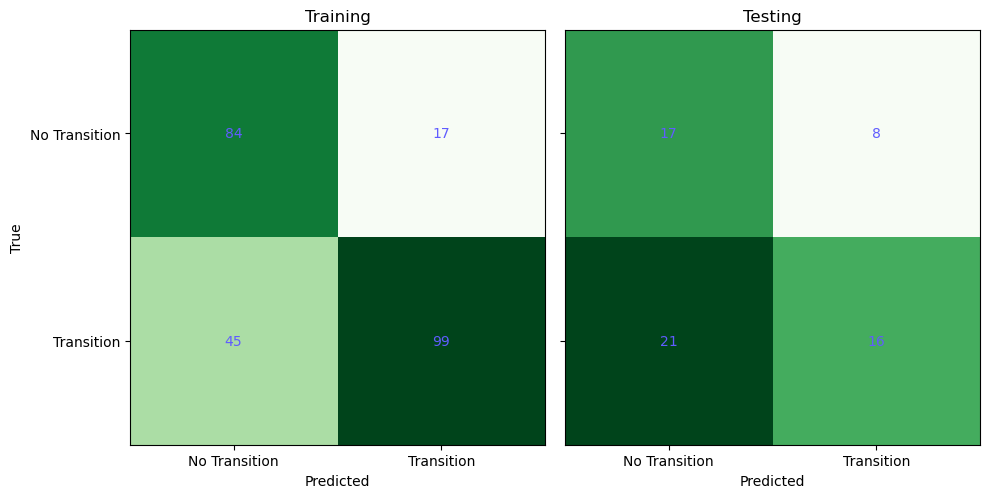

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Ensure input shape/order matches GLM training (see previous advice)
X_train_lr_const = sm.add_constant(X_train_lr, has_constant="add")
X_test_lr_const  = sm.add_constant(X_test_lr, has_constant="add")
exog_names = lr.model.exog_names
X_train_lr_const = X_train_lr_const[exog_names]
X_test_lr_const  = X_test_lr_const[exog_names]

# Predict probabilities
prob_train_lr = lr.predict(X_train_lr_const).clip(1e-9, 1-1e-9)
prob_test_lr  = lr.predict(X_test_lr_const).clip(1e-9, 1-1e-9)
pred_train_lr = (prob_train_lr >= threshold).astype(int)
pred_test_lr  = (prob_test_lr  >= threshold).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
labels = ['No Transition', 'Transition']

# Training set confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_train_lr, pred_train_lr, ax=axs[0], display_labels=labels, cmap='Greens', colorbar=False
)
axs[0].set_title("Training")
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Testing set confusion matrix 
ConfusionMatrixDisplay.from_predictions(
    y_test_lr, pred_test_lr, ax=axs[1], display_labels=labels, cmap='Greens', colorbar=False
)
axs[1].set_title("Testing")
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('')

# Make all numbers white for legibility
for ax in axs:
    for text in ax.texts:
        text.set_color('#605cffff')

fig.tight_layout()
fig.savefig(os.path.join(output_path, "LR_lag2_confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()


In [77]:
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

# --- Add constant, match columns exactly ---
X_train_lr_const = sm.add_constant(X_train_lr, has_constant="add")
X_test_lr_const  = sm.add_constant(X_test_lr,  has_constant="add")
exog_names = lr.model.exog_names
X_train_lr_const = X_train_lr_const[exog_names]
X_test_lr_const  = X_test_lr_const[exog_names]

# --- Predict probabilities using GLM (not sklearn) ---
y_prob_train = lr.predict(X_train_lr_const).clip(1e-9, 1-1e-9)
y_prob_test  = lr.predict(X_test_lr_const).clip(1e-9, 1-1e-9)
pred_train_lr = (y_prob_train >= threshold).astype(int)
pred_test_lr  = (y_prob_test  >= threshold).astype(int)

# --- Confusion matrix and metrics (unchanged) ---
cm_train = confusion_matrix(y_train_lr, pred_train_lr)
cm_test = confusion_matrix(y_test_lr, pred_test_lr)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

train_accuracy = (tp_train + tn_train) / (tp_train + tn_train + fp_train + fn_train)
train_precision = tp_train / (tp_train + fp_train) if (tp_train + fp_train) > 0 else 0
train_recall = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0

test_accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
test_precision = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
test_recall = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

print(f"=== LR REGRESSION PERFORMANCE METRICS (lag={lag}) ===\n")

print("TRAINING SET:")
print(f"  True Negatives:  {tn_train}")
print(f"  False Positives: {fp_train}")
print(f"  False Negatives: {fn_train}")
print(f"  True Positives:  {tp_train}")
print(f"  Accuracy:        {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"  Precision:       {train_precision:.3f} ({train_precision*100:.1f}%)")
print(f"  Recall:          {train_recall:.3f} ({train_recall*100:.1f}%)")
print(f"  F1-Score:        {train_f1:.3f}")

print("\nTEST SET:")
print(f"  True Negatives:  {tn_test}")
print(f"  False Positives: {fp_test}")
print(f"  False Negatives: {fn_test}")
print(f"  True Positives:  {tp_test}")
print(f"  Accuracy:        {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"  Precision:       {test_precision:.3f} ({test_precision*100:.1f}%)")
print(f"  Recall:          {test_recall:.3f} ({test_recall*100:.1f}%)")
print(f"  F1-Score:        {test_f1:.3f}")

print("\n=== INTERPRETATION ===")
print(f"When the model predicts HFLD transition, it's correct {test_precision*100:.1f}% of the time")
print(f"The model catches {test_recall*100:.1f}% of actual HFLD transitions")
print(f"Overall test accuracy: {test_accuracy*100:.1f}%")


=== LR REGRESSION PERFORMANCE METRICS (lag=0) ===

TRAINING SET:
  True Negatives:  84
  False Positives: 17
  False Negatives: 45
  True Positives:  99
  Accuracy:        0.747 (74.7%)
  Precision:       0.853 (85.3%)
  Recall:          0.688 (68.8%)
  F1-Score:        0.762

TEST SET:
  True Negatives:  17
  False Positives: 8
  False Negatives: 21
  True Positives:  16
  Accuracy:        0.532 (53.2%)
  Precision:       0.667 (66.7%)
  Recall:          0.432 (43.2%)
  F1-Score:        0.525

=== INTERPRETATION ===
When the model predicts HFLD transition, it's correct 66.7% of the time
The model catches 43.2% of actual HFLD transitions
Overall test accuracy: 53.2%


## Random forest regressor 

**Training Dataset:** Deforestation rates and covariates for every year that a HFLD status was lost - and the successive 4 years. This increases the sample size, and is justified in capturing medium term changes in a jurisdictions dynamics after deforestation increases

In [78]:
model_2_data = lagged_df.copy()

# Sort to ensure proper diffing
model_2_data = model_2_data.sort_values(["admin", "name", "year"]).copy()

# Create HFLD_Lost as a transition from 1 → 0
model_2_data["HFLD_Lost"] = (
    model_2_data.groupby(["admin", "name"])["HFLD_full_condition"]
    .transform(lambda x: (x.shift(1) == 1) & (x == 0))
    .astype(int)
)


### Set n-year-after-loss to desired window, currently optimised at 4, this means year of loss + 3 years after 

In [79]:
# PARAMETERS
N_YEARS_AFTER_LOSS = 4      # How many years *after* loss to include (set to 1 for just the year of loss)
INCLUDE_TRANSITION_YEAR = True  # Whether to include the transition year itself
USE_TRANSITION_WINDOW = True   # Toggle window logic ON/OFF

# Function to build transition window
def build_hfld_transition_window(df, n_years=N_YEARS_AFTER_LOSS, include_transition=INCLUDE_TRANSITION_YEAR):
    df = df.sort_values(["admin", "name", "year"]).copy()
    out = []
    for (admin, name), group in df.groupby(["admin", "name"]):
        loss_years = group.loc[group["HFLD_Lost"] == 1, "year"].values
        for loss_year in loss_years:
            # Build range: optionally include transition year, then up to n_years after
            start = loss_year if include_transition else loss_year + 1
            years_window = np.arange(start, loss_year + n_years + 1)
            subset = group[group["year"].isin(years_window)]
            out.append(subset)
    if out:
        result = pd.concat(out, ignore_index=True)
        # 🚫 prevent overlapping windows from duplicating rows
        result = result.drop_duplicates(subset=["admin", "name", "year"])
    else:
        result = df.iloc[0:0].copy()
    return result

# Subset block
if USE_TRANSITION_WINDOW:
    HFLD_trans_df = build_hfld_transition_window(model_2_data)
else:
    HFLD_trans_df = model_2_data.query("HFLD_Lost == 1").copy()

# Extra safety: enforce uniqueness at the global level
HFLD_trans_df = HFLD_trans_df.drop_duplicates(subset=["admin", "name", "year"])

# Build predictor_vars
drop_cols = set(ID_COLS + LEAKY_COLS + [
    "Area", "area_ha",
    "HFLD_Score", "HFLD_Binary", "HFLD_Lost",
    "deforRate_10y",
])
predictor_vars = [col for col in HFLD_trans_df.columns if col not in drop_cols]

# Drop NA rows for target and predictors
HFLD_trans_df = HFLD_trans_df.dropna(subset=['deforRate_5yr'] + predictor_vars)

print(f"{HFLD_trans_df['admin'].nunique()} unique countries in model data.")
print(f"{len(set(zip(HFLD_trans_df['admin'], HFLD_trans_df['name'])))} unique jurisdictions in model data.")

# Train/test split (no stratification by biome)
train_df_rf, test_df_rf = train_test_split(
    HFLD_trans_df, test_size=0.2, random_state=41, stratify=None #HFLD_trans_df['biome']  
)
X_train_rf = train_df_rf[predictor_vars]
y_train_rf = train_df_rf['deforRate_5yr']
X_test_rf  = test_df_rf[predictor_vars]
y_test_rf  = test_df_rf['deforRate_5yr']

print(f"Training dataset shape: {X_train_rf.shape}")
print(f"Testing dataset shape: {X_test_rf.shape}")


50 unique countries in model data.
216 unique jurisdictions in model data.
Training dataset shape: (913, 79)
Testing dataset shape: (229, 79)


In [80]:
X_train_rf.head(1)

,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,nl,pd,plantnPct,popden_km2,...,rural_pop_pct_lag3,rural_pop_pct_lag4,temp_lag1,temp_lag2,temp_lag3,temp_lag4,forAreaPct_lag1,forAreaPct_lag2,forAreaPct_lag3,forAreaPct_lag4
770,0.00091,0.308936,113.982583,4612.504395,0.317037,0.000001,0.518617,0.19184,96.213951,369.0706,...,53.525,53.716,263.529829,263.529829,263.529829,263.529829,81.646938,81.734193,81.838771,82.192282


In [81]:
y_train_rf.head(1)

770    0.193053
Name: deforRate_5yr, dtype: float64

### Search best paramaters for random forest 

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators":      [300, 500, 800, 1000],
    "max_depth":         [6, 8, 10, 12, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf":  [1, 2, 5, 10],
    "max_features":      ["sqrt", "log2", 0.5, 0.7, 1.0],
    "bootstrap":         [True],
}
base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)
search.fit(X_train_rf, y_train_rf)

print("Best params:", search.best_params_)
print("Best CV RMSE:", np.sqrt(-search.best_score_))

# Store best_params for downstream modeling
best_params = search.best_params_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/rexdevereux/Desktop/Python/earth-data-hub/.pixi/envs/dev/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. T

Best params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None, 'bootstrap': True}
Best CV RMSE: 0.12450769935787508


### Train RF model

In [83]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

rf_models_2 = {}
rf_metrics_2 = []

# Helper to build the transition-window dataset for a given lag 
def build_rf_window_for_lag(lag):
    _, _, _, _, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
        merged_df,
        year_min=2001, year_max=2020,
        drop_cols=("Area",),
        target="deforRate_5yr",
        max_lag=max_lag,
        use_lag=lag,
        test_size=0.2,
        random_state=42,
        stratify=None,
        skip_cols=skip_cols
    )
    lagged_df = lagged_df.sort_values(["admin", "name", "year"]).copy()
    lagged_df["HFLD_Lost"] = (
        lagged_df.groupby(["admin", "name"])["HFLD_full_condition"]
        .transform(lambda x: (x.shift(1) == 1) & (x == 0))
        .astype(int)
    )
    if USE_TRANSITION_WINDOW:
        HFLD_trans_df = build_hfld_transition_window(lagged_df)
    else:
        HFLD_trans_df = lagged_df.query("HFLD_Lost == 1").copy()
    remove_pred = [
        'admin', 'name', 'year', 'Area', 'area_ha',
        'HFLD_Score', 'HFLD_Binary', 'HFLD_Lost',
        'HFLD_full_condition', 'HFLD', 'HFLD_score',
        'deforRate', 'deforRate_10y', 'deforRate_5yr'
    ]
    predictors = [c for c in predictor_vars if c not in remove_pred]
    HFLD_trans_df = HFLD_trans_df.dropna(subset=["deforRate_5yr"] + predictors)
    HFLD_trans_df["row_key"] = list(zip(HFLD_trans_df["admin"], HFLD_trans_df["name"], HFLD_trans_df["year"]))
    return HFLD_trans_df, predictors

#Create the reference (lag-4) split 
ref_lag = max_lag  #
ref_df, ref_predictors = build_rf_window_for_lag(ref_lag)
train_df_ref, test_df_ref = train_test_split(
    ref_df, test_size=0.2, random_state=41, stratify=None
)
train_row_keys = set(train_df_ref["row_key"].tolist())
test_row_keys  = set(test_df_ref["row_key"].tolist())

print(f"[RF reference split @ lag={ref_lag}] Train n={len(train_row_keys)} | Test n={len(test_row_keys)}")

# - Loop over lags, reusing split 
for lag in tqdm(range(0, max_lag + 1), desc="Model 2 RF by lag"):
    lag_df, predictors = build_rf_window_for_lag(lag)
    lag_df = lag_df[lag_df["row_key"].isin(train_row_keys | test_row_keys)].copy()
    train_df_rf = lag_df[lag_df["row_key"].isin(train_row_keys)].copy()
    test_df_rf  = lag_df[lag_df["row_key"].isin(test_row_keys)].copy()
    X_train_rf = train_df_rf[predictors]
    y_train_rf = train_df_rf["deforRate_5yr"]
    X_test_rf  = test_df_rf[predictors]
    y_test_rf  = test_df_rf["deforRate_5yr"]
    rf = RandomForestRegressor(**best_params, oob_score=True, n_jobs=-1, random_state=123)
    rf.fit(X_train_rf, y_train_rf)
    rf_models_2[f"rf_model_2_lag{lag}"] = rf
    y_train_pred = rf.predict(X_train_rf)
    y_test_pred  = rf.predict(X_test_rf)
    r2_train   = r2_score(y_train_rf, y_train_pred)
    r2_test    = r2_score(y_test_rf, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_rf, y_train_pred))
    rmse_test  = np.sqrt(mean_squared_error(y_test_rf, y_test_pred))
    mae_train  = mean_absolute_error(y_train_rf, y_train_pred)
    mae_test   = mean_absolute_error(y_test_rf, y_test_pred)
    rf_metrics_2.append({
        "lag": lag,
        "model_name": f"rf_model_2_lag{lag}",
        "n_predictors": len(predictors),
        "n_train": X_train_rf.shape[0],
        "n_test": X_test_rf.shape[0],
        "r2_train": r2_train,
        "r2_test": r2_test,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
    })
    print(
        f"lag {lag}: Train n={X_train_rf.shape[0]}, Test n={X_test_rf.shape[0]} | "
        f"Train R2={r2_train:.3f} | Test R2={r2_test:.3f}"
    )

# Results in memory only
rf_metrics_df = pd.DataFrame(rf_metrics_2)

# Quick summary in notebook
print("\nRandom Forest Model 2 Metrics by Lag (train/test):\n")
print(
    rf_metrics_df[
        ["lag","model_name","n_predictors","r2_train","r2_test","rmse_train","rmse_test","mae_train","mae_test","n_train","n_test"]
    ].sort_values("lag").to_string(index=False)
)


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)
[RF reference split @ lag=4] Train n=913 | Test n=229


Model 2 RF by lag:   0%|          | 0/5 [00:00<?, ?it/s]

Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)


Model 2 RF by lag:  20%|██        | 1/5 [00:00<00:02,  1.60it/s]

lag 0: Train n=913, Test n=229 | Train R2=0.885 | Test R2=0.689
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 1 | Predictors: 37
Train shape: (21050, 37) | Test shape: (5263, 37)


Model 2 RF by lag:  40%|████      | 2/5 [00:01<00:02,  1.40it/s]

lag 1: Train n=913, Test n=229 | Train R2=0.892 | Test R2=0.670
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 2 | Predictors: 51
Train shape: (19931, 51) | Test shape: (4983, 51)


Model 2 RF by lag:  60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

lag 2: Train n=913, Test n=229 | Train R2=0.894 | Test R2=0.676
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 3 | Predictors: 65
Train shape: (18814, 65) | Test shape: (4704, 65)


Model 2 RF by lag:  80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

lag 3: Train n=913, Test n=229 | Train R2=0.897 | Test R2=0.644
Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 4 | Predictors: 79
Train shape: (17701, 79) | Test shape: (4426, 79)


Model 2 RF by lag: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

lag 4: Train n=913, Test n=229 | Train R2=0.900 | Test R2=0.674

Random Forest Model 2 Metrics by Lag (train/test):

 lag      model_name  n_predictors  r2_train  r2_test  rmse_train  rmse_test  mae_train  mae_test  n_train  n_test
   0 rf_model_2_lag0            23  0.885321 0.689226    0.071808   0.108176   0.041262  0.066744      913     229
   1 rf_model_2_lag1            37  0.891519 0.669634    0.069841   0.111533   0.040196  0.067924      913     229
   2 rf_model_2_lag2            51  0.893867 0.676193    0.069081   0.110421   0.039309  0.066747      913     229
   3 rf_model_2_lag3            65  0.896876 0.643937    0.068095   0.115790   0.038574  0.068527      913     229
   4 rf_model_2_lag4            79  0.899685 0.674070    0.067161   0.110782   0.037669  0.066835      913     229


In [84]:
# Print RF Model 2 metrics for each lag
cols_to_show = [
    "lag", "model_name", "n_predictors",
    "r2_train", "r2_test", "rmse_train", "rmse_test", "mae_train", "mae_test", "n_train", "n_test"
]

print("\nRandom Forest Model 2 Metrics by Lag (train/test):\n")
print(rf_metrics_df[cols_to_show].to_string(index=False, float_format="%.3f"))



Random Forest Model 2 Metrics by Lag (train/test):

 lag      model_name  n_predictors  r2_train  r2_test  rmse_train  rmse_test  mae_train  mae_test  n_train  n_test
   0 rf_model_2_lag0            23     0.885    0.689       0.072      0.108      0.041     0.067      913     229
   1 rf_model_2_lag1            37     0.892    0.670       0.070      0.112      0.040     0.068      913     229
   2 rf_model_2_lag2            51     0.894    0.676       0.069      0.110      0.039     0.067      913     229
   3 rf_model_2_lag3            65     0.897    0.644       0.068      0.116      0.039     0.069      913     229
   4 rf_model_2_lag4            79     0.900    0.674       0.067      0.111      0.038     0.067      913     229


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)
R2 train: 0.885, R2 test: 0.689


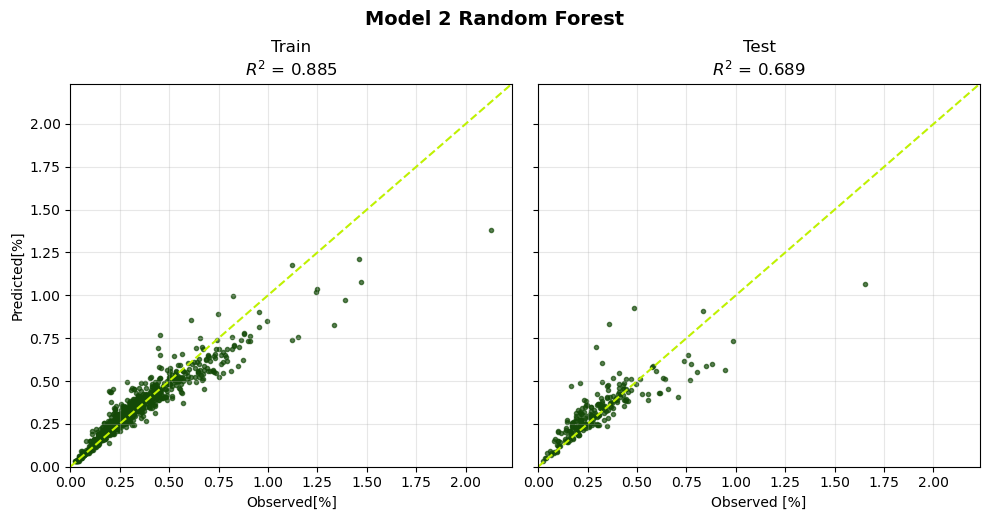

In [85]:
import matplotlib.pyplot as plt

# --- Choose lag for plotting ---
lag = 0  # Change to 1, 2, 3, or 4 as needed

# Rebuild the data split for this lag using the same row keys
lag_df, predictors = build_rf_window_for_lag(lag)
lag_df = lag_df[lag_df["row_key"].isin(train_row_keys | test_row_keys)].copy()
train_df_rf = lag_df[lag_df["row_key"].isin(train_row_keys)].copy()
test_df_rf  = lag_df[lag_df["row_key"].isin(test_row_keys)].copy()
X_train_rf = train_df_rf[predictors]
y_train_rf = train_df_rf["deforRate_5yr"]
X_test_rf  = test_df_rf[predictors]
y_test_rf  = test_df_rf["deforRate_5yr"]

# Predict
rf_model = rf_models_2[f"rf_model_2_lag{lag}"]
pred_train_rf = rf_model.predict(X_train_rf)
pred_test_rf  = rf_model.predict(X_test_rf)

# Metrics (for sanity check)
r2_train = r2_score(y_train_rf, pred_train_rf)
r2_test  = r2_score(y_test_rf,  pred_test_rf)
print(f"R2 train: {r2_train:.3f}, R2 test: {r2_test:.3f}")

# Plot predicted vs actual for train and test
max_val = max(
    max(pred_train_rf, default=0), max(pred_test_rf, default=0),
    max(y_train_rf, default=0), max(y_test_rf, default=0)
) * 1.05

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
axs[0].plot([0, max_val], [0, max_val], linestyle='dashed', color='#bff102ff')
axs[0].scatter(y_train_rf, pred_train_rf, color='#144a08', marker='.', alpha=0.7)
axs[0].set_title(f"Train\n$R^2$ = {r2_train:.3f}")
axs[0].set_ylabel("Predicted[%]")
axs[0].set_xlabel("Observed[%]")
axs[0].set_xlim(0, max_val)
axs[0].set_ylim(0, max_val)
axs[0].grid(True, alpha=0.3)

axs[1].plot([0, max_val], [0, max_val], linestyle='dashed', color='#bff102ff')
axs[1].scatter(y_test_rf, pred_test_rf, color='#144a08', marker='.', alpha=0.7)
axs[1].set_title(f"Test\n$R^2$ = {r2_test:.3f}")
axs[1].set_xlabel("Observed [%]")
axs[1].set_xlim(0, max_val)
axs[1].set_ylim(0, max_val)
axs[1].grid(True, alpha=0.3)
fig.tight_layout()
fig.suptitle("Model 2 Random Forest", fontsize=14, fontweight='bold', y=1.03)
plt.show()


In [86]:
import pandas as pd
import os

# Retrieve model and predictors for lag 
lag = 0
rf = rf_models_2[f"rf_model_2_lag{lag}"]

#Get the predictor variable names for lag 

_, _, _, _, predictor_vars, lagged_df = build_model_dataset_cumulative_lags(
    merged_df,
    year_min=2001, year_max=2020,
    drop_cols=("Area",),
    target="deforRate_5yr",
    max_lag=max_lag,
    use_lag=lag,
    test_size=0.2,
    random_state=42,
    stratify=None,
    skip_cols=skip_cols
)
# Apply same logic as in modeling block to filter predictors
drop_cols = set(ID_COLS + LEAKY_COLS + [
    "Area", "area_ha",
    "HFLD_Score", "HFLD_Binary", "HFLD_Lost",
    "deforRate_10y",
])
predictors_lag3 = [col for col in predictor_vars if col not in drop_cols]
# Feature importances 
importance_raw = rf.feature_importances_
importance_df = pd.DataFrame({
    'Variable': predictors_lag3,
    'Importance': importance_raw
})
importance_df['Percent_Contribution'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
importance_df = importance_df.sort_values('Percent_Contribution', ascending=False)

importance_df.to_csv(os.path.join(output_path, "RF_var_importance_model2_lag{lag}.csv"), index=False)

print(importance_df.head(10))


Cols to lag: ['area_mn', 'ed', 'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2', 'ppt', 'road_density', 'rural_pop_pct', 'temp', 'forAreaPct']
Target: deforRate_5yr | Lags included: 0 | Predictors: 23
Train shape: (22170, 23) | Test shape: (5543, 23)
         Variable  Importance  Percent_Contribution
13     forAreaPct    0.439801             43.980093
1              ed    0.093214              9.321358
8      popden_km2    0.065055              6.505472
7       plantnPct    0.054420              5.442048
6              pd    0.051878              5.187760
15          slope    0.043148              4.314812
11  rural_pop_pct    0.031638              3.163770
9             ppt    0.029613              2.961320
0         area_mn    0.028352              2.835159
5              nl    0.026275              2.627529


In [87]:
importance_df.head(20)

,Variable,Importance,Percent_Contribution
13,forAreaPct,0.439801,43.980093
1,ed,0.093214,9.321358
8,popden_km2,0.065055,6.505472
7,plantnPct,0.054420,5.442048
6,pd,0.051878,5.187760
15,slope,0.043148,4.314812
11,rural_pop_pct,0.031638,3.163770
9,ppt,0.029613,2.961320
0,area_mn,0.028352,2.835159
5,nl,0.026275,2.627529


### Sensitivity Analysis on Random Forest Model

Following internal discussions, the training/testing data for the various elements of Models 1 and 2 was split evenly between which region of the globe the jurisdiction was found. For example, previously where the train/test split was entirely random, more European jurisdictions could appear in the testing dataset, despite the model being trained on more South American ones. Whereas now, equal proportions of each continent are present in the training and testing dataset (~23% of the training and testing samples could be African, for example).

This highlighted how the model's output changed when a different splitting method or random number generator were used. This section aims to quantify this sensitivity, and compare between Models 1 and 2.

In [88]:
# # Define a function for plotting an ellipse for N standard deviations in x and y axes
# def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

#     cov = np.cov(x, y)
#     pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
#     ell_radius_x = np.sqrt(1 + pearson)
#     ell_radius_y = np.sqrt(1 - pearson)
#     ellipse = patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
#     scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)
#     scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)
#     transf = transforms.Affine2D() \
#         .rotate_deg(45) \
#         .scale(scale_x, scale_y) \
#         .translate(mean_x, mean_y)
#     ellipse.set_transform(transf + ax.transData)

#     return ax.add_patch(ellipse)

In [322]:

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Plots an n-std confidence ellipse based on x and y data onto ax.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    if np.any(np.isnan(cov)) or np.any(np.isinf(cov)):
        raise ValueError("Covariance calculation failed; check your inputs for NaN or Inf.")

    # Get the mean
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Eigenvalues and eigenvectors for orientation and axes
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height of the ellipse (2*sqrt(eigenvalue)*n_std)
    width, height = 2 * n_std * np.sqrt(vals)
    
    ellipse = patches.Ellipse(
        (mean_x, mean_y), width=width, height=height,
        angle=angle, facecolor=facecolor, **kwargs
    )
    ax.add_patch(ellipse)
    return ellipse


The cell below performs the random forest training upon the same data and same parameters as in step 2 in Model 2 - however, the random number generator changes each time. This aims to show how sensitive the model is to the particular selection of data that it is trained upon.

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np

# Remove random_state from RF_PARAMS for flexibility in the loop
RF_PARAMS = {
    "n_estimators": 500,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "max_features": 1.0,
    "max_depth": 10,
    "bootstrap": True,
    "oob_score": True
}

# Number of iterations
n_iter_model_2 = 30

# Empty arrays to store metrics
mae_model_2  = np.empty((2, n_iter_model_2))
rmse_model_2 = np.empty((2, n_iter_model_2))
r2_model_2   = np.empty((2, n_iter_model_2))

# Progress bar
pbar = tqdm(total=n_iter_model_2)

for i in range(n_iter_model_2):
    # Random 80/20 split (remove stratify=HFLD_trans_df['biome'] if sample size is small)
    train_df_model_2, test_df_model_2 = train_test_split(
        HFLD_trans_df,
        test_size=0.2,
        random_state=i + 1
    )

    # Features and target
    X_train_model_2 = train_df_model_2[predictor_vars]
    y_train_model_2 = train_df_model_2['deforRate']
    X_test_model_2  = test_df_model_2[predictor_vars]
    y_test_model_2  = test_df_model_2['deforRate']

    # Instantiate model with current random state
    rf_sens_model_2 = RandomForestRegressor(**RF_PARAMS, random_state=i + 1)

    # Fit model
    rf_sens_model_2.fit(X_train_model_2, y_train_model_2)

    # Predictions
    pred_train = rf_sens_model_2.predict(X_train_model_2)
    pred_test  = rf_sens_model_2.predict(X_test_model_2)

    # Store training metrics
    mae_model_2[0, i]  = mean_absolute_error(y_train_model_2, pred_train)
    rmse_model_2[0, i] = np.sqrt(mean_squared_error(y_train_model_2, pred_train))
    r2_model_2[0, i]   = r2_score(y_train_model_2, pred_train)

    # Store testing metrics
    mae_model_2[1, i]  = mean_absolute_error(y_test_model_2, pred_test)
    rmse_model_2[1, i] = np.sqrt(mean_squared_error(y_test_model_2, pred_test))
    r2_model_2[1, i]   = r2_score(y_test_model_2, pred_test)

    # Update progress bar
    pbar.update(1)

pbar.close()


100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


Plotting the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and R2 score for the random forest predictions on the training/testing dataset.

In [90]:
# Define the number of standard deviations to plot the ellipse with
n_std = 2

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Training

# MAE vs R2
confidence_ellipse(r2_model_2[0, :], mae_model_2[0, :], ax1, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_purple)
confidence_ellipse(r2_model_2[0, :], mae_model_2[0, :], ax1, n_std=n_std, edgecolor=dark_purple, linestyle='dashed', label=str(n_std) + r'$\sigma$ (MAE)')
ax1.scatter(r2_model_2[0, :], mae_model_2[0, :], s=3, color=dark_purple)
ax1.set_title("Training\n" + rf"$\sigma$ = {np.std(mae_model_2[0, :]):0.3f} (MAE), {np.std(rmse_model_2[0, :]):0.3f} (RMSE), {np.std(r2_model_2[0, :]):0.3f} (R$^2$)")
ax1.tick_params(axis='y', colors=dark_purple)
ax1.set_ylim(0, 0.3)
ax1.set_xlim(0, 0.8)
ax1.set_ylabel('Mean Absolute Error (MAE)', color=dark_purple)
ax1.set_xlabel(r"R$^2$ Score")

# RMSE vs R2
ax1twin = ax1.twinx()
confidence_ellipse(r2_model_2[0, :], rmse_model_2[0, :], ax1twin, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_green)
confidence_ellipse(r2_model_2[0, :], rmse_model_2[0, :], ax1twin, n_std=n_std, edgecolor=dark_green, linestyle='dashed', label=str(n_std) + r'$\sigma$ (RMSE)')
ax1twin.scatter(r2_model_2[0, :], rmse_model_2[0, :], s=3, color=dark_green)
ax1twin.set_yticks(np.arange(0, 0.7, 0.1), labels=['' for i in range(np.arange(0, 0.7, 0.1).size)])
ax1twin.tick_params(axis='y', colors=dark_green)

# Testing

# MAE vs R2
confidence_ellipse(r2_model_2[1, :], mae_model_2[1, :], ax2, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_purple)
confidence_ellipse(r2_model_2[1, :], mae_model_2[1, :], ax2, n_std=n_std, edgecolor=dark_purple, linestyle='dashed')
ax2.scatter(r2_model_2[1, :], mae_model_2[1, :], s=3, color=dark_purple)
ax2.set_title("Testing\n" + rf"$\sigma$ = {np.std(mae_model_2[1, :]):0.3f} (MAE), {np.std(rmse_model_2[1, :]):0.3f} (RMSE), {np.std(r2_model_2[1, :]):0.3f} (R$^2$)")
ax2.set_yticks(np.arange(0, 0.3, 0.05), labels=['' for i in range(np.arange(0, 0.3, 0.05).size)])
ax2.tick_params(axis='y', colors=dark_purple)
ax2.set_ylim(0, 0.3)
ax2.set_xlim(0, 0.8)
ax2.set_xlabel(r"R$^2$ Score")

# RMSE vs R2
ax2twin = ax2.twinx()
confidence_ellipse(r2_model_2[1, :], rmse_model_2[1, :], ax2twin, n_std=n_std, edgecolor=None, alpha=0.1, facecolor=bright_green)
confidence_ellipse(r2_model_2[1, :], rmse_model_2[1, :], ax2twin, n_std=n_std, edgecolor=dark_green, linestyle='dashed')
ax2twin.scatter(r2_model_2[1, :], rmse_model_2[1, :], s=3, color=dark_green)
ax2twin.tick_params(axis='y', colors=dark_green)
ax2twin.set_ylim(0, 0.6)
ax2twin.set_ylabel('Root Mean Squared Error (RMSE)', color=dark_green)

fig.suptitle(f"Model 2 Sensitivity Analysis (n_iter = {n_iter_model_2}, frac = 1.0)")
fig.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0), frameon=False, title=r"Legend:")
fig.tight_layout()
fig.savefig(os.path.join(output_path, f"Model_2_RF_sensitivity_analysis.png"), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

NameError: name 'confidence_ellipse' is not defined

### Model Evaluation
#### Calculating Performance Metrics

In [91]:
# Define a function for calculating and printing performance metrics
def metrics(y, pred, mode):

    mean_abs_err = mean_absolute_error(y, pred)
    rt_mean_sq_err = np.sqrt(mean_squared_error(y, pred))
    r2_scr = r2_score(y, pred)

    print(f"{mode.capitalize()} Metrics:")
    print(f"Mean Absolute Error:       {mean_abs_err:0.5f}")
    print(f"Root Mean Squared Error:   {rt_mean_sq_err:0.5f}")
    print(f"R² Score:                  {r2_scr:0.5f}\n")

    return mean_abs_err, rt_mean_sq_err, r2_scr

### Predicting Deforestation Rates for Recently LD-to-HD-transitioned Jurisdictions

calc_all_est_defor()

Calculates expected deforestation rates for each jurisdiction-year using:

1. Classification model → prob_transition: probability of losing HFLD status

2. Random Forest regression → pred_deforRate: predicted deforestation if HFLD is lost

3. Historical average → deforRate_5yr: deforestation rate while HFLD (baseline)

4. Expectation formula → exp_deforRate: combines probabilities and both deforestation scenarios, weighted by time typically spent as HFLD (mean_HFLD / window)

Final output exp_deforRate reflects the expected future deforestation rate, adjusting for:

- Likelihood of HFLD transition
- Higher vs. lower deforestation outcomes
- Typical HFLD duration

What *exp_defor_rate* represents:
**The probability-weighted average deforestation rate a jurisdiction is expected to have, considering both scenarios (staying HFLD vs. transitioning out) and how long they typically spend in each state.**

The random forest is heavily weighted to years that deforestation rate changes, so this equation accounts for that

In [92]:
model_2_data = model_2_data.dropna()

In [93]:
# def calc_all_est_defor(
#     model_2_data, 
#     rf_model_2, 
#     clf_model, 
#     clf_predictors_glm,      # <---ist of predictors used in GLM 
#     mean_HFLD=mean_HFLD_years, 
#     window=15
# ):
#     """
#     Compute expected deforestation rate for each jurisdiction-year.
#     - model_2_data: DataFrame of all years for all jurisdictions (with necessary columns)
#     - rf_model_2: trained Random Forest model (e.g., rf_models_2["rf_model_2_lag3"])
#     - clf_model: fitted statsmodels GLMResults object (not sklearn)
#     - clf_predictors_glm: list of predictors incl. "const" used for the GLM
#     - mean_HFLD: average number of years a jurisdiction spends as HFLD (default 7.55)
#     - window: length of the time window (default 18)
#     """
#     results = []
#     all_juris = model_2_data[['admin', 'name']].drop_duplicates()

#     for _, row in all_juris.iterrows():
#         country = row['admin']
#         juris   = row['name']
#         juris_df = model_2_data[(model_2_data['admin'] == country) & (model_2_data['name'] == juris)].copy()
#         if juris_df.empty:
#             continue

#         # --- GLM CLASSIFICATION STEP ---
#         # Get predictors (excluding 'const'), add constant, ensure column order matches training
#         clf_vars = [c for c in clf_predictors_glm if c != "const" and c in juris_df.columns]
#         X_clf = juris_df[clf_vars]
#         X_clf_const = sm.add_constant(X_clf, has_constant="add")
#         # Reorder to match GLM (usually "const" first)
#         X_clf_const = X_clf_const[clf_model.params.index]
#         juris_df['prob_transition'] = clf_model.predict(X_clf_const).clip(1e-9, 1-1e-9)

#         # --- RF REGRESSION STEP (unchanged) ---
#         rf_predictors = [col for col in rf_model_2.feature_names_in_ if col in juris_df.columns]
#         juris_df['pred_deforRate'] = rf_model_2.predict(juris_df[rf_predictors])

#         # --- EXPECTATION FORMULA ---
#         p_i    = juris_df['prob_transition'].values
#         r_hd_i = juris_df['pred_deforRate'].values
#         r_ld_i = juris_df['deforRate_5yr'].values

#         juris_df['exp_deforRate'] = (mean_HFLD / window) * (p_i * r_hd_i + (1 - p_i) * r_ld_i) + \
#                                     (1 - (mean_HFLD / window)) * r_ld_i

#         results.append(juris_df)

#     return pd.concat(results, ignore_index=True)


### Addding the fallback logic - if non-HFLD - above cell is w/o

In [94]:
def calc_all_est_defor(
    model_2_data, 
    rf_model_2, 
    clf_model, 
    clf_predictors_glm,      # <---list of predictors used in GLM 
    mean_HFLD=mean_HFLD_years, 
    window=15
):
    """
    Compute expected deforestation rate for each jurisdiction-year.
    - model_2_data: DataFrame of all years for all jurisdictions (with necessary columns)
    - rf_model_2: trained Random Forest model (e.g., rf_models_2["rf_model_2_lag3"])
    - clf_model: fitted statsmodels GLMResults object (not sklearn)
    - clf_predictors_glm: list of predictors incl. "const" used for the GLM
    - mean_HFLD: average number of years a jurisdiction spends as HFLD (default 7.55)
    - window: length of the time window (default 18)
    """
    results = []
    all_juris = model_2_data[['admin', 'name']].drop_duplicates()

    for _, row in all_juris.iterrows():
        country = row['admin']
        juris   = row['name']
        juris_df = model_2_data[(model_2_data['admin'] == country) & (model_2_data['name'] == juris)].copy()
        if juris_df.empty:
            continue

        # --- GLM CLASSIFICATION STEP ---
        # Get predictors (excluding 'const'), add constant, ensure column order matches training
        clf_vars = [c for c in clf_predictors_glm if c != "const" and c in juris_df.columns]
        X_clf = juris_df[clf_vars]
        X_clf_const = sm.add_constant(X_clf, has_constant="add")
        # Reorder to match GLM (usually "const" first)
        X_clf_const = X_clf_const[clf_model.params.index]
        juris_df['prob_transition'] = clf_model.predict(X_clf_const).clip(1e-9, 1-1e-9)

        # --- RF REGRESSION STEP (unchanged) ---
        rf_predictors = [col for col in rf_model_2.feature_names_in_ if col in juris_df.columns]
        juris_df['pred_deforRate'] = rf_model_2.predict(juris_df[rf_predictors])

        # --- EXPECTATION FORMULA ---
        p_i    = juris_df['prob_transition'].values
        r_hd_i = juris_df['pred_deforRate'].values
        r_ld_i = juris_df['deforRate_5yr'].values

        # juris_df['exp_deforRate'] = (mean_HFLD / window) * (p_i * r_hd_i + (1 - p_i) * r_ld_i) + \
                                    # (1 - (mean_HFLD / window)) * r_ld_i

        exp_blend = (mean_HFLD / window) * (p_i * r_hd_i + (1 - p_i) * r_ld_i) + \
            (1 - (mean_HFLD / window)) * r_ld_i

        juris_df['exp_deforRate'] = np.where(
        juris_df['HFLD_full_condition'].values == 1,
            exp_blend,
            r_ld_i
                    )


        results.append(juris_df)

    return pd.concat(results, ignore_index=True)


In [95]:

clf_predictors_glm = X_train_const.columns.tolist()

# Set lags for final model results here 
rf_model_2 = rf_models_2["rf_model_2_lag0"]
clf_model = lr_models["lr_model_2_lag0"]

df_results = calc_all_est_defor(
    model_2_data, 
    rf_model_2,
    clf_model, 
    clf_predictors_glm=clf_predictors_glm,   # <--- pass here
    mean_HFLD=mean_HFLD_years,
    window=15,
    #smoothing_years=3
)


In [96]:
all_predictions_df = df_results

In [97]:
all_predictions_df.head()

,admin,name,year,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,nl,...,temp_lag3,temp_lag4,forAreaPct_lag1,forAreaPct_lag2,forAreaPct_lag3,forAreaPct_lag4,HFLD_Lost,prob_transition,pred_deforRate,exp_deforRate
0,Angola,Bengo,2005,0.001561,0.472601,237.511647,4310.755859,0.439,0.000001,0.016575,...,248.759949,248.759949,82.632089,82.718662,82.869137,83.067336,0,0.822022,0.207038,0.250838
1,Angola,Bengo,2006,0.001565,0.473885,237.511647,5028.169434,0.454,0.000001,0.045684,...,248.759949,248.759949,82.584831,82.632089,82.718662,82.869137,0,0.816290,0.207043,0.168530
2,Angola,Bengo,2007,0.001559,0.481085,237.511647,5957.757324,0.468,0.000001,0.050854,...,248.759949,248.759949,82.552938,82.584831,82.632089,82.718662,1,0.810078,0.206909,0.154172
3,Angola,Bengo,2008,0.001562,0.484528,237.511647,6555.964844,0.480,0.000001,0.092255,...,248.759949,248.759949,82.231966,82.552938,82.584831,82.632089,0,0.803625,0.203857,0.165819
4,Angola,Bengo,2009,0.001556,0.484510,237.511647,6492.359375,0.488,0.000001,0.135938,...,248.759949,248.759949,82.034756,82.231966,82.552938,82.584831,0,0.803044,0.216481,0.217933


In [98]:
print(
    all_predictions_df[
        (all_predictions_df['admin'] == 'Democratic Republic of the Congo') &
        (all_predictions_df['name'].str.lower().str.contains('équateur'))
    ][['admin', 'name', 'year', 'exp_deforRate']]
)


                                 admin      name  year  exp_deforRate
4675  Democratic Republic of the Congo  Équateur  2005       0.223153
4676  Democratic Republic of the Congo  Équateur  2006       0.226319
4677  Democratic Republic of the Congo  Équateur  2007       0.228185
4678  Democratic Republic of the Congo  Équateur  2008       0.231974
4679  Democratic Republic of the Congo  Équateur  2009       0.260181
4680  Democratic Republic of the Congo  Équateur  2010       0.283286
4681  Democratic Republic of the Congo  Équateur  2011       0.295241
4682  Democratic Republic of the Congo  Équateur  2012       0.308300
4683  Democratic Republic of the Congo  Équateur  2013       0.330626
4684  Democratic Republic of the Congo  Équateur  2014       0.340244
4685  Democratic Republic of the Congo  Équateur  2015       0.352579
4686  Democratic Republic of the Congo  Équateur  2016       0.433238
4687  Democratic Republic of the Congo  Équateur  2017       0.501992
4688  Democratic Rep

In [99]:
matches = all_predictions_df[
    (all_predictions_df['admin'] == 'Democratic Republic of the Congo') &
    (all_predictions_df['name'].str.strip().str.lower().str.contains('tshuapa'))
][['admin', 'name', 'year', 'exp_deforRate']]
print(matches)


Empty DataFrame
Columns: [admin, name, year, exp_deforRate]
Index: []


In [100]:
province_name_remap = {
    'Bandundu': 'Mai-Ndombe',
    'Équateur': 'Tshuapa',
}

In [101]:
province_name_remap = {
    'Bandundu': 'Mai-Ndombe',
    'Équateur': 'Tshuapa',
    # Add more as needed
}

# Apply to all main dataframes before any merges
for df in [merged_df, plotting_df, all_predictions_df]:
    df['name'] = df['name'].replace(province_name_remap)


In [102]:
plotting_df = plotting_df.merge(
    all_predictions_df[['admin', 'name', 'year', 'exp_deforRate']].rename(
        columns={'exp_deforRate': f'Model_2'}
    ),
    on=['admin', 'name', 'year'],
    how='left'
)


In [103]:
# Join 'Area' from merge_df into plotting_df as 'area_ha'
plotting_df = plotting_df.merge(
    merged_df[['admin', 'name', 'Area']].drop_duplicates(),
    on=['admin', 'name'],
    how='left'
).rename(columns={'Area': 'area_ha'})

In [104]:
plotting_df.head()

,admin,name,year,Area_x,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,HFLD,deforRate_5yr,defor_yrs_used,HFLD_full_condition,biome,forAreaPct,rf_predicted_model1_lag0,Model_1,Model_2,Area_y
0,Angola,Bengo,2001,34209.4,0.001393,0.474366,237.511647,3863.362549,0.401,0.000001,...,0,0.672158,1,0,Africa,83.067336,NaN,NaN,NaN,34209.4
1,Angola,Bengo,2002,34209.4,0.001402,0.473212,237.511647,3473.173584,0.406,0.000001,...,1,0.455379,2,0,Africa,82.869137,NaN,NaN,NaN,34209.4
2,Angola,Bengo,2003,34209.4,0.001407,0.472173,237.511647,3528.035645,0.415,0.000001,...,1,0.364114,3,0,Africa,82.718662,NaN,NaN,NaN,34209.4
3,Angola,Bengo,2004,34209.4,0.001565,0.471019,237.511647,3775.235352,0.426,0.000001,...,1,0.299250,4,0,Africa,82.632089,NaN,NaN,NaN,34209.4
4,Angola,Bengo,2005,34209.4,0.001561,0.472601,237.511647,4310.755859,0.439,0.000001,...,1,0.250838,5,0,Africa,82.584831,0.358256,0.358256,0.250838,34209.4


In [105]:
tshuapa_results = plotting_df[plotting_df['name'].str.strip().str.lower() == 'tshuapa'][['year', 'Model_1', 'Model_2']]
print(tshuapa_results)

      year   Model_1   Model_2
5862  2001       NaN       NaN
5863  2002       NaN       NaN
5864  2003       NaN       NaN
5865  2004       NaN       NaN
5866  2005  0.190845  0.223153
5867  2006  0.193316  0.226319
5868  2007  0.196700  0.228185
5869  2008  0.203235  0.231974
5870  2009  0.219948  0.260181
5871  2010  0.226285  0.283286
5872  2011  0.234850  0.295241
5873  2012  0.262010  0.308300
5874  2013  0.331173  0.330626
5875  2014  0.410568  0.340244
5876  2015  0.409568  0.352579
5877  2016  0.447775  0.433238
5878  2017  0.464761  0.501992
5879  2018  0.516219  0.570417
5880  2019  0.549466  0.576044
5881  2020  0.555315  0.596078


In [106]:
plotting_df.to_csv(os.path.join(output_path, "results.csv"), index=False)

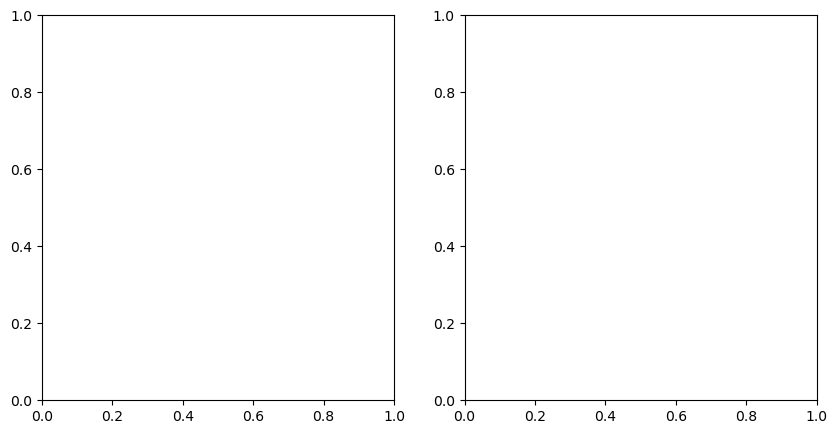

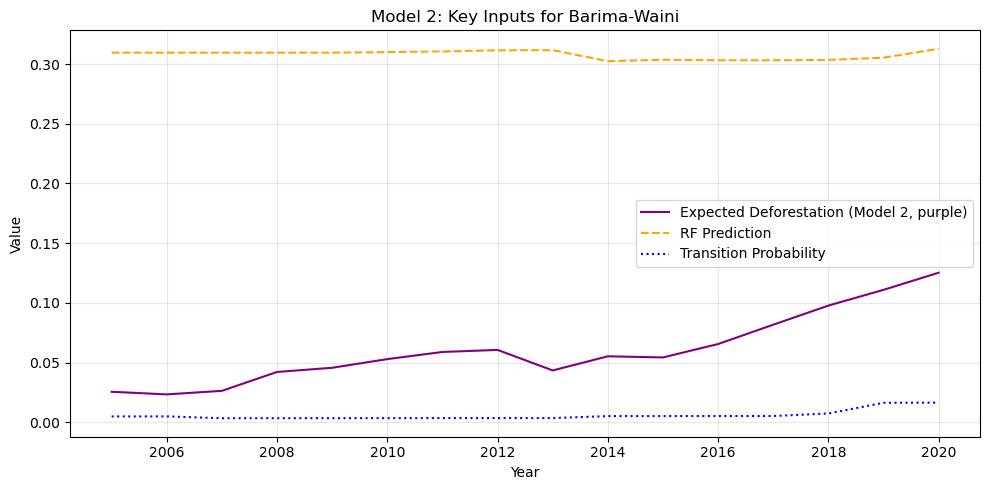

     admin          name  year  deforRate_5yr  exp_deforRate  pred_deforRate  \
0   Guyana  Barima-Waini  2005       0.024577       0.025475        0.309613   
1   Guyana  Barima-Waini  2006       0.022367       0.023279        0.309613   
2   Guyana  Barima-Waini  2007       0.025647       0.026260        0.309613   
3   Guyana  Barima-Waini  2008       0.041490       0.042076        0.309613   
4   Guyana  Barima-Waini  2009       0.045001       0.045585        0.309613   
5   Guyana  Barima-Waini  2010       0.052267       0.052841        0.310089   
6   Guyana  Barima-Waini  2011       0.058263       0.058831        0.310672   
7   Guyana  Barima-Waini  2012       0.059992       0.060559        0.311592   
8   Guyana  Barima-Waini  2013       0.042749       0.043355        0.311743   
9   Guyana  Barima-Waini  2014       0.054377       0.055207        0.302479   
10  Guyana  Barima-Waini  2015       0.053410       0.054249        0.303734   
11  Guyana  Barima-Waini  2016       0.0

In [107]:
import matplotlib.pyplot as plt

# Filter for Barima-Waini
bw_df = all_predictions_df[all_predictions_df["name"] == "Barima-Waini"].copy()
bw_df = bw_df.sort_values("year")

# Plot: All three key series over time
plt.figure(figsize=(10, 5))
plt.plot(bw_df["year"], bw_df["exp_deforRate"], label="Expected Deforestation (Model 2, purple)", color="purple")
plt.plot(bw_df["year"], bw_df["pred_deforRate"], label="RF Prediction", color="orange", linestyle="--")
plt.plot(bw_df["year"], bw_df["prob_transition"], label="Transition Probability", color="blue", linestyle=":")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Model 2: Key Inputs for Barima-Waini")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show the underlying values as a table for easier diagnosis
cols = ["admin", "name", "year", "deforRate_5yr", "exp_deforRate", "pred_deforRate", "prob_transition"]
bw_table = bw_df[cols].reset_index(drop=True)
print(bw_table)


# Output plots

In [108]:
plotting_df.head()

,admin,name,year,Area_x,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,HFLD,deforRate_5yr,defor_yrs_used,HFLD_full_condition,biome,forAreaPct,rf_predicted_model1_lag0,Model_1,Model_2,Area_y
0,Angola,Bengo,2001,34209.4,0.001393,0.474366,237.511647,3863.362549,0.401,0.000001,...,0,0.672158,1,0,Africa,83.067336,NaN,NaN,NaN,34209.4
1,Angola,Bengo,2002,34209.4,0.001402,0.473212,237.511647,3473.173584,0.406,0.000001,...,1,0.455379,2,0,Africa,82.869137,NaN,NaN,NaN,34209.4
2,Angola,Bengo,2003,34209.4,0.001407,0.472173,237.511647,3528.035645,0.415,0.000001,...,1,0.364114,3,0,Africa,82.718662,NaN,NaN,NaN,34209.4
3,Angola,Bengo,2004,34209.4,0.001565,0.471019,237.511647,3775.235352,0.426,0.000001,...,1,0.299250,4,0,Africa,82.632089,NaN,NaN,NaN,34209.4
4,Angola,Bengo,2005,34209.4,0.001561,0.472601,237.511647,4310.755859,0.439,0.000001,...,1,0.250838,5,0,Africa,82.584831,0.358256,0.358256,0.250838,34209.4


Time series of predictions for countries of interest

In [109]:
drc_names = plotting_df.loc[
    plotting_df['admin'] == 'Democratic Republic of the Congo', 'name'
].dropna().unique()

print("Unique 'name' values for Democratic Republic of the Congo:")
for name in sorted(drc_names):
    print("-", name)


Unique 'name' values for Democratic Republic of the Congo:
- Kasaï-Oriental
- Maniema
- Nord-Kivu
- Sud-Kivu
- Tshuapa


In [110]:
# Join 'Area' from merge_df into plotting_df as 'area_ha'
plotting_df = plotting_df.merge(
    merged_df[['admin', 'name', 'Area']].drop_duplicates(),
    on=['admin', 'name'],
    how='left'
).rename(columns={'Area': 'area_ha'})


In [111]:
plotting_df

,admin,name,year,Area_x,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,deforRate_5yr,defor_yrs_used,HFLD_full_condition,biome,forAreaPct,rf_predicted_model1_lag0,Model_1,Model_2,Area_y,area_ha
0,Angola,Bengo,2001,34209.4,0.001393,0.474366,237.511647,3863.362549,0.401000,0.000001,...,0.672158,1,0,Africa,83.067336,NaN,NaN,NaN,34209.4,34209.4
1,Angola,Bengo,2002,34209.4,0.001402,0.473212,237.511647,3473.173584,0.406000,0.000001,...,0.455379,2,0,Africa,82.869137,NaN,NaN,NaN,34209.4,34209.4
2,Angola,Bengo,2003,34209.4,0.001407,0.472173,237.511647,3528.035645,0.415000,0.000001,...,0.364114,3,0,Africa,82.718662,NaN,NaN,NaN,34209.4,34209.4
3,Angola,Bengo,2004,34209.4,0.001565,0.471019,237.511647,3775.235352,0.426000,0.000001,...,0.299250,4,0,Africa,82.632089,NaN,NaN,NaN,34209.4,34209.4
4,Angola,Bengo,2005,34209.4,0.001561,0.472601,237.511647,4310.755859,0.439000,0.000001,...,0.250838,5,0,Africa,82.584831,0.358256,0.358256,0.250838,34209.4,34209.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27708,Zambia,Western,2016,129495.0,0.002219,0.156911,1056.960623,3693.616731,0.578853,0.000861,...,0.174974,5,0,Africa,64.793393,0.288099,0.288099,0.174974,129495.0,129495.0
27709,Zambia,Western,2017,129495.0,0.002049,0.159783,1056.960623,3693.616731,0.578853,0.000861,...,0.219366,5,0,Africa,64.578305,0.277777,0.277777,0.219366,129495.0,129495.0
27710,Zambia,Western,2018,129495.0,0.001769,0.167501,1056.960623,3693.616731,0.578853,0.000861,...,0.260856,5,0,Africa,64.348973,0.268004,0.268004,0.260856,129495.0,129495.0
27711,Zambia,Western,2019,129495.0,0.001705,0.169681,1056.960623,3693.616731,0.578853,0.000861,...,0.273031,5,0,Africa,64.197597,0.272845,0.272845,0.273031,129495.0,129495.0


In [112]:
plotting_df.columns

Index(['admin', 'name', 'year', 'Area_x', 'area_mn', 'ed', 'elevation',
       'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2',
       'ppt', 'road_density', 'rural_pop_pct', 'slope', 'temp', 'country',
       'region', 'for_area', 'pc_for_area', 'deforRate', 'HFLD_score', 'HFLD',
       'deforRate_5yr', 'defor_yrs_used', 'HFLD_full_condition', 'biome',
       'forAreaPct', 'rf_predicted_model1_lag0', 'Model_1', 'Model_2',
       'Area_y', 'area_ha'],
      dtype='object')

/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/3854874120.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/3854874120.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folde

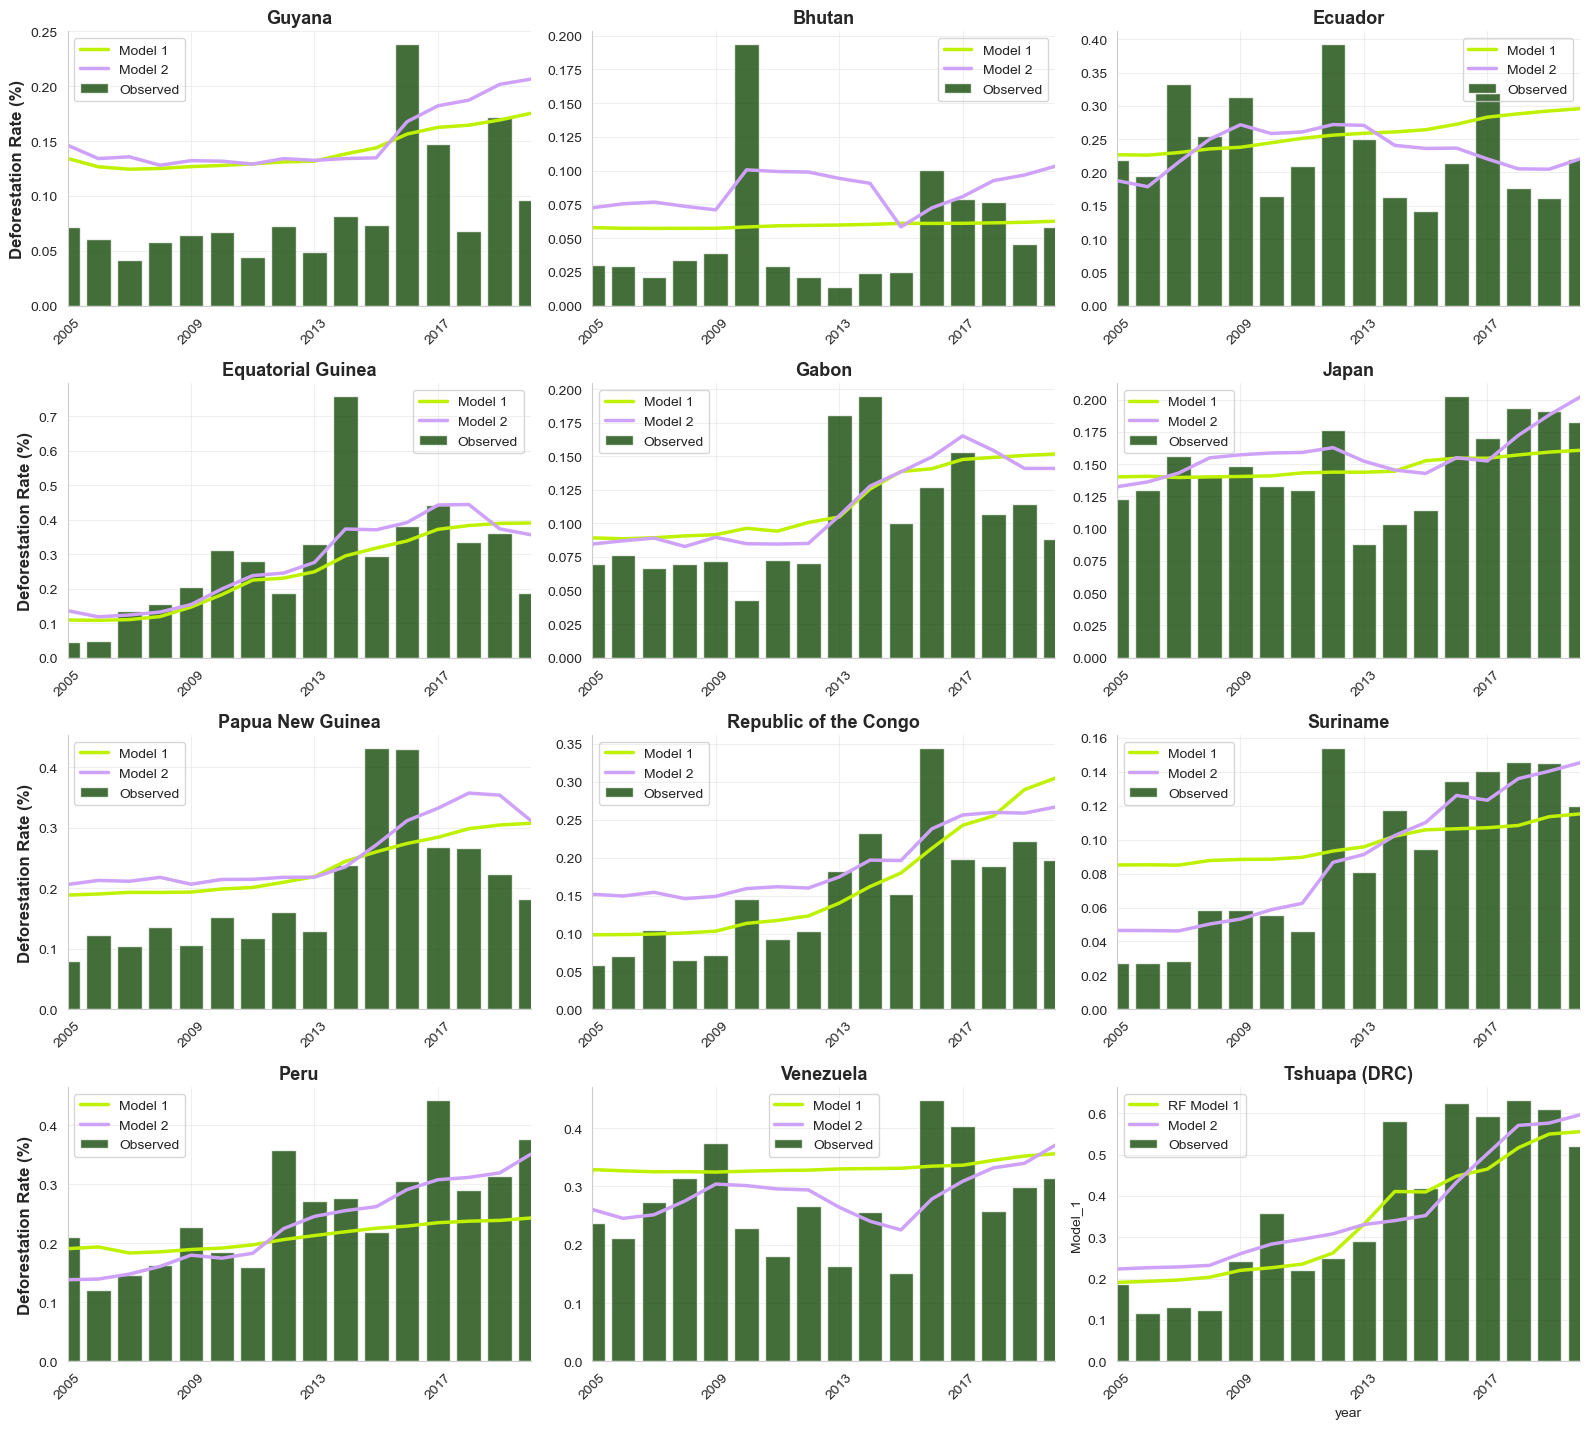

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Countries to include
countries = ["Guyana", "Bhutan", "Ecuador", "Equatorial Guinea", "Gabon", "Japan", "Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"]
add_tshuapa = True
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 3
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# Main countries
for idx, country in enumerate(countries):
    ax = axs[idx]

    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]

    if country_data.empty:
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
            'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
    sns.lineplot(data=yearly_avg, x='year', y='Model_1', linewidth=2.5, color='#bff102ff', label='Model 1', ax=ax)
    sns.lineplot(data=yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

# --- Tshuapa subplot ---
if add_tshuapa:
    tsh_ax = axs[len(countries)]
    tsh_data = plotting_df[
        (plotting_df['admin'] == 'Democratic Republic of the Congo') &
        (plotting_df['name'] == 'Tshuapa')
    ].sort_values('year')

    if not tsh_data.empty:
        def weighted_avg_tsh(group):
            weights = group['Area_x']
            return pd.Series({
                'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
                'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
                'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
            })

        tsh_yearly_avg = tsh_data.groupby('year').apply(weighted_avg_tsh).reset_index()

        tsh_ax.bar(tsh_yearly_avg['year'], tsh_yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
        sns.lineplot(data=tsh_yearly_avg, x='year', y='Model_1', linewidth=2.5, color='#bff102ff', label='RF Model 1', ax=tsh_ax)
        sns.lineplot(data=tsh_yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=tsh_ax)

        tsh_ax.set_title("Tshuapa (DRC)", fontsize=13, fontweight='bold')
        tsh_ax.set_xlim(2005, 2020)
        tsh_ax.set_xticks(range(2005, 2021, 4))
        tsh_ax.tick_params(axis='x', rotation=45, labelsize=10)
        tsh_ax.tick_params(axis='y', labelsize=10)
        tsh_ax.grid(True, alpha=0.3)
        tsh_ax.spines['top'].set_visible(False)
        tsh_ax.spines['right'].set_visible(False)
        if (len(countries) % n_cols) == 0:
            tsh_ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')

# Hide unused subplots
for ax in axs[total_plots:]:
    ax.set_visible(False)

# Layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/country_outputs_model_comparison.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1219148877.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1219148877.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folde

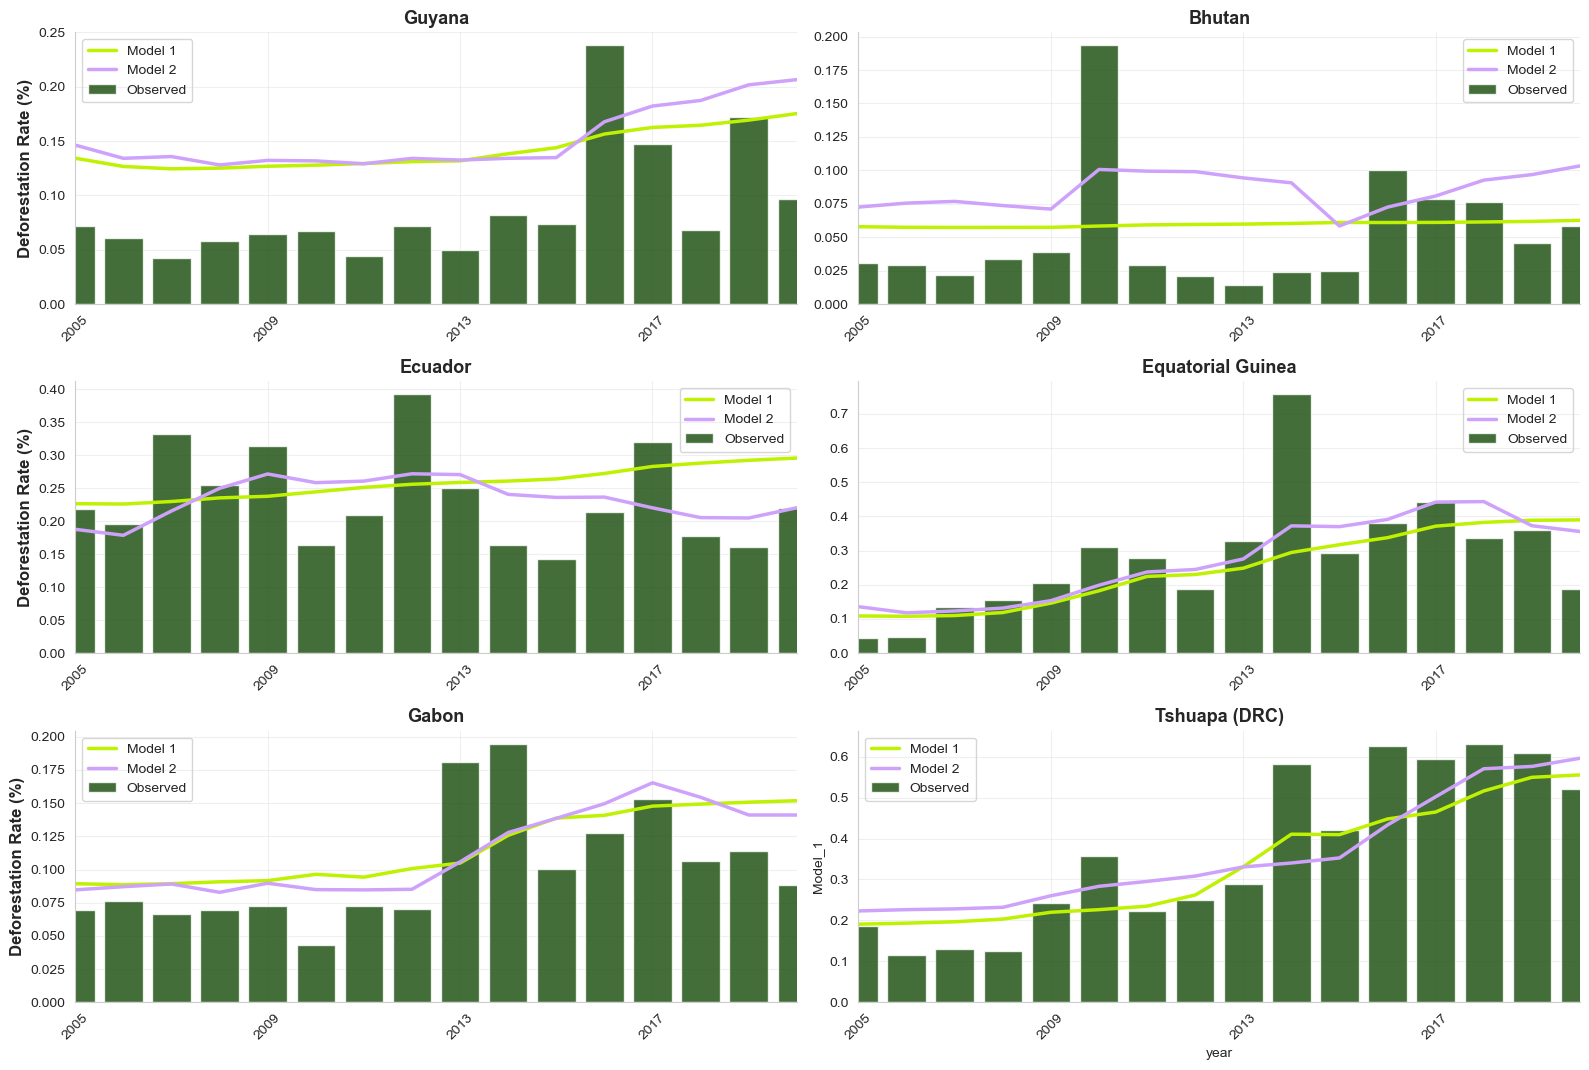

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Countries to include
countries = ["Guyana", "Bhutan", "Ecuador", "Equatorial Guinea", "Gabon"]
add_tshuapa = True
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 2
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# Main countries
for idx, country in enumerate(countries):
    ax = axs[idx]

    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]

    if country_data.empty:
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
            'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
    sns.lineplot(data=yearly_avg, x='year', y='Model_1', linewidth=2.5, color='#bff102ff', label='Model 1', ax=ax)
    sns.lineplot(data=yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

# --- Tshuapa subplot ---
if add_tshuapa:
    tsh_ax = axs[len(countries)]
    tsh_data = plotting_df[
        (plotting_df['admin'] == 'Democratic Republic of the Congo') &
        (plotting_df['name'] == 'Tshuapa')
    ].sort_values('year')

    if not tsh_data.empty:
        def weighted_avg_tsh(group):
            weights = group['Area_x']
            return pd.Series({
                'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
                'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
                'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
            })

        tsh_yearly_avg = tsh_data.groupby('year').apply(weighted_avg_tsh).reset_index()

        tsh_ax.bar(tsh_yearly_avg['year'], tsh_yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
        sns.lineplot(data=tsh_yearly_avg, x='year', y='Model_1', linewidth=2.5, color='#bff102ff', label='Model 1', ax=tsh_ax)
        sns.lineplot(data=tsh_yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=tsh_ax)

        tsh_ax.set_title("Tshuapa (DRC)", fontsize=13, fontweight='bold')
        tsh_ax.set_xlim(2005, 2020)
        tsh_ax.set_xticks(range(2005, 2021, 4))
        tsh_ax.tick_params(axis='x', rotation=45, labelsize=10)
        tsh_ax.tick_params(axis='y', labelsize=10)
        tsh_ax.grid(True, alpha=0.3)
        tsh_ax.spines['top'].set_visible(False)
        tsh_ax.spines['right'].set_visible(False)
        if (len(countries) % n_cols) == 0:
            tsh_ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')

# Hide unused subplots
for ax in axs[total_plots:]:
    ax.set_visible(False)

# Layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/model2_set1.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/2078570417.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/2078570417.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folde

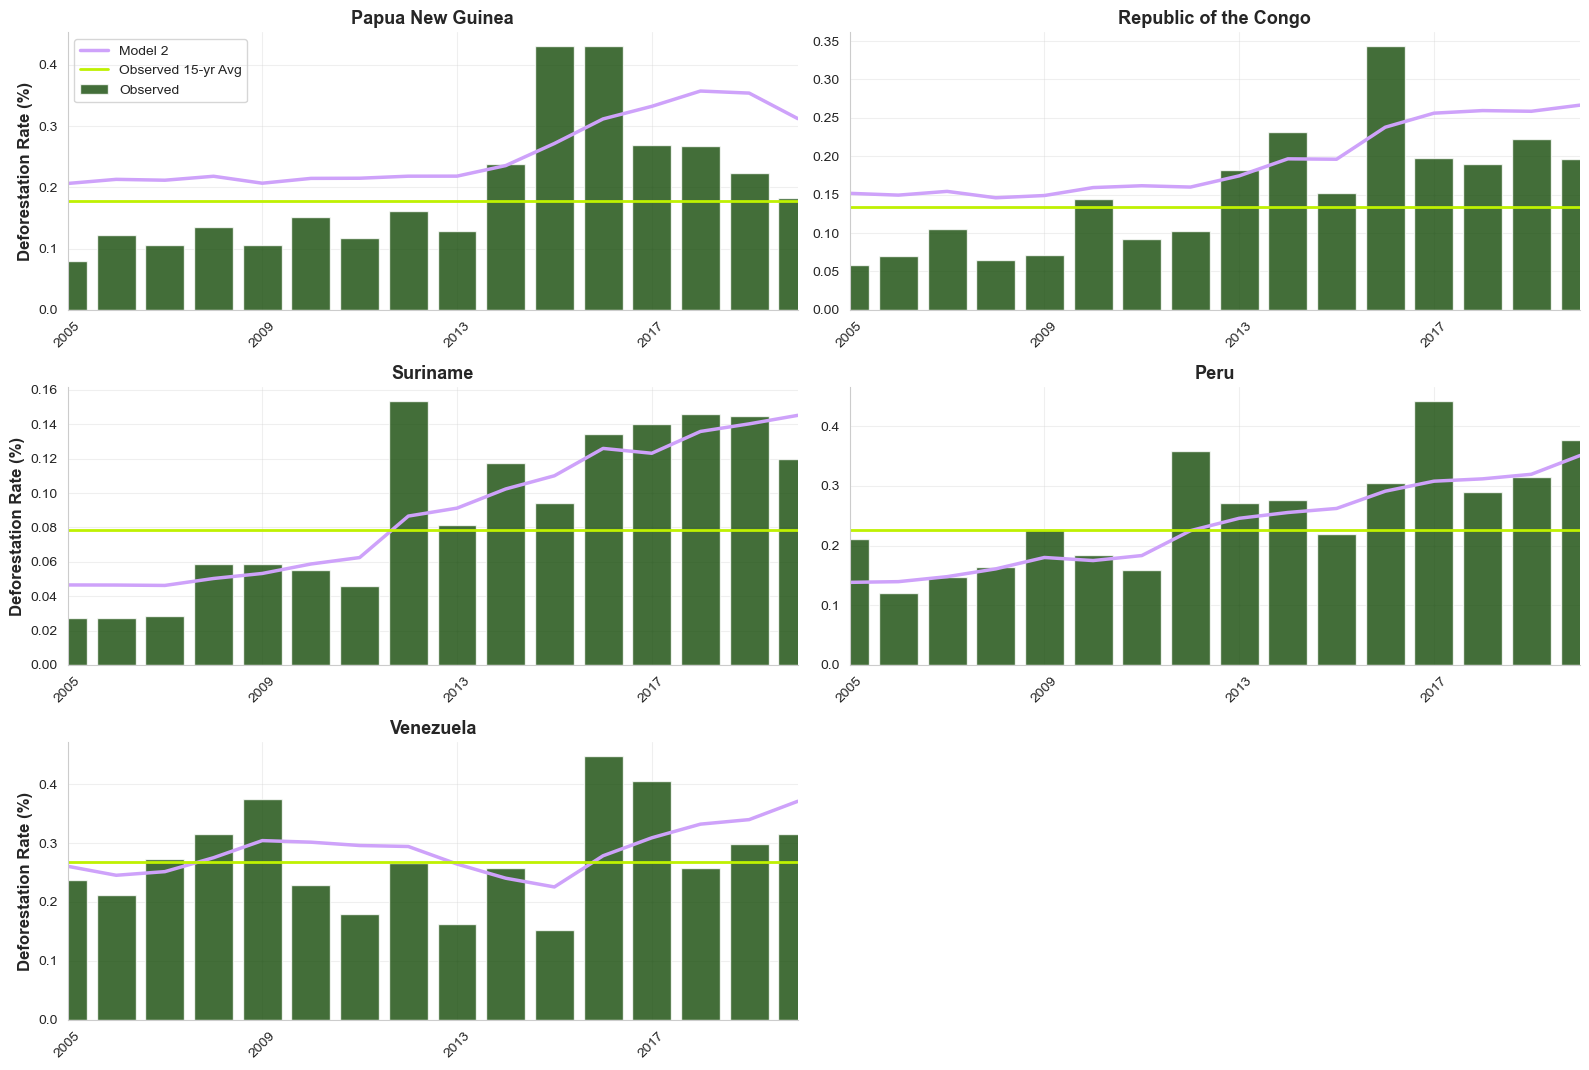

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Only these 5 countries
countries = ["Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"]
n_plots = len(countries)

n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

for idx, country in enumerate(countries):
    ax = axs[idx]
    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]
    if country_data.empty:
        ax.set_visible(False)
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    # Plot observed bars
    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')

    # Plot Model 2 line
    sns.lineplot(data=yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)

    # Plot horizontal line for 15-yr observed mean
    obs_mean = yearly_avg['deforRate'].mean()
    ax.axhline(obs_mean, color='#bff102ff', linestyle='-', linewidth=2, label='Observed 15-yr Avg')

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    # Only show legend for first subplot
    if idx == 0:
        ax.legend()
    else:
        ax.get_legend().remove()

# Delete any unused axes
for idx in range(n_plots, len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/Model 2 set 2 .png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/75783062.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/75783062.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/h

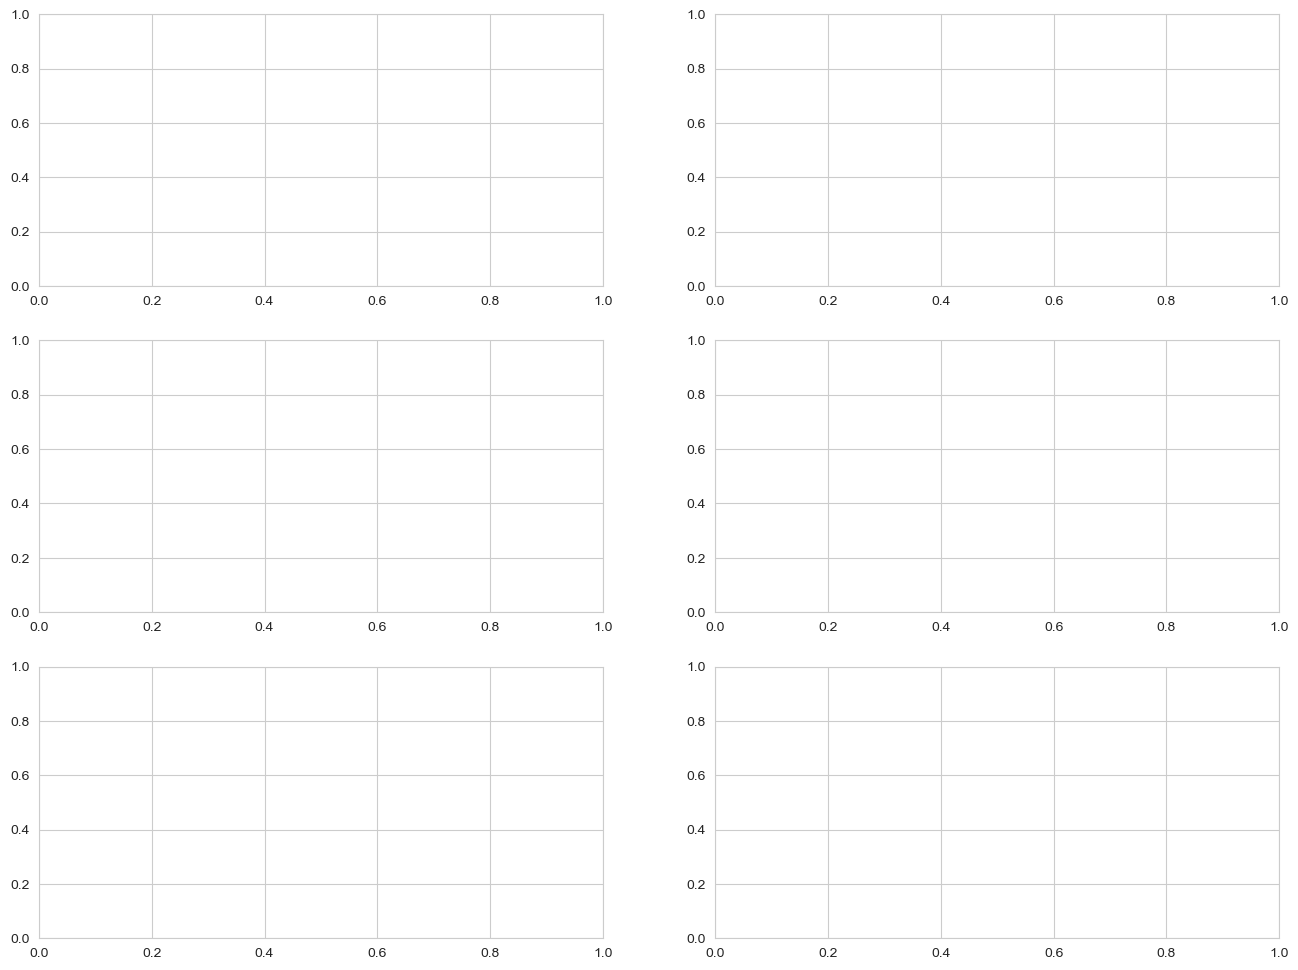

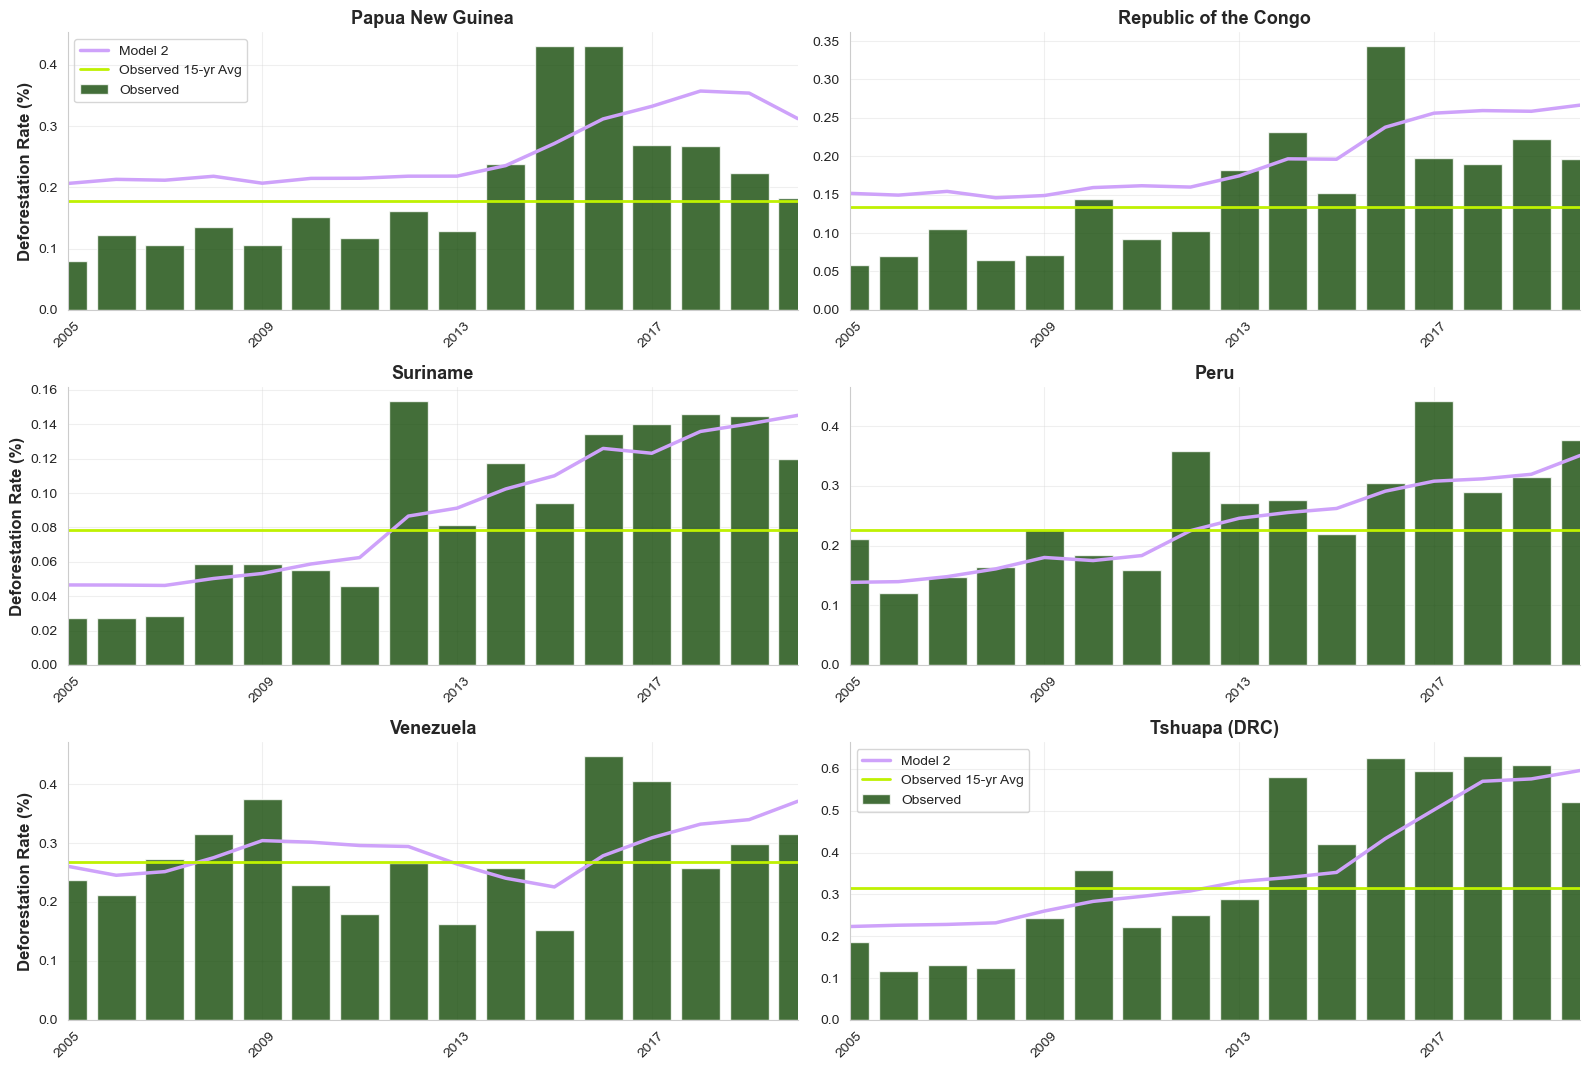

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Main countries
countries = ["Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"]
add_tshuapa = True
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 2
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# ---- Loop for main countries ----
for idx, country in enumerate(countries):
    ax = axs[idx]
    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]
    if country_data.empty:
        ax.set_visible(False)
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    # Observed bars
    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
    # Model 2 line
    sns.lineplot(data=yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)
    # Horizontal mean
    obs_mean = yearly_avg['deforRate'].mean()
    ax.axhline(obs_mean, color='#bff102ff', linestyle='-', linewidth=2, label='Observed 15-yr Avg')

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    if idx == 0:
        ax.legend()
    else:
        ax.get_legend().remove()

# ---- Add Tshuapa subplot ----
if add_tshuapa:
    idx = len(countries)
    ax = axs[idx]
    tshuapa_data = plotting_df[
        (plotting_df['admin'] == "Democratic Republic of the Congo") &
        (plotting_df['name'] == "Tshuapa") &
        (plotting_df['Area_x'].notna())
    ]
    if not tshuapa_data.empty:
        def weighted_avg_tsh(group):
            weights = group['Area_x']
            return pd.Series({
                'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
                'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
            })
        tshuapa_yearly = tshuapa_data.groupby('year').apply(weighted_avg_tsh).reset_index()
        # Observed bars
        ax.bar(tshuapa_yearly['year'], tshuapa_yearly['deforRate'], color='#144a08', alpha=0.8, label='Observed')
        # Model 2 line
        sns.lineplot(data=tshuapa_yearly, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)
        obs_mean = tshuapa_yearly['deforRate'].mean()
        ax.axhline(obs_mean, color='#bff102ff', linestyle='-', linewidth=2, label='Observed 15-yr Avg')

        ax.set_title("Tshuapa (DRC)", fontsize=13, fontweight='bold')
        ax.set_xlim(2005, 2020)
        ax.set_xticks(range(2005, 2021, 4))
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if idx % n_cols == 0:
            ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.legend()
    else:
        ax.set_visible(False)

# Hide unused subplots
for idx in range(total_plots, len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/Model2_main_plus_tshuapa.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1253673371.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1253673371.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folde

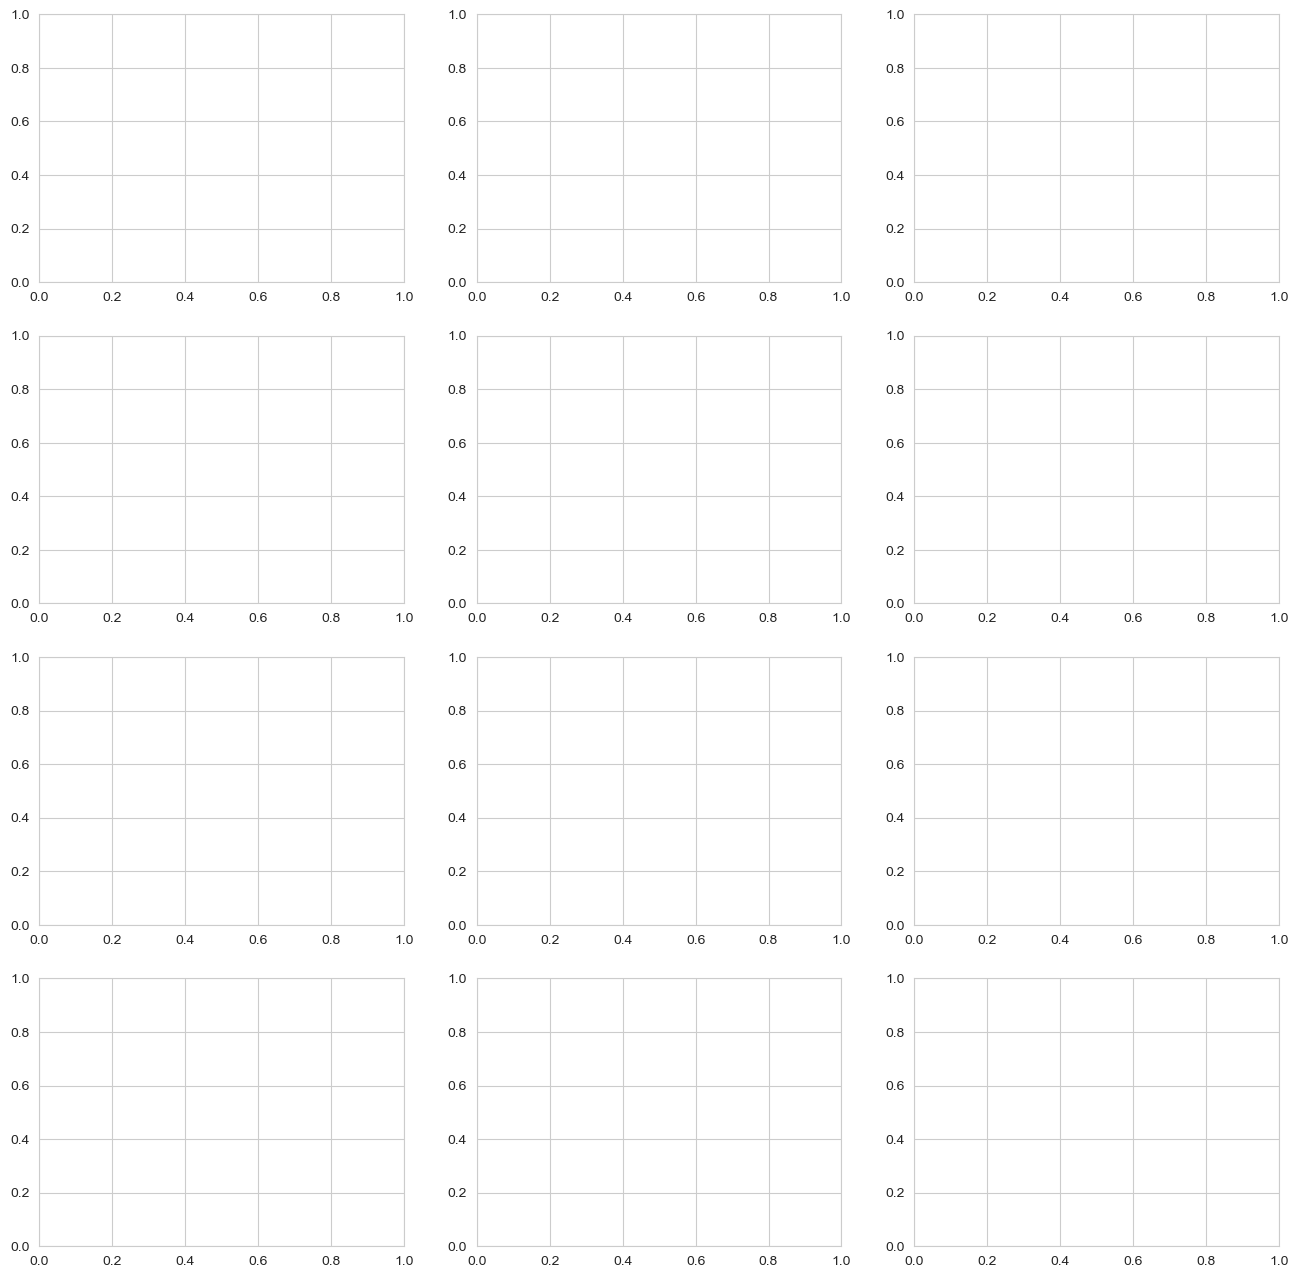

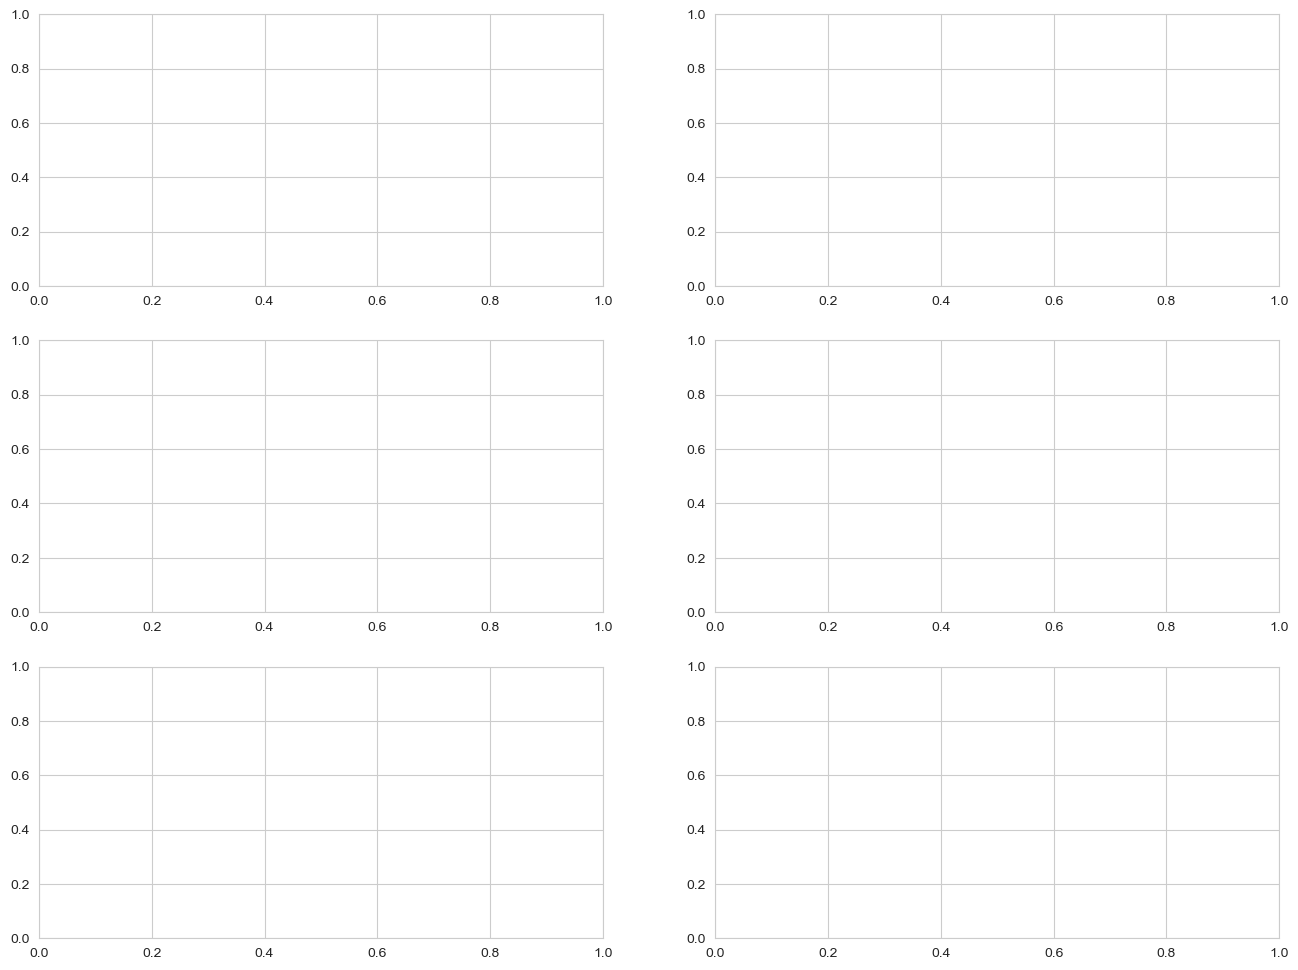

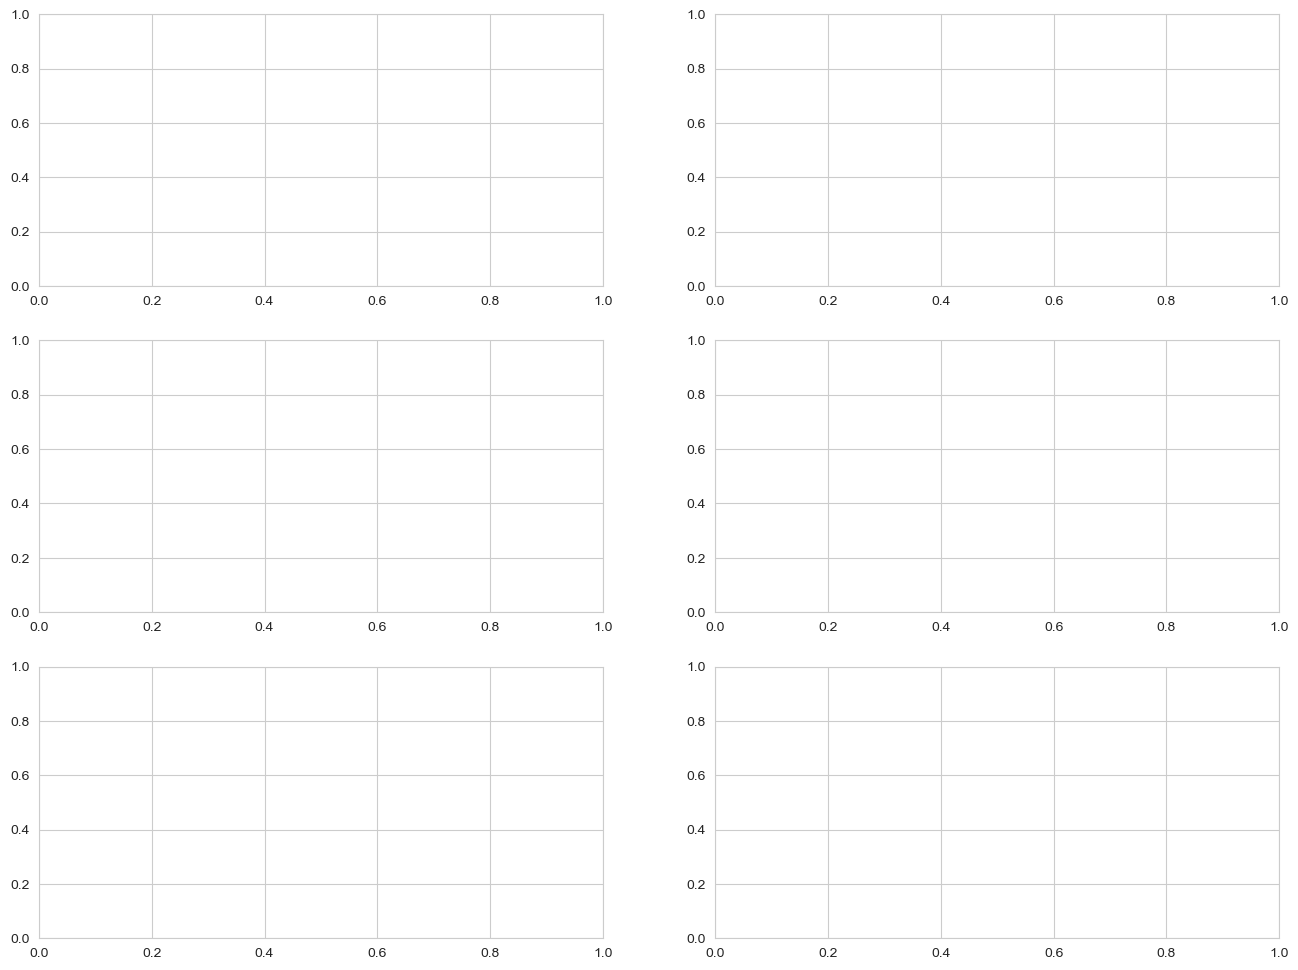

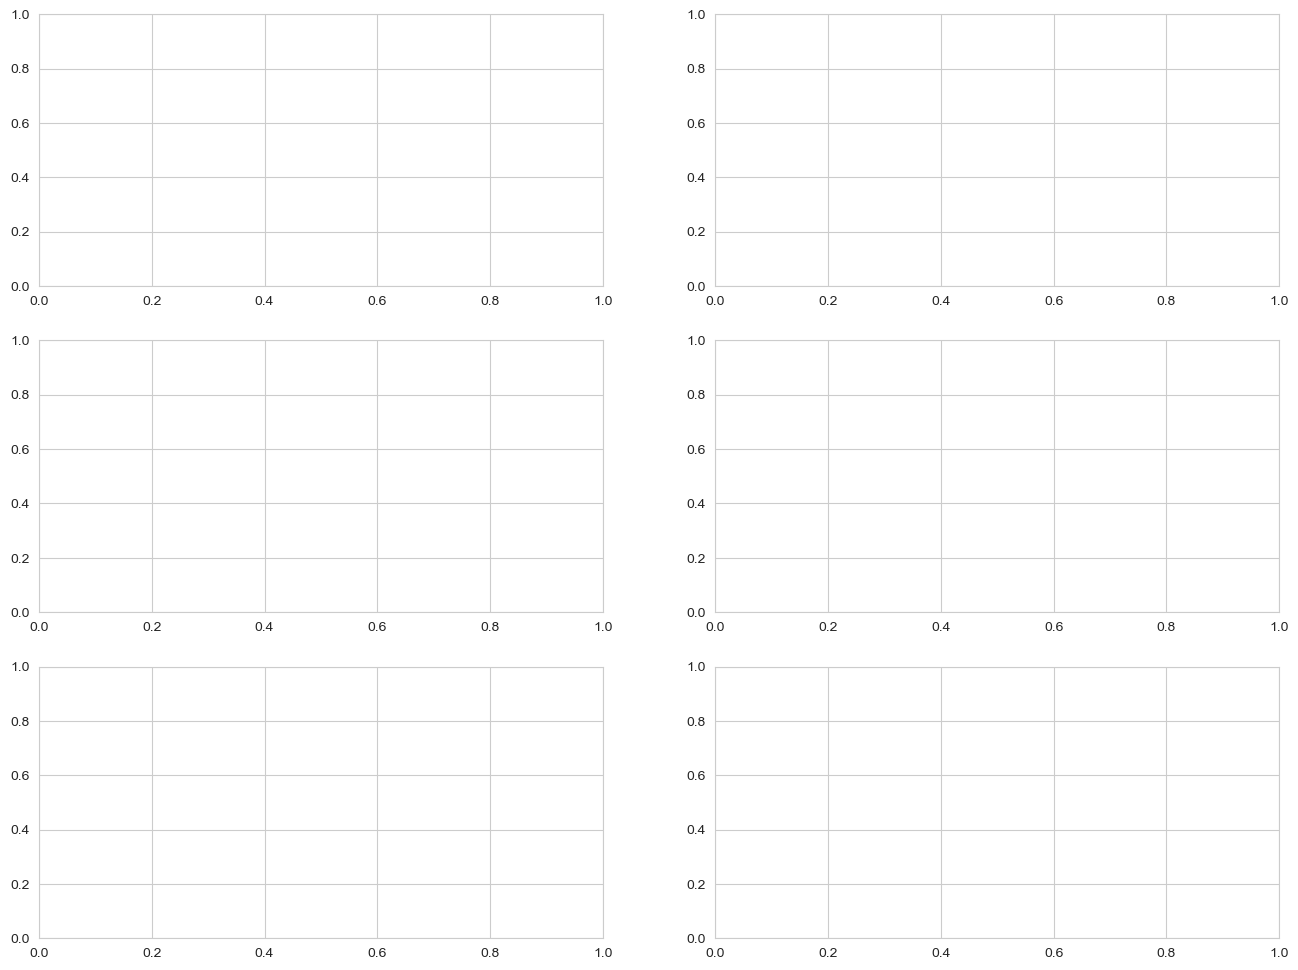

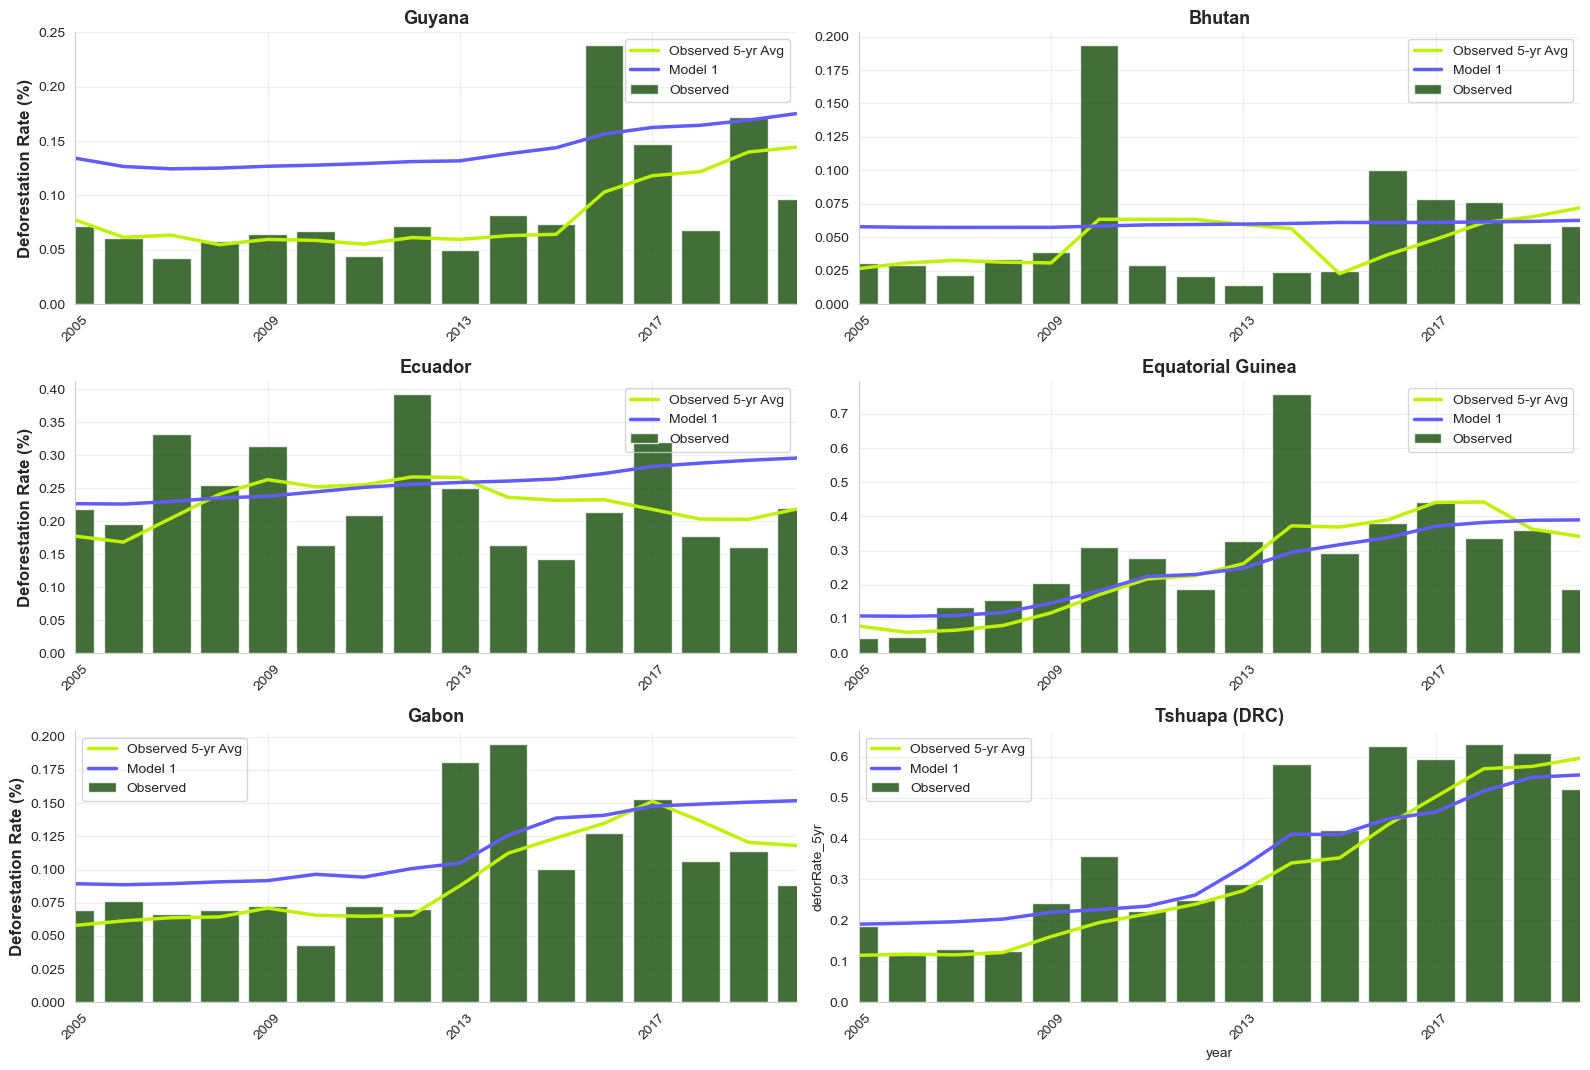

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Countries to include
countries = ["Guyana", "Bhutan", "Ecuador", "Equatorial Guinea", "Gabon"]
add_tshuapa = True
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 2
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# Main countries
for idx, country in enumerate(countries):
    ax = axs[idx]

    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]

    if country_data.empty:
        ax.set_visible(False)
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'deforRate_5yr': (group['deforRate_5yr'] * weights).sum() / weights.sum(),
            'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    # Plot observed bars
    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')

    # Plot 5-yr rolling observed as a line
    sns.lineplot(
        data=yearly_avg, x='year', y='deforRate_5yr',
        linewidth=2.5, color='#bff102ff', label='Observed 5-yr Avg', ax=ax
    )

    # Plot Model 1 line
    sns.lineplot(
        data=yearly_avg, x='year', y='Model_1',
        linewidth=2.5, color='#605cffff', label='Model 1', ax=ax
    )

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    # Show legend on every subplot
    ax.legend()

# --- Tshuapa subplot ---
if add_tshuapa:
    tsh_ax = axs[len(countries)]
    tsh_data = plotting_df[
        (plotting_df['admin'] == 'Democratic Republic of the Congo') &
        (plotting_df['name'] == 'Tshuapa')
    ].sort_values('year')

    if not tsh_data.empty:
        def weighted_avg_tsh(group):
            weights = group['Area_x']
            return pd.Series({
                'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
                'deforRate_5yr': (group['deforRate_5yr'] * weights).sum() / weights.sum(),
                'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
            })

        tsh_yearly_avg = tsh_data.groupby('year').apply(weighted_avg_tsh).reset_index()

        tsh_ax.bar(tsh_yearly_avg['year'], tsh_yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
        sns.lineplot(
            data=tsh_yearly_avg, x='year', y='deforRate_5yr',
            linewidth=2.5, color='#bff102ff', label='Observed 5-yr Avg', ax=tsh_ax
        )
        sns.lineplot(
            data=tsh_yearly_avg, x='year', y='Model_1',
            linewidth=2.5, color='#605cffff', label='Model 1', ax=tsh_ax
        )

        tsh_ax.set_title("Tshuapa (DRC)", fontsize=13, fontweight='bold')
        tsh_ax.set_xlim(2005, 2020)
        tsh_ax.set_xticks(range(2005, 2021, 4))
        tsh_ax.tick_params(axis='x', rotation=45, labelsize=10)
        tsh_ax.tick_params(axis='y', labelsize=10)
        tsh_ax.grid(True, alpha=0.3)
        tsh_ax.spines['top'].set_visible(False)
        tsh_ax.spines['right'].set_visible(False)
        if (len(countries) % n_cols) == 0:
            tsh_ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')

        # Show legend for Tshuapa too
        tsh_ax.legend()

# Hide unused subplots
for ax in axs[total_plots:]:
    ax.set_visible(False)

# Layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/Model1_set1.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/91166393.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/91166393.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/h

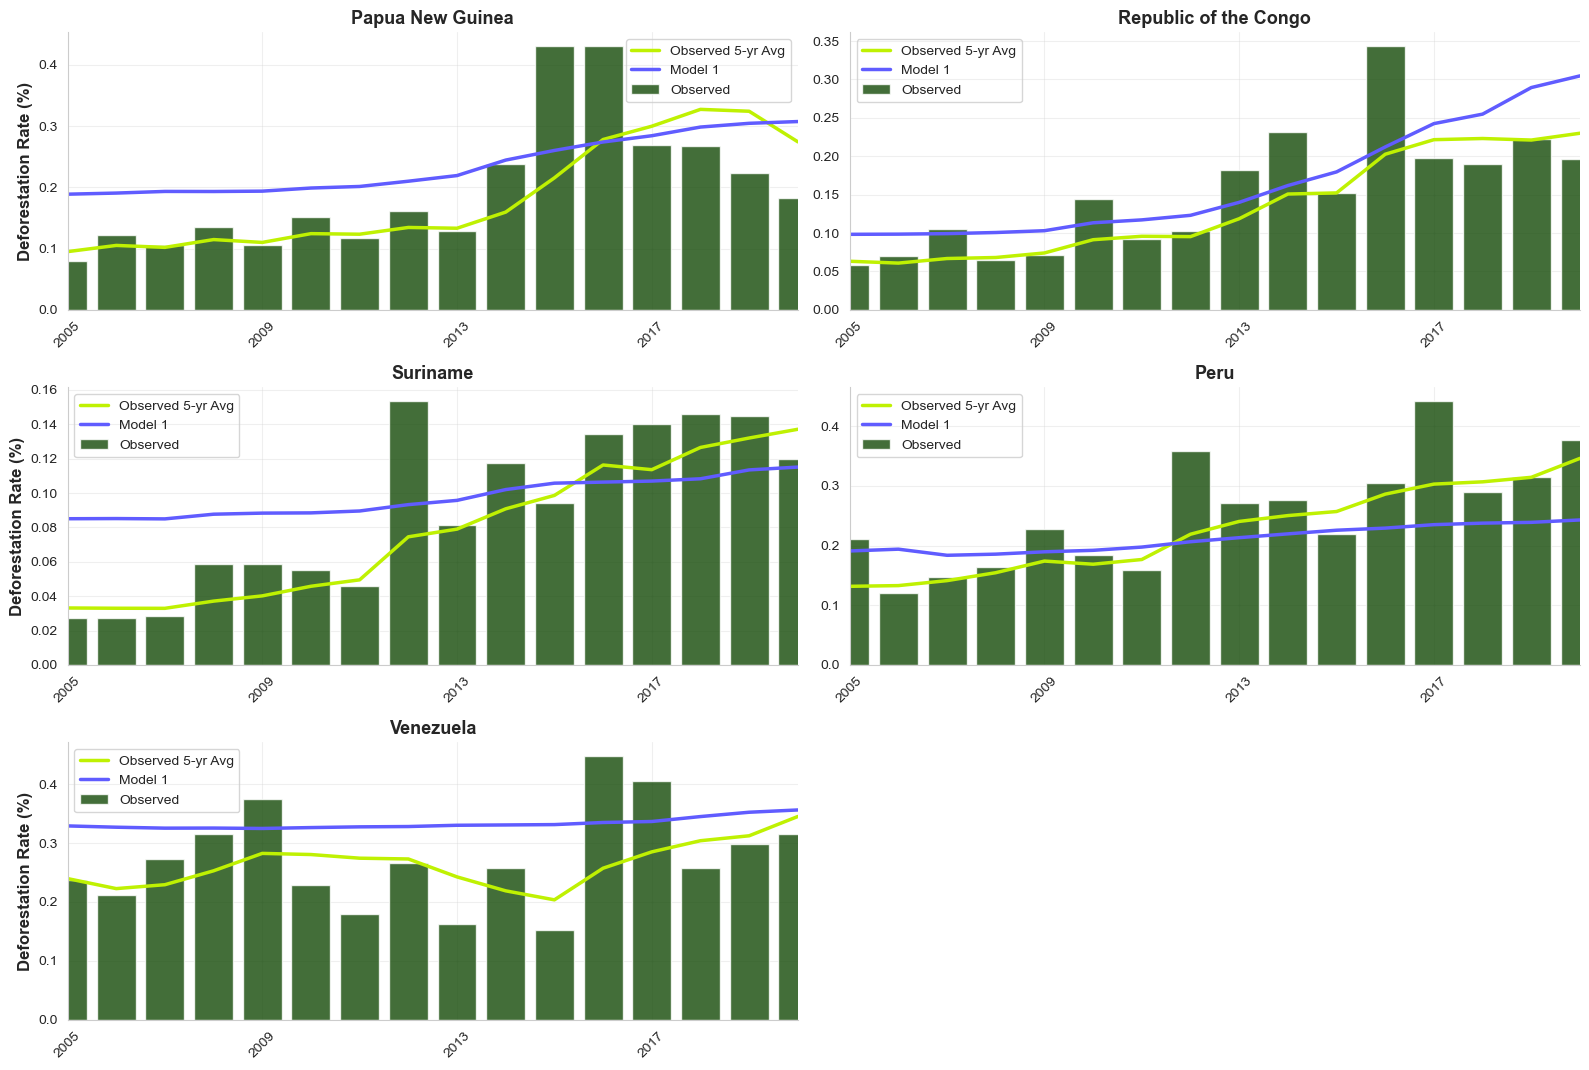

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Countries to include
countries = ["Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"]
add_tshuapa = False
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 2
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# Main countries
for idx, country in enumerate(countries):
    ax = axs[idx]

    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]

    if country_data.empty:
        ax.set_visible(False)
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'deforRate_5yr': (group['deforRate_5yr'] * weights).sum() / weights.sum(),
            'Model_1': (group['Model_1'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    # Plot observed bars
    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')

    # Plot 5-yr rolling observed as a line
    sns.lineplot(
        data=yearly_avg, x='year', y='deforRate_5yr',
        linewidth=2.5, color='#bff102ff', label='Observed 5-yr Avg', ax=ax
    )

    # Plot Model 1 line
    sns.lineplot(
        data=yearly_avg, x='year', y='Model_1',
        linewidth=2.5, color='#605cffff', label='Model 1', ax=ax
    )

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    # Show legend on every subplot
    ax.legend()

# # Hide unused subplots
# for ax in axs[total_plots:]:
#     ax.set_visible(False)

# Delete unused subplots (removes frames completely)
for idx in range(total_plots, len(axs)):
    fig.delaxes(axs[idx])

# Layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/Model1_set2.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


In [119]:
plotting_df.columns

Index(['admin', 'name', 'year', 'Area_x', 'area_mn', 'ed', 'elevation',
       'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2',
       'ppt', 'road_density', 'rural_pop_pct', 'slope', 'temp', 'country',
       'region', 'for_area', 'pc_for_area', 'deforRate', 'HFLD_score', 'HFLD',
       'deforRate_5yr', 'defor_yrs_used', 'HFLD_full_condition', 'biome',
       'forAreaPct', 'rf_predicted_model1_lag0', 'Model_1', 'Model_2',
       'Area_y', 'area_ha'],
      dtype='object')

/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1051737900.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_99984/1051737900.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()
/var/folde

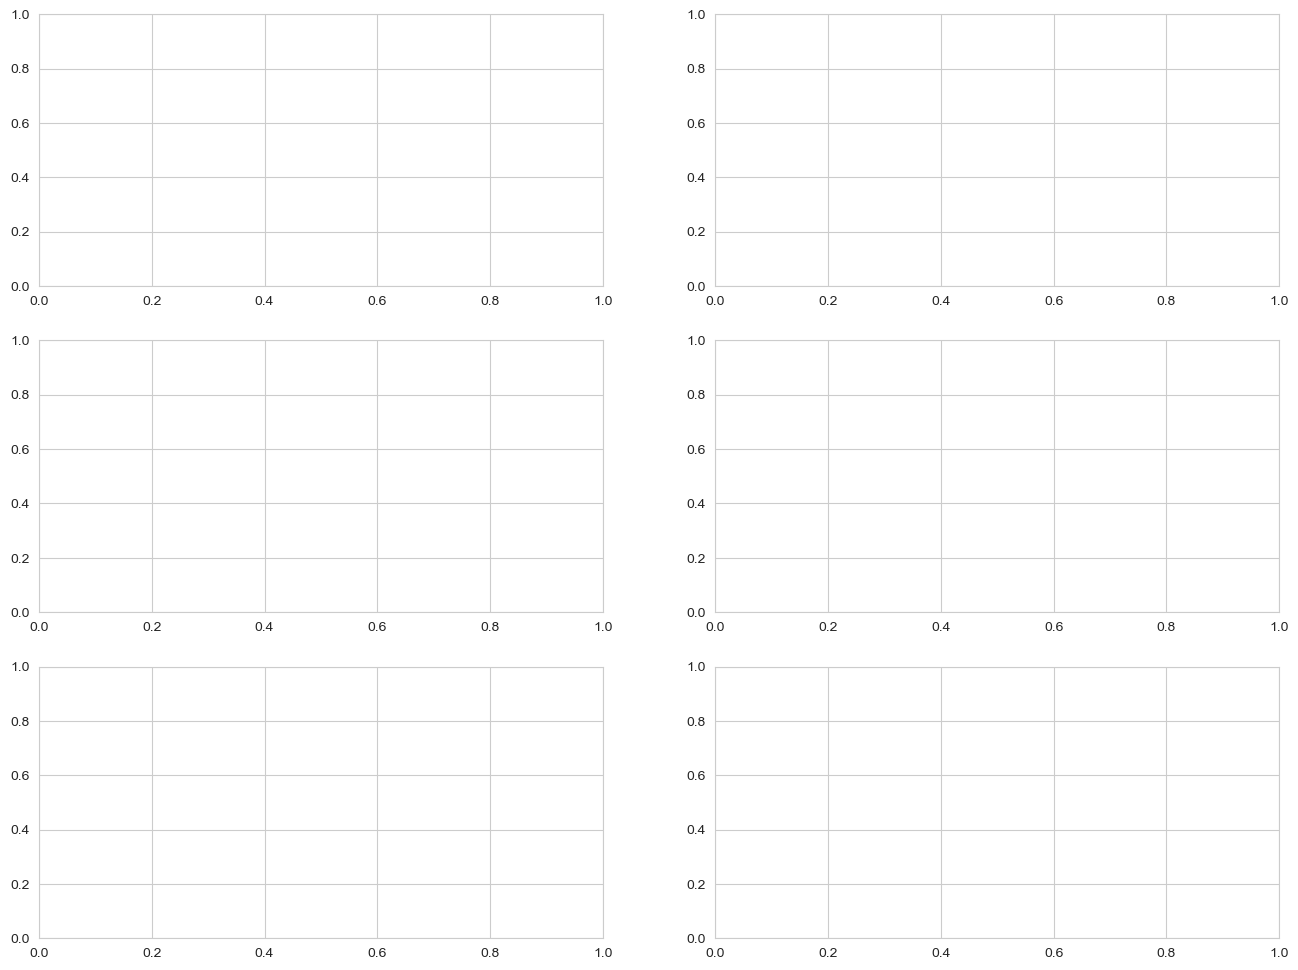

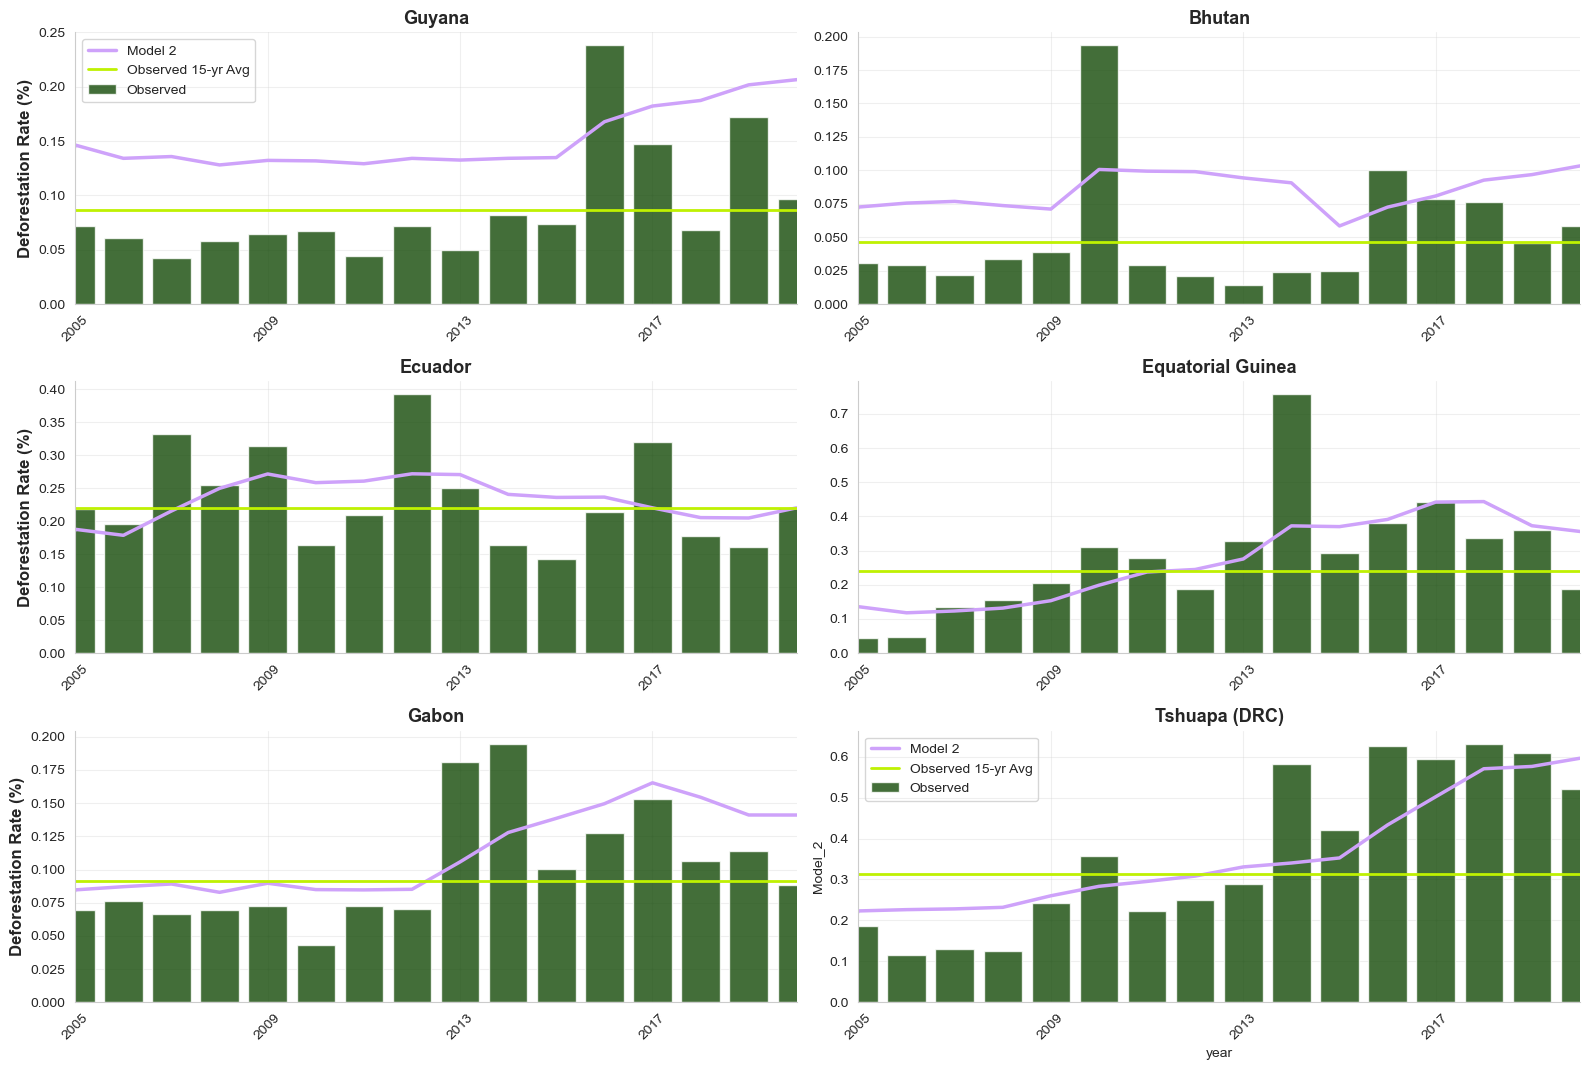

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Countries to include
countries = ["Guyana", "Bhutan", "Ecuador", "Equatorial Guinea", "Gabon"]
add_tshuapa = True
total_plots = len(countries) + (1 if add_tshuapa else 0)

n_cols = 2
n_rows = int(np.ceil(total_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axs = axs.flatten()

# Main countries
for idx, country in enumerate(countries):
    ax = axs[idx]

    country_data = plotting_df[
        (plotting_df['admin'] == country) &
        (plotting_df['Area_x'].notna())
    ]

    if country_data.empty:
        ax.set_visible(False)
        continue

    def weighted_avg(group):
        weights = group['Area_x']
        return pd.Series({
            'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
            'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
        })

    yearly_avg = country_data.groupby('year').apply(weighted_avg).reset_index()

    # Plot observed bars
    ax.bar(yearly_avg['year'], yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')

    # Plot Model 2 line
    sns.lineplot(data=yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=ax)

    # Plot horizontal line for 15-yr observed mean
    obs_mean = yearly_avg['deforRate'].mean()
    ax.axhline(obs_mean, color='#bff102ff', linestyle='-', linewidth=2, label='Observed 15-yr Avg')

    ax.set_title(country, fontsize=13, fontweight='bold')
    ax.set_xlim(2005, 2020)
    ax.set_xticks(range(2005, 2021, 4))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx % n_cols == 0:
        ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    # Only show legend for first subplot
    if idx == 0:
        ax.legend()
    else:
        ax.get_legend().remove()

# --- Tshuapa subplot ---
if add_tshuapa:
    tsh_ax = axs[len(countries)]
    tsh_data = plotting_df[
        (plotting_df['admin'] == 'Democratic Republic of the Congo') &
        (plotting_df['name'] == 'Tshuapa')
    ].sort_values('year')

    if not tsh_data.empty:
        def weighted_avg_tsh(group):
            weights = group['Area_x']
            return pd.Series({
                'deforRate': (group['deforRate'] * weights).sum() / weights.sum(),
                'Model_2': (group['Model_2'] * weights).sum() / weights.sum(),
            })

        tsh_yearly_avg = tsh_data.groupby('year').apply(weighted_avg_tsh).reset_index()

        tsh_ax.bar(tsh_yearly_avg['year'], tsh_yearly_avg['deforRate'], color='#144a08', alpha=0.8, label='Observed')
        sns.lineplot(data=tsh_yearly_avg, x='year', y='Model_2', linewidth=2.5, color='#cea2faff', label='Model 2', ax=tsh_ax)

        # Plot horizontal line for 15-yr observed mean
        obs_mean = tsh_yearly_avg['deforRate'].mean()
        tsh_ax.axhline(obs_mean, color='#bff102ff', linestyle='-', linewidth=2, label='Observed 15-yr Avg')

        tsh_ax.set_title("Tshuapa (DRC)", fontsize=13, fontweight='bold')
        tsh_ax.set_xlim(2005, 2020)
        tsh_ax.set_xticks(range(2005, 2021, 4))
        tsh_ax.tick_params(axis='x', rotation=45, labelsize=10)
        tsh_ax.tick_params(axis='y', labelsize=10)
        tsh_ax.grid(True, alpha=0.3)
        tsh_ax.spines['top'].set_visible(False)
        tsh_ax.spines['right'].set_visible(False)
        if (len(countries) % n_cols) == 0:
            tsh_ax.set_ylabel("Deforestation Rate (%)", fontsize=12, fontweight='bold')

        # Only show legend if it's the first plot in a row (if you want)
        tsh_ax.legend()

# Hide unused subplots
for ax in axs[total_plots:]:
    ax.set_visible(False)

# Layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig(output_path + "/country_outputs_model2_with_obs_mean.png", dpi=300, bbox_inches='tight', facecolor='none')
plt.show()


In [ ]:
"Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"

In [227]:
print(all_predictions_df[all_predictions_df['name'] == 'Équateur'])


                                 admin      name  year   area_mn        ed  \
4686  Democratic Republic of the Congo  Équateur  2005  0.013690  0.186011   
4687  Democratic Republic of the Congo  Équateur  2006  0.013628  0.186089   
4688  Democratic Republic of the Congo  Équateur  2007  0.013589  0.186082   
4689  Democratic Republic of the Congo  Équateur  2008  0.013723  0.186738   
4690  Democratic Republic of the Congo  Équateur  2009  0.013737  0.187733   
4691  Democratic Republic of the Congo  Équateur  2010  0.013513  0.188289   
4692  Democratic Republic of the Congo  Équateur  2011  0.013340  0.190273   
4693  Democratic Republic of the Congo  Équateur  2012  0.013337  0.190622   
4694  Democratic Republic of the Congo  Équateur  2013  0.013369  0.191028   
4695  Democratic Republic of the Congo  Équateur  2014  0.012834  0.192530   
4696  Democratic Republic of the Congo  Équateur  2015  0.012834  0.192523   
4697  Democratic Republic of the Congo  Équateur  2016  0.011863

In [200]:
plotting_df.columns

Index(['admin', 'name', 'year', 'Area_x', 'area_mn', 'ed', 'elevation',
       'gdp_pc_ppp', 'hdi', 'miningPct', 'nl', 'pd', 'plantnPct', 'popden_km2',
       'ppt', 'road_density', 'rural_pop_pct', 'slope', 'temp', 'country',
       'region', 'for_area', 'pc_for_area', 'deforRate', 'HFLD_score', 'HFLD',
       'deforRate_5yr', 'defor_yrs_used', 'HFLD_full_condition', 'biome',
       'forAreaPct', 'rf_predicted_model1_lag0', 'Model_1', 'Model_2_x',
       'Area_y', 'Model_2', 'area_ha'],
      dtype='object')

In [143]:
# Print weighted average deforestation values for Guyana and Bhutan in 2020

print("=== Weighted Average Deforestation Values for 2020 ===")
print()

# Get Guyana data for 2020
guyana_2020 = plotting_df[
    (plotting_df['admin'] == 'Guyana') &
    (plotting_df['year'] == 2020) &
    (plotting_df['Area_x'].notna())
]

if not guyana_2020.empty:
    # Calculate weighted averages for Guyana
    weights = guyana_2020['Area_x']
    guyana_model1_2020 = (guyana_2020['Model_1'] * weights).sum() / weights.sum()
    guyana_model2_2020 = (guyana_2020['Model_2'] * weights).sum() / weights.sum()

    print("GUYANA:")
    print(f"Model 1 - Deforestation 2020: {guyana_model1_2020:.4f}%")
    print(f"Model 2 - Deforestation 2020: {guyana_model2_2020:.4f}%")
else:
    print("GUYANA: No data available for 2020")

print()

# Get Bhutan data for 2020
bhutan_2020 = plotting_df[
    (plotting_df['admin'] == 'Bhutan') &
    (plotting_df['year'] == 2020) &
    (plotting_df['Area_x'].notna())
]

if not bhutan_2020.empty:
    # Calculate weighted averages for Bhutan
    weights = bhutan_2020['Area_x']
    bhutan_model1_2020 = (bhutan_2020['Model_1'] * weights).sum() / weights.sum()
    bhutan_model2_2020 = (bhutan_2020['Model_2'] * weights).sum() / weights.sum()

    print("BHUTAN:")
    print(f"Model 1 - Deforestation 2020: {bhutan_model1_2020:.4f}%")
    print(f"Model 2 - Deforestation 2020: {bhutan_model2_2020:.4f}%")
else:
    print("BHUTAN: No data available for 2020")

=== Weighted Average Deforestation Values for 2020 ===

GUYANA:
Model 1 - Deforestation 2020: 0.1753%
Model 2 - Deforestation 2020: 0.2810%

BHUTAN:
Model 1 - Deforestation 2020: 0.0626%
Model 2 - Deforestation 2020: 0.1603%


In [122]:
# List of countries and optional specific region (e.g., Tshuapa in DRC)
countries = ["Guyana", "Bhutan", "Ecuador", "Equatorial Guinea", "Gabon", "Japan",
             "Papua New Guinea", "Republic of the Congo", "Suriname", "Peru", "Venezuela"]
include_tshuapa = True

results = []

for country in countries:
    df = plotting_df[plotting_df['admin'] == country].copy()
    df = df[df['deforRate_5yr'].notna()]  # drop missing observed
    if df.empty:
        continue

    total_years = len(df)
    model1_gt = (df['Model_1'] > df['deforRate_5yr']).sum()
    model2_gt = (df['Model_2'] > df['deforRate_5yr']).sum()

    results.append({
        'Country': country,
        '% Years Model 1 > Observed': round(model1_gt / total_years * 100, 1),
        '% Years Model 2 > Observed': round(model2_gt / total_years * 100, 1)
    })

# Handle Tshuapa
if include_tshuapa:
    df = plotting_df[(plotting_df['admin'] == 'Democratic Republic of the Congo') &
                     (plotting_df['name'] == 'Tshuapa')].copy()
    df = df[df['deforRate_5yr'].notna()]
    if not df.empty:
        total_years = len(df)
        model1_gt = (df['Model_1'] > df['deforRate_5yr']).sum()
        model2_gt = (df['Model_2'] > df['deforRate_5yr']).sum()

        results.append({
            'Country': 'Tshuapa (DRC)',
            '% Years Model 1 > Observed': round(model1_gt / total_years * 100, 1),
            '% Years Model 2 > Observed': round(model2_gt / total_years * 100, 1)
        })

# View results
pd.DataFrame(results)

,Country,% Years Model 1 > Observed,% Years Model 2 > Observed
0,Guyana,67.5,61.5
1,Bhutan,56.4,35.7
2,Ecuador,54.8,17.6
3,Equatorial Guinea,47.0,43.0
4,Gabon,63.3,80.0
5,Japan,51.6,43.8
6,Papua New Guinea,57.5,55.8
7,Republic of the Congo,59.2,57.1
8,Suriname,50.5,45.5
9,Peru,46.1,20.0


In [202]:
hfld_all = plotting_df[plotting_df['HFLD_full_condition'] == 1].copy()


In [203]:
# Filter for HFLD rows
hfld_all = plotting_df[plotting_df['HFLD_full_condition'] == 1]

# Drop rows where either prediction is missing
hfld_all_valid = hfld_all.dropna(subset=['Model_1', 'Model_2'])

# Check how many rows were used for each
print("Original HFLD count:", len(hfld_all))
print("After dropping NA in both models:", len(hfld_all_valid))


Original HFLD count: 3583
After dropping NA in both models: 3574


In [204]:
hfld_all_valid.head()

,admin,name,year,Area_x,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,...,defor_yrs_used,HFLD_full_condition,biome,forAreaPct,rf_predicted_model1_lag0,Model_1,Model_2_x,Area_y,Model_2,area_ha
5,Angola,Bengo,2006,34209.40,0.001565,0.473885,237.511647,5028.169434,0.454000,0.000001,...,5,1,Africa,82.552938,0.361105,0.361105,0.168771,34209.40,0.168530,34209.40
44,Angola,Bié,2005,72580.00,0.010049,0.212232,1450.878343,4310.755859,0.439000,0.000227,...,5,1,Africa,94.214986,0.249798,0.249798,0.280708,72580.00,0.200647,72580.00
45,Angola,Bié,2006,72580.00,0.009914,0.211628,1450.878343,5028.169434,0.454000,0.000227,...,5,1,Africa,94.078216,0.261207,0.261207,0.245415,72580.00,0.201922,72580.00
64,Angola,Cabinda,2005,6746.17,0.001981,0.406214,157.535605,4294.113670,0.439607,0.004342,...,5,1,Africa,97.720577,0.351015,0.351015,0.267442,6746.17,0.237821,6746.17
65,Angola,Cabinda,2006,6746.17,0.002040,0.407228,157.535605,4967.152323,0.454164,0.004342,...,5,1,Africa,97.521885,0.340468,0.340468,0.267314,6746.17,0.236358,6746.17


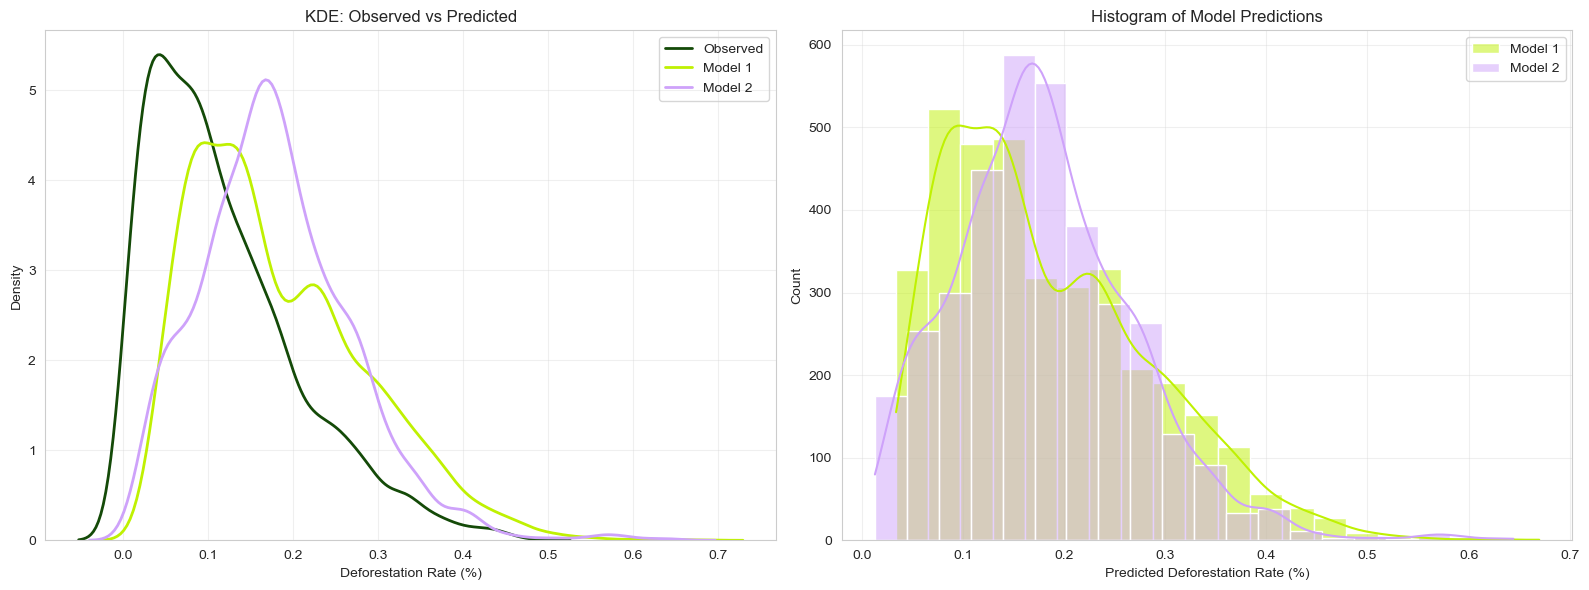

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter valid HFLD rows with no missing data
hfld_valid = plotting_df[
    (plotting_df['HFLD_full_condition'] == 1) &
    plotting_df['Model_1'].notna() &
    plotting_df['Model_2'].notna() &
    plotting_df['deforRate'].notna()
].copy()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Left plot: KDE (Observed vs Predicted)
sns.kdeplot(hfld_valid['deforRate'], label='Observed', color='#144a08', linewidth=2, ax=axes[0])
sns.kdeplot(hfld_valid['Model_1'], label='Model 1', color='#bff102ff', linewidth=2, ax=axes[0])
sns.kdeplot(hfld_valid['Model_2'], label='Model 2', color='#cea2faff', linewidth=2, ax=axes[0])
axes[0].set_xlabel("Deforestation Rate (%)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("KDE: Observed vs Predicted")

# --- Right plot: Histogram with KDE (Predictions)
sns.histplot(hfld_valid['Model_1'], color="#bff102ff", label='Model 1', kde=True, bins=20, ax=axes[1])
sns.histplot(hfld_valid['Model_2'], color="#cea2faff", label='Model 2', kde=True, bins=20, ax=axes[1])
axes[1].set_xlabel("Predicted Deforestation Rate (%)")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Histogram of Model Predictions")

# Layout & Save
plt.tight_layout()
plt.savefig(f"{output_path}/hfld_combined_kde_hist.png", dpi=300)
plt.show()


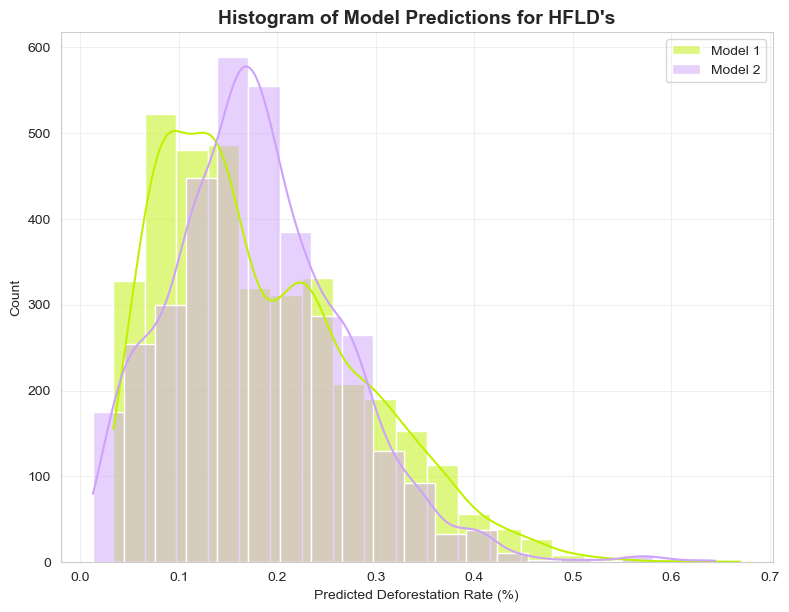

In [429]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter valid HFLD rows with no missing data
hfld_valid = plotting_df[
    (plotting_df['HFLD_full_condition'] == 1) &
    plotting_df['Model_1'].notna() &
    plotting_df['Model_2'].notna()
].copy()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'

# Create figure and axes (just one plot)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot Model 1 and Model 2
sns.histplot(hfld_valid['Model_1'], color="#bff102ff", label='Model 1', kde=True, bins=20, ax=ax, stat='count', alpha=0.5)
sns.histplot(hfld_valid['Model_2'], color="#cea2faff", label='Model 2', kde=True, bins=20, ax=ax, stat='count', alpha=0.5)

ax.set_xlabel("Predicted Deforestation Rate (%)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(True, alpha=0.3)
#ax.set_title("Histogram of Model Predictions")

plt.tight_layout()
ax.set_title("Histogram of Model Predictions for HFLD's", fontsize=14, fontweight='bold') 
plt.savefig(f"{output_path}/hfld_model_predictions_hist.png", dpi=300)
plt.show()


In [221]:
print(hfld_valid['Model_1'].quantile([0.05, 0.95]))
print(hfld_valid['Model_2'].quantile([0.05, 0.95]))


0.05    0.054487
0.95    0.372144
Name: Model_1, dtype: float64
0.05    0.044797
0.95    0.335292
Name: Model_2, dtype: float64


## Recreate the 'baseline' figure

In [149]:
# Read in the deforestation statistics
#plotting_df = pd.read_csv('/content/drive/Shareddrives/Assessments/Forward-deployed team/01. Projects/17. Predicted Deforestation - HFLD Work /Outputs/predictions.csv')

In [208]:
#Filter HFLD jurisdictions for 2020
hfld_2020 = plotting_df[
    (plotting_df['HFLD_full_condition'] == 1) &
    (plotting_df['year'] == 2020)
][['admin', 'name', 'deforRate', 'Model_1', 'Model_2']].copy()

#Calculate 2015–2019 average deforestation rate (baseline) for each HFLD jurisdiction
baseline = plotting_df[
    (plotting_df['HFLD_full_condition'] == 1) &
    (plotting_df['year'].between(2015, 2019))
].groupby(['admin', 'name'])['deforRate'].mean().reset_index().rename(columns={'deforRate': 'baseline_defor'})

#Merge baseline with 2020 predictions
hfld_comparison = pd.merge(hfld_2020, baseline, on=['admin', 'name'], how='left')
hfld_comparison = hfld_comparison.dropna(subset=['Model_1', 'Model_2', 'baseline_defor'])


In [209]:
# Compute deltas
hfld_comparison['delta_model1'] = hfld_comparison['Model_1'] - hfld_comparison['baseline_defor']
hfld_comparison['delta_model2'] = hfld_comparison['Model_2'] - hfld_comparison['baseline_defor']

In [210]:
# Total number of HFLD jurisdictions in the comparison
total = len(hfld_comparison)

# Count of jurisdictions where predicted < baseline
below_baseline_1 = (hfld_comparison['delta_model1'] < 0).sum()

# Count where predicted > baseline
above_baseline_1 = (hfld_comparison['delta_model1'] > 0).sum()

# Count where predicted == baseline (optional)
equal_baseline_1 = (hfld_comparison['delta_model1'] == 0).sum()

# Sanity check: sum should match total
print("=== Model 1 vs Baseline (2020) ===")
print(f"Total jurisdictions: {total}")
print(f"Predicted < Baseline: {below_baseline_1}")
print(f"Predicted > Baseline: {above_baseline_1}")
print(f"Predicted == Baseline: {equal_baseline_1}")
print(f"Sum check: {below_baseline_1 + above_baseline_1 + equal_baseline_1}")
# Total number of valid (non-missing) delta values for Model 2
valid_model2 = hfld_comparison['delta_model2'].dropna()
total_model2 = len(valid_model2)

# Count of jurisdictions where predicted < baseline
below_baseline_2 = (valid_model2 < 0).sum()

# Count where predicted > baseline
above_baseline_2 = (valid_model2 > 0).sum()

# Count where predicted == baseline (optional)
equal_baseline_2 = (valid_model2 == 0).sum()

# Sanity check: sum should match total
print("=== Model 2 vs Baseline (2020) ===")
print(f"Total jurisdictions: {total_model2}")
print(f"Predicted < Baseline: {below_baseline_2}")
print(f"Predicted > Baseline: {above_baseline_2}")
print(f"Predicted == Baseline: {equal_baseline_2}")
print(f"Sum check: {below_baseline_2 + above_baseline_2 + equal_baseline_2}")

# Optional: % below baseline
percent_below_2 = round(100 * below_baseline_2 / total_model2)
print(f"\nFor {percent_below_2}% of HFLDs, predicted deforestation risk from Model 2 is lower than the historic baseline.")



=== Model 1 vs Baseline (2020) ===
Total jurisdictions: 152
Predicted < Baseline: 29
Predicted > Baseline: 123
Predicted == Baseline: 0
Sum check: 152
=== Model 2 vs Baseline (2020) ===
Total jurisdictions: 152
Predicted < Baseline: 5
Predicted > Baseline: 147
Predicted == Baseline: 0
Sum check: 152

For 3% of HFLDs, predicted deforestation risk from Model 2 is lower than the historic baseline.


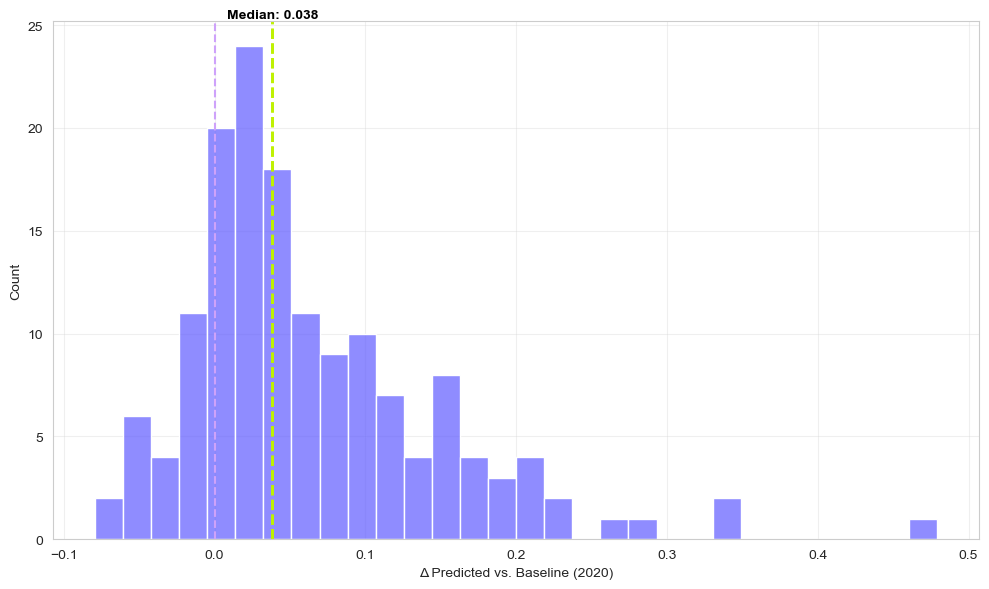

For 19% of HFLDs, predicted deforestation risk from Model 1 is lower than the historic baseline.


In [211]:
# Model 1
plt.figure(figsize=(10, 6))
sns.histplot(hfld_comparison['delta_model1'], bins=30, color='#605cffff', kde=False, alpha=0.7)

plt.axvline(0, color='#cea2faff', linestyle='--', linewidth=1.5)
plt.axvline(hfld_comparison['delta_model1'].median(), color='#bff102ff', linestyle='--', linewidth=2)

# Median line
median_val1 = hfld_comparison['delta_model1'].median()
plt.axvline(median_val1, color='#bff102ff', linestyle='--', linewidth=2)

# Add median text exactly at the top of the line
plt.text(
    median_val1,
    plt.gca().get_ylim()[1],      # max y-value of current axis
    f"Median: {median_val1:.3f}",
    color='black',                # black text
    ha='center',
    va='bottom',                  # stick to top of bar
    fontsize=10,
    fontweight='bold'
)



plt.xlabel("Δ Predicted vs. Baseline (2020)")
plt.ylabel("Count")
#plt.title("Change in Predicted vs. Baseline Deforestation (Model 1, HFLD 2020)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_path}/hfld_delta_model1_vs_baseline_2020.png", dpi=300)
plt.show()

# Total number of HFLD jurisdictions
total = len(hfld_comparison)

# --- Model 1 ---
below_baseline_1 = (hfld_comparison['delta_model1'] < 0).sum()
percent_below_1 = round(100 * below_baseline_1 / total)

print(f"For {percent_below_1}% of HFLDs, predicted deforestation risk from Model 1 is lower than the historic baseline.")

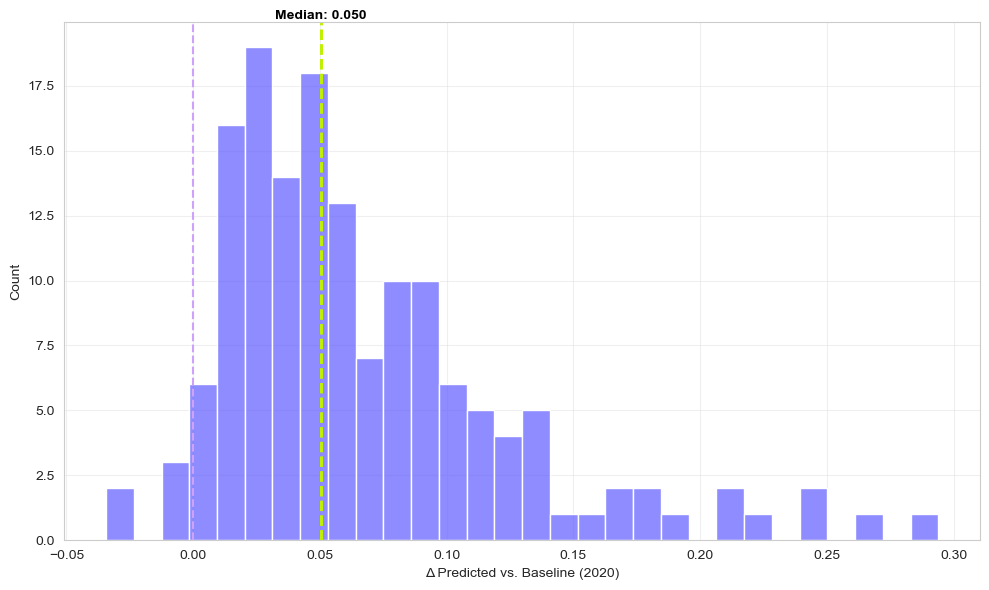

For 3% of HFLDs, predicted deforestation risk from Model 2 is lower than the historic baseline.


In [212]:
# Model 2
plt.figure(figsize=(10, 6))
sns.histplot(hfld_comparison['delta_model2'], bins=30, color='#605cffff', kde=False, alpha=0.7)

plt.axvline(0, color='#cea2faff', linestyle='--', linewidth=1.5)
plt.axvline(hfld_comparison['delta_model2'].median(), color='#bff102ff', linestyle='--', linewidth=2)

# Median line
median_val2 = hfld_comparison['delta_model2'].median()
plt.axvline(median_val2, color='#bff102ff', linestyle='--', linewidth=2)

# Add median text exactly at the top of the line
plt.text(
    median_val2,
    plt.gca().get_ylim()[1],      # max y-value of current axis
    f"Median: {median_val2:.3f}",
    color='black',                # black text
    ha='center',
    va='bottom',                  # stick to top of bar
    fontsize=10,
    fontweight='bold'
)


plt.xlabel("Δ Predicted vs. Baseline (2020)")
plt.ylabel("Count")
#plt.title("Change in Predicted vs. Baseline Deforestation (Model 1, HFLD 2020)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_path}/hfld_delta_model2_vs_baseline_2020.png", dpi=300)
plt.show()

valid_model2 = hfld_comparison['delta_model2'].dropna()
percent_below_2 = round(100 * (valid_model2 < 0).sum() / len(valid_model2))
print(f"For {percent_below_2}% of HFLDs, predicted deforestation risk from Model 2 is lower than the historic baseline.")

# Additional outputs


- Output a csv of the jurisdicitons, at country level and at state level which would be eligible for ART Trees HFLD crediting. So avg HFLD score >5 for 5 years. Can do this later as a throw in for ART (they asked) and for Singapore, maybe its helfpul to them
- Try linear regression for the defor. rate prediction step
- Add in jurisdiction area to the covariates, and use it to weight the country-wide average deforestation rates
- Try single RF step on all jurisdictions with the addition of feature selection
- IMPORTANT: Get the number of jurisdictions and host countries that had a HFLD status at some point between 2002-2020
- IMPORTANT: Get a dataframe of the jurisdictions which maintained their HFLD status from 2016 until 2020

In [213]:
# Get the jurisdictions with HFLD status between 2002 and 2020
HFLDs_2002_2020 = model_1_data.query('HFLD_full_condition == 1')

# Get the countries and the constituent regions
countries = HFLDs_2002_2020['admin']
regions = HFLDs_2002_2020['name']

# Pair each country with its HFLD
country_regions = set(zip(countries, regions))
print(f'{len(list(country_regions))} jurisdictions possessed HFLD status at some point between 2001 and 2020.')
print(f'{len(set(countries))} countries had at least one jurisdiction which possessed HFLD status at some point between 2001 and 2020.')

356 jurisdictions possessed HFLD status at some point between 2001 and 2020.
57 countries had at least one jurisdiction which possessed HFLD status at some point between 2001 and 2020.


In [214]:
# Get the jurisdictions with HFLD status in 2016
HFLDs_2016 = model_1_data.query('year == 2016 and HFLD_full_condition == 1')

# Get the countries and the constituent regions
countries = HFLDs_2016['admin']
regions = HFLDs_2016['name']

# Get the jurisdictions from 2016 to 2020 with HFLD status
HFLDs_2016_2020 = model_1_data.loc[(model_1_data['year'] >= 2016) & (model_1_data['HFLD_full_condition'] == 1) & (model_1_data['admin'].isin(countries)) & (model_1_data['name'].isin(regions))]

# Get the countries and the constituent regions
countries = HFLDs_2016_2020['admin']
regions = HFLDs_2016_2020['name']

# Pair each country with its HFLD
country_regions = set(zip(countries, regions))
print(f'{len(list(country_regions))} jurisdictions maintained their HFLD status from 2016 until 2020.')
HFLDs_2016_2020.to_csv(os.path.join(output_path, "HFLDs_2016_2020.csv"), index=False)
HFLDs_2016_2020.head()

171 jurisdictions maintained their HFLD status from 2016 until 2020.


,admin,name,year,area_mn,ed,elevation,gdp_pc_ppp,hdi,miningPct,nl,...,rural_pop_pct_lag4,temp_lag1,temp_lag2,temp_lag3,temp_lag4,forAreaPct_lag1,forAreaPct_lag2,forAreaPct_lag3,forAreaPct_lag4,Model_1
401,Angola,Lunda Norte,2016,0.015956,0.146097,946.661615,6892.566562,0.532213,0.207846,0.797305,...,38.732,225.399497,225.399497,225.399497,225.399497,98.034358,98.105351,98.228024,98.326838,0.117084
402,Angola,Lunda Norte,2017,0.015809,0.147936,946.661615,6892.566562,0.532213,0.207846,0.568675,...,37.998,225.399497,225.399497,225.399497,225.399497,97.921017,98.034358,98.105351,98.228024,0.119091
403,Angola,Lunda Norte,2018,0.014930,0.157749,946.661615,6892.566562,0.532213,0.207846,0.445275,...,37.269,225.399497,225.399497,225.399497,225.399497,97.797890,97.921017,98.034358,98.105351,0.125112
404,Angola,Lunda Norte,2019,0.012324,0.173324,946.661615,6892.566562,0.532213,0.207846,0.373950,...,36.554,225.399497,225.399497,225.399497,225.399497,97.684438,97.797890,97.921017,98.034358,0.134600
405,Angola,Lunda Norte,2020,0.011907,0.178576,946.661615,6892.566562,0.532213,0.207846,0.624813,...,35.851,225.399497,225.399497,225.399497,225.399497,97.593018,97.684438,97.797890,97.921017,0.136198


## Get avg defor rate for years during and after losing HFLD status and compare to avg defor rate for HFLDS remaining

In [157]:
# # Merge transition info into the full model_data
# model_data_with_transition = model_1_data.merge(
#     HFLD_2002_df[['admin', 'name', 'transition']],
#     on=['admin', 'name'],
#     how='inner'  # only keep rows where transition info is available
# )

# # Average deforestation for jurisdictions that remained HFLD (transition == 0)
# avg_defor_remain = model_data_with_transition[
#     (model_data_with_transition['HFLD_Binary'] == 1) &
#     (model_data_with_transition['transition'] == 0)
# ]['deforRate'].mean()

# # Average deforestation for jurisdictions that transitioned out of HFLD (transition == 1)
# avg_defor_trans = model_data_with_transition[
#     (model_data_with_transition['HFLD_Binary'] == 1) &
#     (model_data_with_transition['transition'] == 1)
# ]['deforRate'].mean()

# print(f"Average deforestation rate (2002–2020) for jurisdictions that remained HFLD: {avg_defor_remain:.4f}")
# print(f"Average deforestation rate (2002–2020) for jurisdictions that transitioned out of HFLD: {avg_defor_trans:.4f}")


In [220]:
import numpy as np

# 1. Get *only* regions HFLD in 2002
hfld_2002 = merged_df[(merged_df['year'] == 2002) & (merged_df['HFLD_full_condition'] == 1)]
hfld_2002_keys = set(zip(hfld_2002['admin'], hfld_2002['name']))

# 2. Restrict main DF to just those regions, all years
df_hfld = merged_df[merged_df.apply(lambda r: (r['admin'], r['name']) in hfld_2002_keys, axis=1)].copy()

# 3. For each, determine transition year (1→0 drop)
def get_transition_year(g):
    vals = g.sort_values('year')[['year', 'HFLD_full_condition']]
    lost = vals.loc[vals['HFLD_full_condition'].diff() == -1, 'year']
    return lost.iloc[0] if not lost.empty else np.nan

transition_years = (
    df_hfld.groupby(['admin', 'name'])
    .apply(get_transition_year)
    .reset_index(name='transition_year')
)

df_hfld = df_hfld.merge(transition_years, on=['admin', 'name'], how='left')

# 4. Separate post-transition and always-HFLD
df_trans = df_hfld[~df_hfld['transition_year'].isna()].copy()
df_remain = df_hfld[df_hfld['transition_year'].isna()].copy()

# 5. For transitioned: get mean *post-transition* per jurisdiction, then average
def mean_post_trans(g):
    tyear = g['transition_year'].iloc[0]
    post = g[g['year'] > tyear]
    return post['deforRate'].mean() if not post.empty else np.nan

post_means = (
    df_trans.groupby(['admin', 'name'])
    .apply(mean_post_trans)
    .dropna()
)
avg_defor_trans_post = post_means.mean()

# 6. For always-HFLD: mean rate per jurisdiction, then average
remain_means = (
    df_remain.groupby(['admin', 'name'])['deforRate'].mean()
)
avg_defor_remain = remain_means.mean()

print(f"Avg deforestation (remained HFLD): {avg_defor_remain:.4f}")
print(f"Avg deforestation (post-transition): {avg_defor_trans_post:.4f}")
print(f"% increase: {(avg_defor_trans_post / avg_defor_remain - 1) * 100:.1f}%")


Avg deforestation (remained HFLD): 0.0873
Avg deforestation (post-transition): 0.4874
% increase: 458.1%


/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_62970/946334365.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_transition_year)
/var/folders/hb/xz878qnj6_gcnq1qv98z_8400000gn/T/ipykernel_62970/946334365.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mean_post_trans)


In [218]:
print("Per-jurisdiction post-transition means:")
print(post_means.describe())
print("Number of transitioned jurisdictions:", post_means.shape[0])
print("Simple overall mean (all post-transition years):", hfld_trans_post['deforRate'].mean())
print("Time-normalized mean (avg of jurisdiction means):", avg_defor_trans_post)


Per-jurisdiction post-transition means:
count    334.000000
mean       0.524596
std        0.454351
min        0.012873
25%        0.212422
50%        0.411481
75%        0.716047
max        3.123138
dtype: float64
Number of transitioned jurisdictions: 334
Simple overall mean (all post-transition years): 0.5610905785223311
Time-normalized mean (avg of jurisdiction means): 0.524595563122037


In [ ]:
### test 